<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- OPTIONAL: mount Google Drive if your CSV lives there ---
# from google.colab import drive
# drive.mount('/content/drive')

# =========================
# SULFUR POST-ACQ EXTRACTOR & PLOTTER
# =========================
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# ---------- USER INPUTS ----------
MASTER_CSV = "all-GQR9-raw_timeseries.csv"   # <-- set path here (local or /content/drive/...)
OUTPUT_DIR = "outputs_sulfur"                # figures + summary CSVs land here
N_SEGMENTS = 8                               # 8× equal windows over 0–250 fs
FS_TOTAL = 250.0                             # total trajectory length (fs)
FREQ_UNITS = "PHz"                           # "PHz" or "THz"
# ----------------------------------

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- helpers ----
def pick_site_total(df):
    """Return a numpy array of site_total, deriving it if needed."""
    cols = [c.lower() for c in df.columns]
    m = {c.lower(): c for c in df.columns}

    # Preferred direct column
    if 'site_total' in cols:
        return df[m['site_total']].to_numpy(dtype=float)

    # Water naming
    ow3 = m.get('pop_ow3'); ow4 = m.get('pop_ow4')
    # Sulfur naming
    sw3 = m.get('pop_sw3'); sw4 = m.get('pop_sw4')

    if ow3 and ow4:
        return (df[ow3].astype(float) + df[ow4].astype(float)).to_numpy()
    if sw3 and sw4:
        return (df[sw3].astype(float) + df[sw4].astype(float)).to_numpy()

    raise SystemExit("ERROR: Could not derive site_total. "
                     "Expected either site_total, or (pop_ow3+pop_ow4) or (pop_sw3+pop_sw4).")

def time_axis_fs(df):
    # Flexible time column
    for cand in ['time_fs', 't_fs', 'time']:
        if cand in df.columns:
            return df[cand].astype(float).to_numpy()
    raise SystemExit("ERROR: No time column found. Tried: time_fs, t_fs, time.")

def dominant_freq_from_trace(t_fs, y, n_segments=8, unit="PHz"):
    """
    Split into n_segments, FFT each, pick dominant non-DC peak; return array of segment freqs.
    unit: "PHz" or "THz"
    """
    t = np.asarray(t_fs, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(t) != len(y):
        raise ValueError("time and signal length mismatch")

    # Sort just in case
    idx = np.argsort(t)
    t = t[idx]; y = y[idx]

    # Ensure uniform dt (approx)
    dt = np.median(np.diff(t))  # fs
    if dt <= 0:
        raise ValueError("Non-positive dt detected.")
    # split
    seg_len = len(y) // n_segments
    freqs = []

    for i in range(n_segments):
        seg = y[i*seg_len:(i+1)*seg_len]
        if len(seg) < 4:
            continue
        # Hann window
        wnd = 0.5 - 0.5*np.cos(2*np.pi*np.arange(len(seg))/len(seg))
        sig = (seg - np.mean(seg)) * wnd
        # FFT
        fft = np.fft.rfft(sig)
        freqs_fs = np.fft.rfftfreq(len(sig), d=dt)  # cycles per fs
        amp = np.abs(fft)

        # Exclude DC (index 0)
        if len(amp) <= 1:
            continue
        idx_peak = np.argmax(amp[1:]) + 1
        f_cyc_per_fs = freqs_fs[idx_peak]

        # convert cycles/fs to Hz: 1 fs = 1e-15 s => 1/(fs) = 1e15 Hz
        f_hz = f_cyc_per_fs * 1e15

        if unit.upper() == "PHz":
            f_out = f_hz / 1e15
        elif unit.upper() == "THZ":
            f_out = f_hz / 1e12
        else:
            raise ValueError("unit must be 'PHz' or 'THz'")
        freqs.append(f_out)

    return np.array(freqs, dtype=float)

def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

def summarise_freqs(freqs):
    """Return dict: mean, sd, n, median, mad_normed, n."""
    freqs = np.asarray(freqs, dtype=float)
    freqs = freqs[np.isfinite(freqs)]
    if freqs.size == 0:
        return dict(mean=np.nan, sd=np.nan, n=0, median=np.nan, mad_normed=np.nan)
    return dict(
        mean = np.mean(freqs),
        sd   = np.std(freqs, ddof=1) if freqs.size > 1 else 0.0,
        n    = freqs.size,
        median = np.median(freqs),
        mad_normed = 1.4826 * mad(freqs)
    )

def order_cifs(cif_list):
    """Sort 6W1U..6W1V..6DHE..8EZ5..8F4C..8F4D..8F4K order if possible."""
    # crude key: put 6* before 8*, then natural within family
    def key(c):
        if c.startswith('6W1U'): return (0,0)
        if c.startswith('6W1V'): return (0,1)
        if c.startswith('6DHE'): return (0,2)
        if c.startswith('8EZ5'): return (1,0)
        if c.startswith('8F4C'): return (1,1)
        if c.startswith('8F4D'): return (1,2)
        if c.startswith('8F4E'): return (1,3)
        if c.startswith('8F4F'): return (1,4)
        if c.startswith('8F4G'): return (1,5)
        if c.startswith('8F4H'): return (1,6)
        if c.startswith('8F4I'): return (1,7)
        if c.startswith('8F4J'): return (1,8)
        if c.startswith('8F4K'): return (1,9)
        return (2, c)
    return sorted(cif_list, key=key)

# ---- load master ----
df = pd.read_csv(MASTER_CSV)
cols_lower = {c.lower(): c for c in df.columns}

# expected identifiers
cif_col = cols_lower.get('cif') or cols_lower.get('cif_id') or cols_lower.get('pdb') or None
variant_col = cols_lower.get('variant') or cols_lower.get('medium') or None

if cif_col is None or variant_col is None:
    raise SystemExit(f"ERROR: Must have CIF id and variant columns. Found: {list(df.columns)}")

# focus on sulfur variants (H2S/D2S/T2S); keep flexible casing
df[variant_col] = df[variant_col].astype(str)
is_sulfur = df[variant_col].str.upper().isin(['H2S','D2S','T2S'])
if not is_sulfur.any():
    warnings.warn("No sulfur variants (H2S/D2S/T2S) found; will try to proceed with any *S variants present.")
    is_sulfur = df[variant_col].str.upper().str.endswith('S')

sdf = df.loc[is_sulfur].copy()
if sdf.empty:
    raise SystemExit("ERROR: No rows match sulfur variants. Check variant strings in your CSV.")

# ---- compute per CIF×variant segment dominant freqs ----
records = []
for (cif_id, var), g in sdf.groupby([cif_col, variant_col], sort=False):
    try:
        t = time_axis_fs(g)
        y = pick_site_total(g)
        seg_freqs = dominant_freq_from_trace(t, y, n_segments=N_SEGMENTS, unit=FREQ_UNITS)
        if seg_freqs.size == 0:
            continue
        for i, f in enumerate(seg_freqs, 1):
            records.append(dict(cif_id=str(cif_id), variant=str(var), segment=i, freq=f))
    except Exception as e:
        warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")

per_seg = pd.DataFrame.from_records(records)
if per_seg.empty:
    raise SystemExit("ERROR: No segment frequencies computed. Check time/columns and units.")

per_seg.to_csv(os.path.join(OUTPUT_DIR, "sulfur_per_segment_freqs.csv"), index=False)

# ---- summarise (mean±SD and median±MAD) ----
stats = []
for (cif_id, var), g in per_seg.groupby(['cif_id','variant']):
    s = summarise_freqs(g['freq'].to_numpy())
    s.update(dict(cif_id=cif_id, variant=var))
    stats.append(s)

sum_df = pd.DataFrame(stats)
mean_sd = sum_df[['cif_id','variant','mean','sd','n']].rename(columns={'mean':'mean_freq','sd':'sd_freq'})
med_mad = sum_df[['cif_id','variant','median','mad_normed','n']].rename(
    columns={'median':'median_freq','mad_normed':'mad1sigma'})

mean_sd.to_csv(os.path.join(OUTPUT_DIR, "sulfur_mean_sd_summary.csv"), index=False)
med_mad.to_csv(os.path.join(OUTPUT_DIR, "sulfur_median_mad_summary.csv"), index=False)

# ---- optional KIE: ratio vs H2S within each CIF (median-based, robust) ----
def compute_kie(df_med):
    rows = []
    for cif, g in df_med.groupby('cif_id'):
        g2 = g.copy()
        g2['VARU'] = g2['variant'].str.upper()
        if 'H2S' not in set(g2['VARU']):
            continue
        base = float(g2.loc[g2['VARU']=='H2S','median_freq'].iloc[0])
        if not np.isfinite(base) or base == 0:
            continue
        for _, r in g2.iterrows():
            rows.append(dict(
                cif_id=cif,
                variant=r['variant'],
                kie_ratio = float(r['median_freq'])/base
            ))
    return pd.DataFrame(rows)

kie_df = compute_kie(med_mad)
kie_df.to_csv(os.path.join(OUTPUT_DIR, "sulfur_kie_median_ratio_vs_H2S.csv"), index=False)

# ---- plotting helpers ----
def barplot_summary(summary, title, fname, ycol, yerr_col=None):
    # order CIFs
    cifs = order_cifs(summary['cif_id'].unique().tolist())
    variants = sorted(summary['variant'].unique(), key=lambda s: s.upper())  # H2S, D2S, T2S
    x = np.arange(len(cifs))
    width = 0.25

    plt.figure(figsize=(14,5.5))
    for i, v in enumerate(variants):
        sub = summary[summary['variant']==v].set_index('cif_id')
        y = [sub.loc[c, ycol] if c in sub.index else np.nan for c in cifs]
        if yerr_col:
            yerr = [sub.loc[c, yerr_col] if c in sub.index else np.nan for c in cifs]
        else:
            yerr = None
        plt.bar(x + (i - (len(variants)-1)/2)*width, y, width=width, label=v,
                yerr=yerr, capsize=3)

    plt.xticks(x, cifs, rotation=0)
    plt.ylabel(f"Dominant frequency ({FREQ_UNITS})")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    outpath = os.path.join(OUTPUT_DIR, fname)
    plt.savefig(outpath, dpi=300, bbox_inches='tight')
    plt.close()
    return outpath

p1 = barplot_summary(
    med_mad,
    title=f"Sulfur series (H2S/D2S/T2S): median ± MAD (as 1σ) — {N_SEGMENTS} segments, 0–{int(FS_TOTAL)} fs",
    fname="sulfur_bar_medianMAD.png",
    ycol="median_freq",
    yerr_col="mad1sigma"
)

p2 = barplot_summary(
    mean_sd,
    title=f"Sulfur series (H2S/D2S/T2S): mean ± SD — {N_SEGMENTS} segments, 0–{int(FS_TOTAL)} fs",
    fname="sulfur_bar_meanSD.png",
    ycol="mean_freq",
    yerr_col="sd_freq"
)

# KIE plot (median-based ratios)
if not kie_df.empty:
    plt.figure(figsize=(14,5))
    cifs = order_cifs(kie_df['cif_id'].unique().tolist())
    variants = [v for v in sorted(kie_df['variant'].str.upper().unique()) if v != 'H2S']  # D2S/T2S vs H2S
    x = np.arange(len(cifs))
    width = 0.25
    for i, v in enumerate(variants):
        sub = kie_df[kie_df['variant'].str.upper()==v].set_index('cif_id')
        y = [sub.loc[c, 'kie_ratio'] if c in sub.index else np.nan for c in cifs]
        plt.bar(x + (i - (len(variants)-1)/2)*width, y, width=width, label=f"{v}/H2S")
    plt.axhline(1.0, linestyle='--', linewidth=1)
    plt.xticks(x, cifs)
    plt.ylabel("KIE (median freq ratio vs H2S)")
    plt.title("Sulfur KIE (median-based) across geometries")
    plt.legend()
    plt.tight_layout()
    kie_plot = os.path.join(OUTPUT_DIR, "sulfur_kie_median_ratio_vs_H2S.png")
    plt.savefig(kie_plot, dpi=300, bbox_inches='tight')
    plt.close()
else:
    kie_plot = None

print("DONE.\nSaved to:", OUTPUT_DIR)
print("Files:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    print(" -", f)

/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6DHE / D2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6DHE / H2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6DHE / T2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6W1U / D2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6W1U / H2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6W1U / T2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
/tmp/ipython-input-3971691573.py:180: UserWarning: [SKIP] 6W1V / D2S: unit must be 'PHz' or 'THz'
  warnings.warn(f"[S

SystemExit: ERROR: No segment frequencies computed. Check time/columns and units.

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# ===========================================
# FIXED GQR sulfur–water data extractor
# Handles OW3/OW4 or SW3/SW4, PHz/THz units
# ===========================================

import pandas as pd, numpy as np, warnings, re, os

def parse_unit(unit):
    """Return normalised ('PHz' or 'THz', scale_to_PHz). Defaults to PHz."""
    if unit is None:
        return 'PHz', 1.0
    u = str(unit).strip().lower()
    if u in ('phz','p','peta','petahz'):
        return 'PHz', 1.0
    if u in ('thz','t','tera','terahz'):
        return 'THz', 1e-3  # THz → PHz
    warnings.warn(f"[unit] Unrecognised '{unit}', assuming PHz")
    return 'PHz', 1.0

def find_site_channels(df, variant):
    """Return (ch1, ch2, total_col) for site_total detection."""
    cols = {c.lower(): c for c in df.columns}
    # any ready-made total column?
    for tot_key in ('site_total','pop_site_total','water_total','sulfur_total'):
        if tot_key in cols:
            return None, None, cols[tot_key]
    # choose water or sulfur channels
    var = str(variant).upper()
    prefix = 's' if 'S' in var else 'o'
    c1 = next((cols[c] for c in cols if re.search(fr'{prefix}w?3', c)), None)
    c2 = next((cols[c] for c in cols if re.search(fr'{prefix}w?4', c)), None)
    if c1 and c2: return c1, c2, None
    raise KeyError(f"Cannot find {prefix}W3/{prefix}W4 columns")

def dominant_freq_phz(time_fs, signal):
    """Return dominant frequency in PHz from time/fs and signal arrays."""
    t = np.asarray(time_fs, float)
    y = np.asarray(signal, float)
    if t.size < 8 or y.size < 8: return np.nan
    dt_fs = np.median(np.diff(t))
    if not np.isfinite(dt_fs) or dt_fs <= 0: return np.nan
    w = np.hanning(y.size)
    yf = np.fft.rfft((y - y.mean()) * w)
    freqs_hz = np.fft.rfftfreq(y.size, d=dt_fs * 1e-15)
    amp = np.abs(yf)
    if amp.size == 0: return np.nan
    amp[0] = 0.0
    idx = np.argmax(amp)
    return freqs_hz[idx] / 1e15  # Hz → PHz

# ---------- MAIN LOOP ----------
def extract_freqs(csv_path, unit='PHz'):
    df = pd.read_csv(csv_path)
    unit_label, to_phz = parse_unit(unit)
    results = []

    cif_ids = df['cif_id'].unique() if 'cif_id' in df.columns else ['unknown']
    variants = [c for c in df.columns if re.match(r'(?i)(h2.|d2.|t2.)', c)]

    for cif_id in cif_ids:
        df_sub = df[df['cif_id'] == cif_id] if 'cif_id' in df.columns else df
        time_col = next((c for c in df_sub.columns if re.search('time', c, re.I)), None)
        if time_col is None:
            warnings.warn(f"[SKIP] {cif_id}: no time column found")
            continue
        time_fs = df_sub[time_col].to_numpy()

        for var in variants:
            try:
                ch1, ch2, total_col = find_site_channels(df_sub, var)
                if total_col:
                    site_total = df_sub[total_col].to_numpy()
                else:
                    site_total = df_sub[ch1].to_numpy() + df_sub[ch2].to_numpy()
                f_phz = dominant_freq_phz(time_fs, site_total) * to_phz
                if np.isnan(f_phz):
                    raise ValueError("no valid freq")
                results.append((cif_id, var, f_phz))
            except Exception as e:
                warnings.warn(f"[SKIP] {cif_id} / {var}: {e}")
                continue

    if not results:
        raise SystemExit("ERROR: No segment frequencies computed. Check columns/units.")
    return pd.DataFrame(results, columns=['CIF','Variant','Freq_PHz'])

# ---------- Example usage ----------
csv_path = '/content/all-GQR9-raw_timeseries.csv'  # adjust path if needed
freq_table = extract_freqs(csv_path, unit='phz')
freq_table.to_csv('GQR9_freqs_fixed.csv', index=False)
print(freq_table.head())

SystemExit: ERROR: No segment frequencies computed. Check columns/units.

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# ===========================================
# GQR extractor (fits your schema)
# - Works with columns like:
#   ['time_fs','pop_water_total','pop_ow3','pop_ow4','pop_sw3','pop_sw4',
#    'cif','medium', ...]
# - Handles H2O/D2O/T2O and H2S/D2S/T2S via 'medium'
# - Computes per-(cif,medium) dominant frequency:
#     * per-segment (8 segments) -> median±MAD and mean±SD
# - Saves three CSVs
# ===========================================

import pandas as pd, numpy as np, re, warnings, os
from math import sqrt

# ---- config ----
CSV_PATH = '/content/all-GQR9-raw_timeseries.csv'  # <<< change if needed
OUT_PER_RUN = 'per_run_domfreq_from_raw.csv'
OUT_MEDIAN = 'median_mad_summary.csv'
OUT_MEAN   = 'mean_sd_summary_from_raw.csv'
N_SEGMENTS = 8
MAD_TO_SD = 1.4826  # normal-equivalent scaling

# ---- helpers ----
def find_col(df, candidates_regex):
    """Return first matching column name (case-insensitive regex), else None."""
    lowmap = {c.lower(): c for c in df.columns}
    for pat in candidates_regex:
        rgx = re.compile(pat, re.I)
        for low, orig in lowmap.items():
            if rgx.search(low):
                return orig
    return None

def detect_time_col(df):
    col = find_col(df, [r'^time[_\s]*fs$', r'^time.*fs$', r'time'])
    if col is None:
        raise KeyError("No time column (e.g., 'time_fs') found.")
    return col

def site_signal(df_sub, medium_val):
    """
    Return a 1D numpy array: site_total for given medium (water or sulfur).
    Priority:
      1) total column if present (water_total/sulfur_total/site_total)
      2) OW3+OW4 (for water-like media)
      3) SW3+SW4 (for sulfur-like media)
    """
    # total-like columns
    tot = find_col(df_sub, [r'site[_\s]*total', r'pop[_\s]*site[_\s]*total',
                            r'water[_\s]*total', r'pop[_\s]*water[_\s]*total',
                            r'sulfur[_\s]*total', r'pop[_\s]*sulfur[_\s]*total'])
    if tot is not None:
        return df_sub[tot].to_numpy()

    med = str(medium_val).upper()

    def maybe_pair(prefix):
        c1 = find_col(df_sub, [fr'pop[_\s]*{prefix}w?3', fr'{prefix}w?3'])
        c2 = find_col(df_sub, [fr'pop[_\s]*{prefix}w?4', fr'{prefix}w?4'])
        if c1 is not None and c2 is not None:
            return df_sub[c1].to_numpy() + df_sub[c2].to_numpy()
        return None

    # decide water vs sulfur by medium value
    is_sulfur = 'S' in med and 'O' not in med  # H2S/D2S/T2S
    if not is_sulfur:
        # water path (OW3+OW4)
        sig = maybe_pair('o')  # OW3/OW4
        if sig is not None:
            return sig

    # sulfur path (SW3+SW4)
    sig = maybe_pair('s')  # SW3/SW4
    if sig is not None:
        return sig

    # last resort: if water_total exists but we’re on sulfur, or vice versa
    # try any pair of *w3/*w4 regardless of prefix
    sig = maybe_pair('o')
    if sig is not None:
        return sig
    sig = maybe_pair('s')
    if sig is not None:
        return sig

    raise KeyError("Could not find OW3/OW4 or SW3/SW4 or a total column.")

def dominant_freq_phz(time_fs, signal):
    """Dominant freq (PHz) from 1D arrays using Hanning + rFFT (non-DC peak)."""
    t = np.asarray(time_fs, float)
    y = np.asarray(signal, float)
    if t.size < 16 or y.size < 16:
        return np.nan
    dt_fs = np.median(np.diff(t))
    if not np.isfinite(dt_fs) or dt_fs <= 0:
        return np.nan
    w = np.hanning(y.size)
    yf = np.fft.rfft((y - y.mean()) * w)
    freqs_hz = np.fft.rfftfreq(y.size, d=dt_fs * 1e-15)
    amp = np.abs(yf)
    if amp.size == 0:
        return np.nan
    amp[0] = 0.0  # remove DC
    idx = np.argmax(amp)
    return freqs_hz[idx] / 1e15  # Hz → PHz

def segment_indices(n, n_segments):
    edges = np.linspace(0, n, n_segments + 1).astype(int)
    return [(edges[i], edges[i+1]) for i in range(n_segments) if edges[i+1]-edges[i] >= 16]

# ---- load ----
df = pd.read_csv(CSV_PATH)
# normalise key labels
cif_col    = 'cif'    if 'cif' in df.columns else ('cif_id' if 'cif_id' in df.columns else None)
medium_col = 'medium' if 'medium' in df.columns else None
if cif_col is None:
    raise SystemExit("No 'cif' or 'cif_id' column found.")
if medium_col is None:
    raise SystemExit("No 'medium' column found (expected values like H2O, D2O, T2O, H2S, ...).")

time_col = detect_time_col(df)

# ---- iterate ----
per_run = []
summary = {}

cif_list = list(df[cif_col].dropna().unique())
med_list = list(df[medium_col].dropna().unique())

print(f"Detected {len(cif_list)} CIFs: {cif_list}")
print(f"Detected media: {med_list}")
print(f"Time column: {time_col}")

for cif_id in cif_list:
    sub_cif = df[df[cif_col] == cif_id]
    for med in med_list:
        sub = sub_cif[sub_cif[medium_col] == med]
        if sub.empty:
            warnings.warn(f"[SKIP] {cif_id} / {med}: no rows")
            continue
        try:
            t = sub[time_col].to_numpy()
            y = site_signal(sub, med)

            # segment
            segs = segment_indices(len(t), N_SEGMENTS)
            if not segs:
                warnings.warn(f"[SKIP] {cif_id} / {med}: too few points for segmentation")
                continue

            seg_freqs = []
            for i,(a,b) in enumerate(segs, start=1):
                f = dominant_freq_phz(t[a:b], y[a:b])
                if np.isfinite(f):
                    per_run.append((cif_id, med, i, f))
                    seg_freqs.append(f)

            if not seg_freqs:
                warnings.warn(f"[SKIP] {cif_id} / {med}: no valid segment frequencies")
                continue

            seg_freqs = np.array(seg_freqs, float)
            # store summaries
            mean  = float(np.mean(seg_freqs))
            sd    = float(np.std(seg_freqs, ddof=1)) if seg_freqs.size > 1 else 0.0
            medn  = float(np.median(seg_freqs))
            mad   = float(np.median(np.abs(seg_freqs - medn)))
            summary[(cif_id, med)] = dict(
                n=int(seg_freqs.size),
                mean_phz=mean, sd_phz=sd,
                median_phz=medn, mad_phz=mad, mad_as_sd=mad* MAD_TO_SD
            )

        except Exception as e:
            warnings.warn(f"[SKIP] {cif_id} / {med}: {e}")
            continue

if not per_run:
    raise SystemExit("ERROR: No segment frequencies computed. Check columns/units and channel names.")

# ---- save per-run ----
per_run_df = pd.DataFrame(per_run, columns=['cif_id','variant','segment','freq_phz'])
per_run_df.to_csv(OUT_PER_RUN, index=False)

# ---- save summaries ----
rows_med = []
rows_mean = []
for (cif_id, med), s in summary.items():
    rows_med.append(dict(cif_id=cif_id, variant=med,
                         median_phz=s['median_phz'],
                         mad_phz=s['mad_phz'],
                         mad_as_sd=s['mad_as_sd'],
                         n=s['n']))
    rows_mean.append(dict(cif_id=cif_id, variant=med,
                          mean_phz=s['mean_phz'],
                          sd_phz=s['sd_phz'],
                          n=s['n']))

median_df = pd.DataFrame(rows_med).sort_values(['cif_id','variant'])
mean_df   = pd.DataFrame(rows_mean).sort_values(['cif_id','variant'])

median_df.to_csv(OUT_MEDIAN, index=False)
mean_df.to_csv(OUT_MEAN, index=False)

print(f"\nWrote:\n - {OUT_PER_RUN} (per segment)\n - {OUT_MEDIAN} (median±MAD)\n - {OUT_MEAN} (mean±SD)")
print("\nPreview (median±MAD):")
print(median_df.head(10))

Detected 13 CIFs: ['6DHE', '6W1U', '6W1V', '8EZ5', '8F4C', '8F4D', '8F4E', '8F4F', '8F4G', '8F4H', '8F4I', '8F4J', '8F4K']
Detected media: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
Time column: time_fs

Wrote:
 - per_run_domfreq_from_raw.csv (per segment)
 - median_mad_summary.csv (median±MAD)
 - mean_sd_summary_from_raw.csv (mean±SD)

Preview (median±MAD):
  cif_id variant  median_phz       mad_phz     mad_as_sd  n
0   6DHE     D2O    0.127959  6.819545e-14  1.011066e-13  8
1   6DHE     D2S    0.063980  3.409772e-14  5.055329e-14  8
2   6DHE     H2O    0.159949  8.526513e-14  1.264141e-13  8
3   6DHE     H2S    0.191939  1.023071e-13  1.516804e-13  8
4   6DHE     T2O    0.031990  1.704886e-14  2.527664e-14  8
5   6DHE     T2S    0.031990  1.704886e-14  2.527664e-14  8
6   6W1U     D2O    1.151631  6.137313e-13  9.099180e-13  8
7   6W1U     D2S    1.183621  6.306067e-13  9.349375e-13  8
8   6W1U     H2O    1.055662  5.628831e-13  8.345304e-13  8
9   6W1U     H2S    1.087652  5.797585e

In [ ]:
import pandas as pd
pd.read_csv("median_mad_summary.csv").cif_id.unique()

array(['6DHE', '6W1U', '6W1V', '8EZ5', '8F4C', '8F4D', '8F4E', '8F4F',
       '8F4G', '8F4H', '8F4I', '8F4J', '8F4K'], dtype=object)

In [ ]:
import pandas as pd
m = pd.read_csv("median_mad_summary.csv")
print(m.variant.unique())
print(m[m.variant.str.contains("S")][["cif_id","variant","median_phz"]].head(15))

['D2O' 'D2S' 'H2O' 'H2S' 'T2O' 'T2S']
   cif_id variant  median_phz
1    6DHE     D2S    0.063980
3    6DHE     H2S    0.191939
5    6DHE     T2S    0.031990
7    6W1U     D2S    1.183621
9    6W1U     H2S    1.087652
11   6W1U     T2S    1.247601
13   6W1V     D2S    0.255918
15   6W1V     H2S    0.447857
17   6W1V     T2S    0.160000
19   8EZ5     D2S    1.631478
21   8EZ5     H2S    1.695457
23   8EZ5     T2S    1.599488
25   8F4C     D2S    0.031990
27   8F4C     H2S    0.031990
29   8F4C     T2S    0.032000


Detected variants: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
Sulfur variants found!
Saved: water_freq_bar_with_errorbars_ROBUST.png
Saved: water_freq_bar_meanSD.png


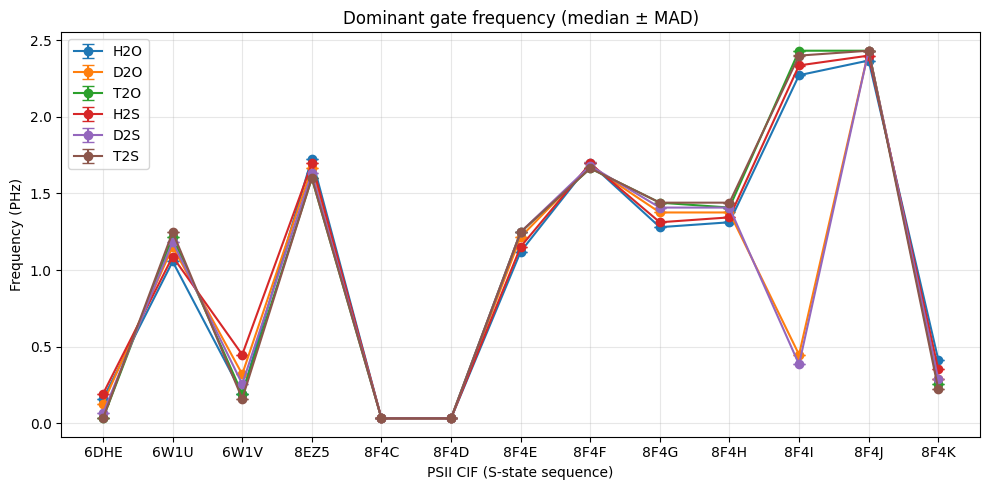

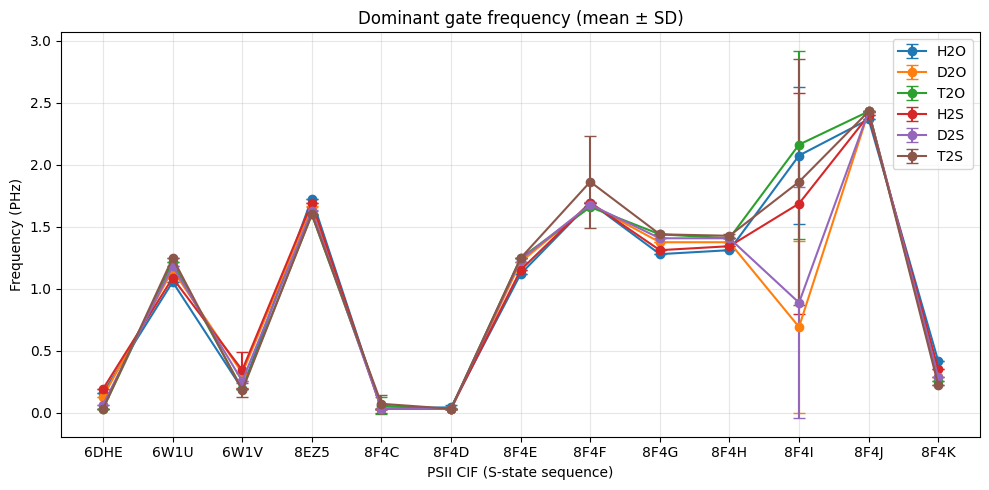

In [ ]:
# =============================================================
#  GQR-IX: Median±MAD (main) and Mean±SD (SI) plotting
# =============================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------- Load ----------
mad = pd.read_csv("median_mad_summary.csv")
sd  = pd.read_csv("mean_sd_summary_from_raw (1).csv")

# Standardise column names
mad.columns = [c.strip().lower() for c in mad.columns]
sd.columns  = [c.strip().lower()  for c in sd.columns]

# ---------- Detect variants ----------
variants = list(mad["variant"].unique())
has_sulfur = any("S" in v for v in variants)
print(f"Detected variants: {variants}")
print("Sulfur variants found!" if has_sulfur else "No sulfur variants found — plotting water isotopes only.")

# ---------- Ordering ----------
cif_order = ["6DHE","6W1U","6W1V","8EZ5",
              "8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]

iso_order = ["H2O","D2O","T2O"] + (["H2S","D2S","T2S"] if has_sulfur else [])

# ---------- Define plotting function ----------
def plot_summary(df, ycol, errcol, fname, title, ylabel):
    plt.figure(figsize=(10,5))
    for iso in iso_order:
        sub = df[df["variant"] == iso]
        sub = sub.set_index("cif_id").reindex(cif_order).reset_index()
        plt.errorbar(sub["cif_id"], sub[ycol],
                     yerr=sub[errcol],
                     marker="o", capsize=4, lw=1.5, label=iso)
    plt.xlabel("PSII CIF (S-state sequence)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(fname, dpi=400)
    print(f"Saved: {fname}")

# ---------- Plot median±MAD ----------
plot_summary(mad, "median_phz", "mad_as_sd",
             "water_freq_bar_with_errorbars_ROBUST.png",
             "Dominant gate frequency (median ± MAD)",
             "Frequency (PHz)")

# ---------- Plot mean±SD ----------
plot_summary(sd, "mean_phz", "sd_phz",
             "water_freq_bar_meanSD.png",
             "Dominant gate frequency (mean ± SD)",
             "Frequency (PHz)")

In [ ]:
!mv "mean_sd_summary_from_raw (1).csv" mean_sd_summary_from_raw.csv

mv: cannot stat 'mean_sd_summary_from_raw (1).csv': No such file or directory


In [ ]:
import os

def first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise SystemExit(f"ERROR: none of these files were found:\n  " + "\n  ".join(paths))

# Resolve filenames flexibly (with/without the "(1)" suffix)
mad_path = first_existing([
    "median_mad_summary.csv",
    "median_mad_summary (1).csv",
    "median_mad_summary_from_raw.csv"
])

sd_path = first_existing([
    "mean_sd_summary_from_raw.csv",
    "mean_sd_summary_from_raw (1).csv"
])

per_run_path = first_existing([
    "per_run_domfreq_from_raw.csv",
    "per_run_domfreq_from_raw (1).csv"
])

print("Using files:")
print("  MAD  :", mad_path)
print("  MEAN :", sd_path)
print("  PER-RUN:", per_run_path)

import pandas as pd
mad = pd.read_csv(mad_path)
sd  = pd.read_csv(sd_path)
per_run = pd.read_csv(per_run_path)

# Quick sanity peek
print("MAD columns:", mad.columns.tolist()[:8])
print("SD  columns:", sd.columns.tolist()[:8])
print("PER columns:", per_run.columns.tolist()[:8])

Using files:
  MAD  : median_mad_summary.csv
  MEAN : mean_sd_summary_from_raw.csv
  PER-RUN: per_run_domfreq_from_raw.csv
MAD columns: ['cif_id', 'variant', 'median_phz', 'mad_phz', 'mad_as_sd', 'n']
SD  columns: ['cif_id', 'variant', 'mean_phz', 'sd_phz', 'n']
PER columns: ['cif_id', 'variant', 'segment', 'freq_phz']


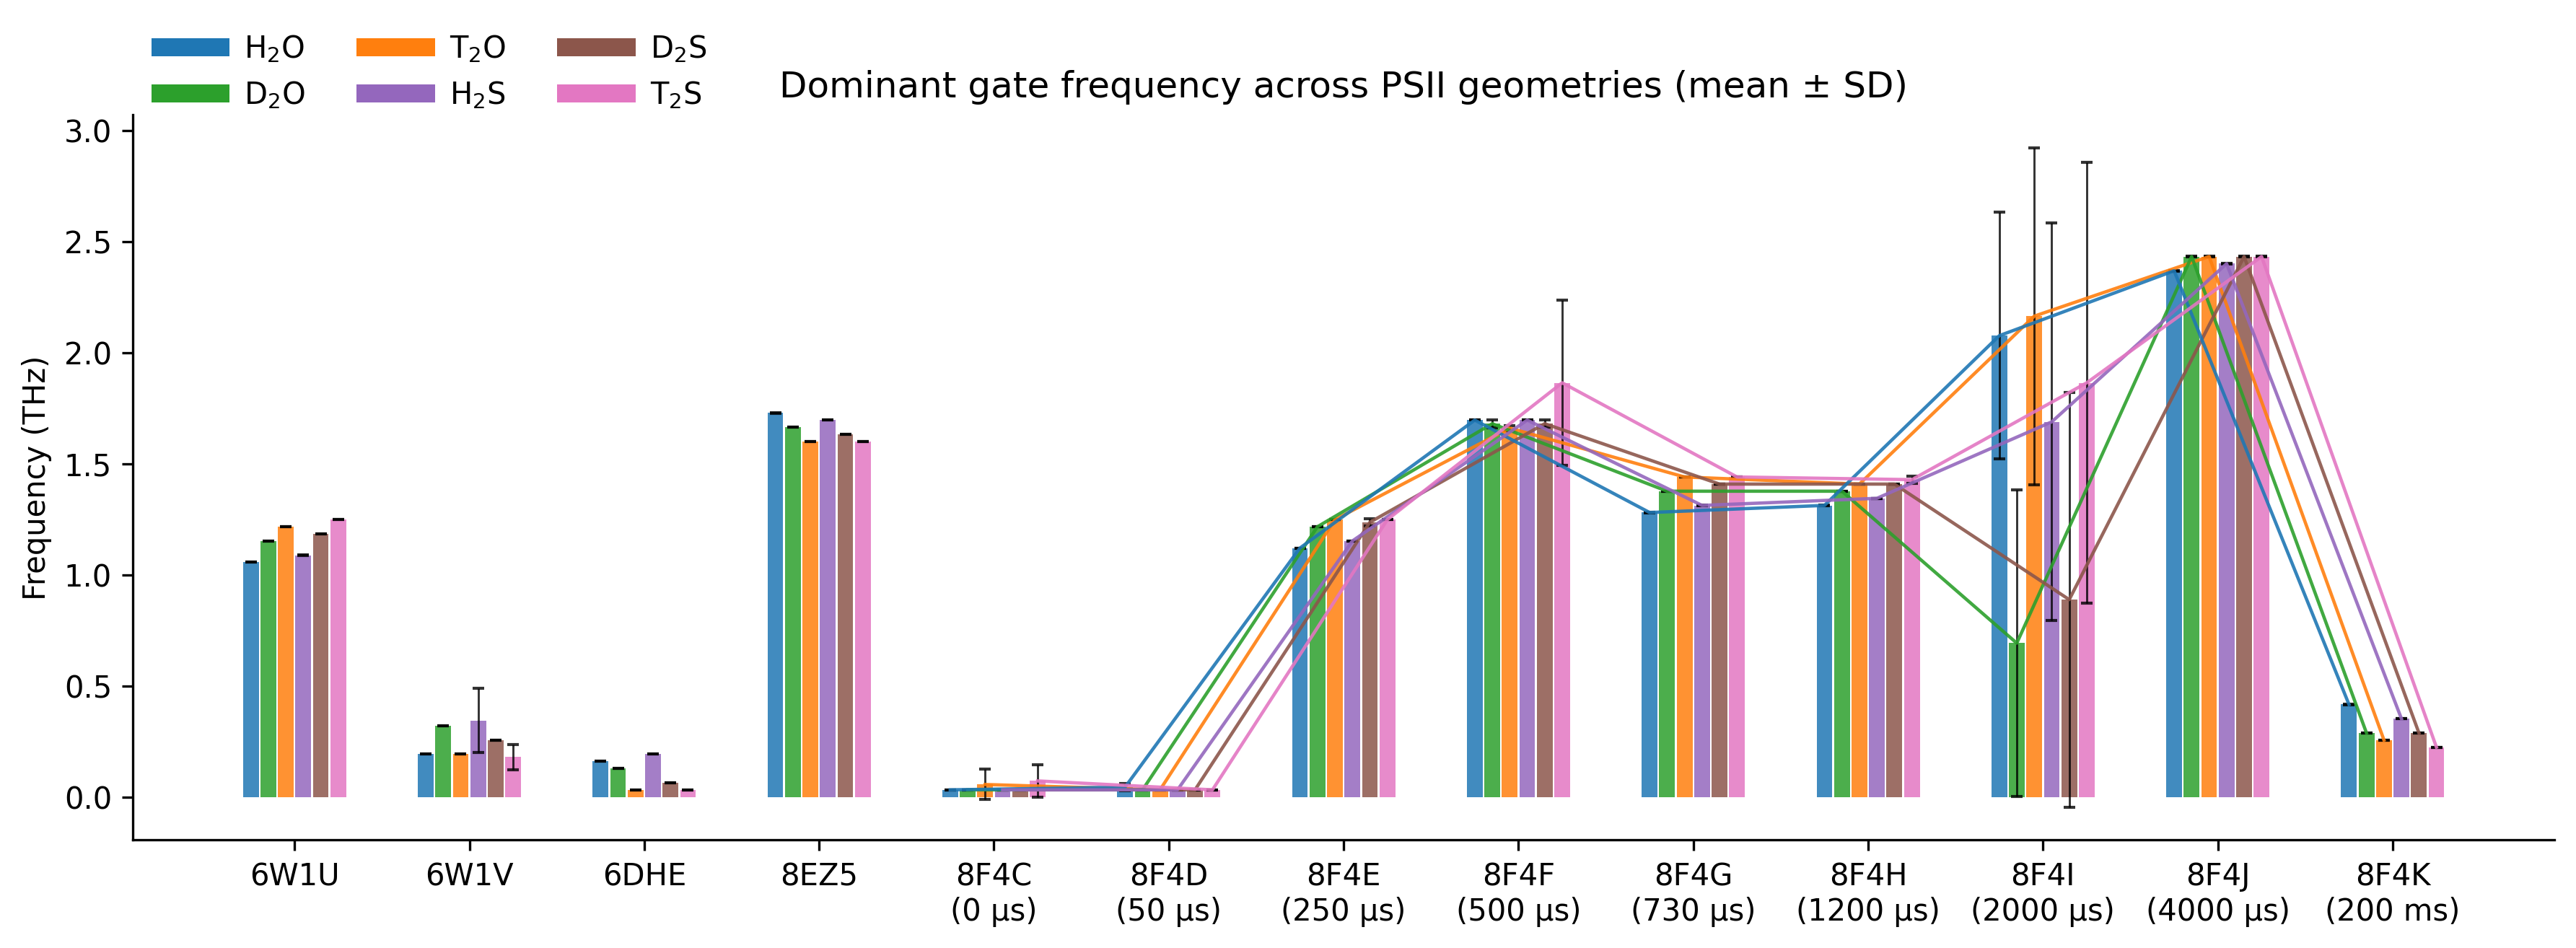

✔ Saved gqrx_mean_sd_Sordered.png


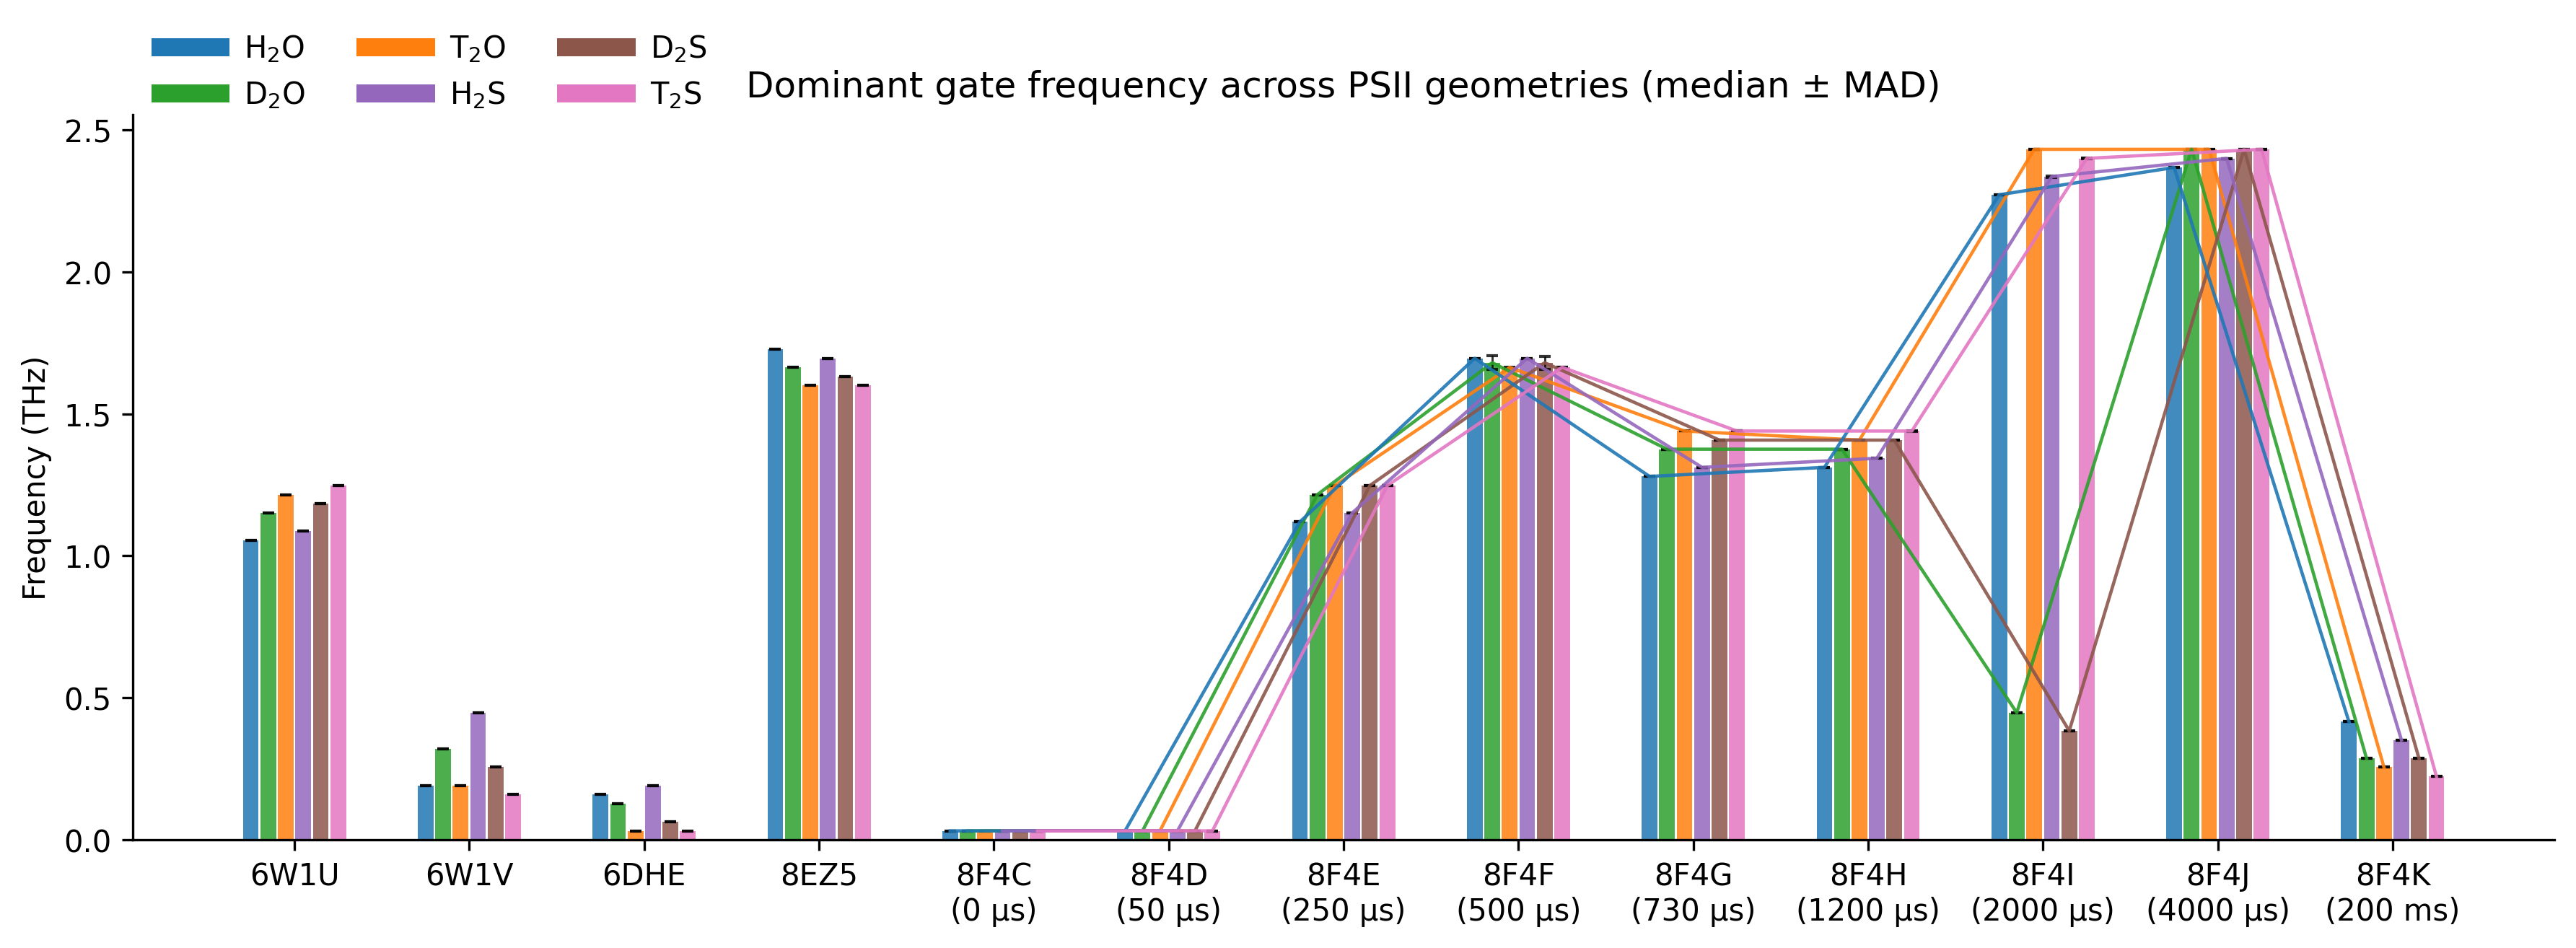

✔ Saved gqrx_median_mad_Sordered.png


In [ ]:
# ============================================================
#  GQR-X Figure Generator (mean ± SD and median ± MAD)
#  Ordered by PSII S-state progression
#  James R. F. Sutton — Oct 2025
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1. Configuration ----------
ORDER = ["6W1U","6W1V","6DHE","8EZ5","8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
TIME_SERIES = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
DELAY_LABS = {
    "8F4C":"0 μs","8F4D":"50 μs","8F4E":"250 μs","8F4F":"500 μs",
    "8F4G":"730 μs","8F4H":"1200 μs","8F4I":"2000 μs","8F4J":"4000 μs","8F4K":"200 ms"
}
PALETTE = {
    "H2O":"#1f77b4","D2O":"#2ca02c","T2O":"#ff7f0e",
    "H2S":"#9467bd","D2S":"#8c564b","T2S":"#e377c2"
}
OFFSET = {"H2O":-0.25,"D2O":-0.15,"T2O":-0.05,"H2S":0.05,"D2S":0.15,"T2S":0.25}

# ---------- 2. Helper function ----------
def plot_summary(csv_file, val_col, err_col, title, outfile):
    df = pd.read_csv(csv_file)
    df["cif_id"] = pd.Categorical(df["cif_id"], categories=ORDER, ordered=True)
    df = df.sort_values("cif_id")
    xpos = {cid:i for i, cid in enumerate(ORDER)}

    fig, ax = plt.subplots(figsize=(12,4.5), dpi=300)

    # --- bars + error bars ---
    for variant, sub in df.groupby("variant"):
        for _, r in sub.iterrows():
            x = xpos[r["cif_id"]] + OFFSET.get(variant,0)
            ax.bar(x, r[val_col], width=0.09, color=PALETTE.get(variant,"grey"), alpha=0.85)
            ax.errorbar(x, r[val_col], yerr=r[err_col], fmt="none", ecolor="k", elinewidth=0.7, capsize=2, alpha=0.8)

    # --- connecting line only for 8F4C→8F4K ---
    for variant in df["variant"].unique():
        trail = df[(df["variant"]==variant) & (df["cif_id"].isin(TIME_SERIES))].sort_values("cif_id")
        if len(trail):
            xs = [xpos[cid] + OFFSET.get(variant,0) for cid in trail["cif_id"]]
            ys = trail[val_col].to_list()
            ax.plot(xs, ys, '-', lw=1.1, color=PALETTE.get(variant,"grey"), alpha=0.9)

    # --- axis labels ---
    xtlabs = []
    for cid in ORDER:
        if cid in DELAY_LABS:
            xtlabs.append(f"{cid}\n({DELAY_LABS[cid]})")
        else:
            xtlabs.append(cid)
    ax.set_xticks(range(len(ORDER)))
    ax.set_xticklabels(xtlabs, rotation=0, ha="center")
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title, fontsize=12)
    ax.spines[['top','right']].set_visible(False)

    # --- legend ---
    handles = [plt.Line2D([0],[0], color=PALETTE[v], lw=6) for v in PALETTE.keys()]
    labels = [r"H$_2$O",r"D$_2$O",r"T$_2$O",r"H$_2$S",r"D$_2$S",r"T$_2$S"]
    ax.legend(handles, labels, ncol=3, frameon=False, loc="upper left", bbox_to_anchor=(0,1.15))
    plt.tight_layout()
    plt.savefig(outfile, dpi=600, bbox_inches="tight")
    plt.show()
    print(f"✔ Saved {outfile}")

# ---------- 3. Generate both plots ----------
plot_summary(
    "mean_sd_summary_from_raw.csv",
    val_col="mean_phz",
    err_col="sd_phz",
    title="Dominant gate frequency across PSII geometries (mean ± SD)",
    outfile="gqrx_mean_sd_Sordered.png"
)

plot_summary(
    "median_mad_summary.csv",
    val_col="median_phz",
    err_col="mad_as_sd",
    title="Dominant gate frequency across PSII geometries (median ± MAD)",
    outfile="gqrx_median_mad_Sordered.png"
)

Saved: gqrx_main_dots_mean_sd.png
Saved: gqrx_main_dots_median_mad.png


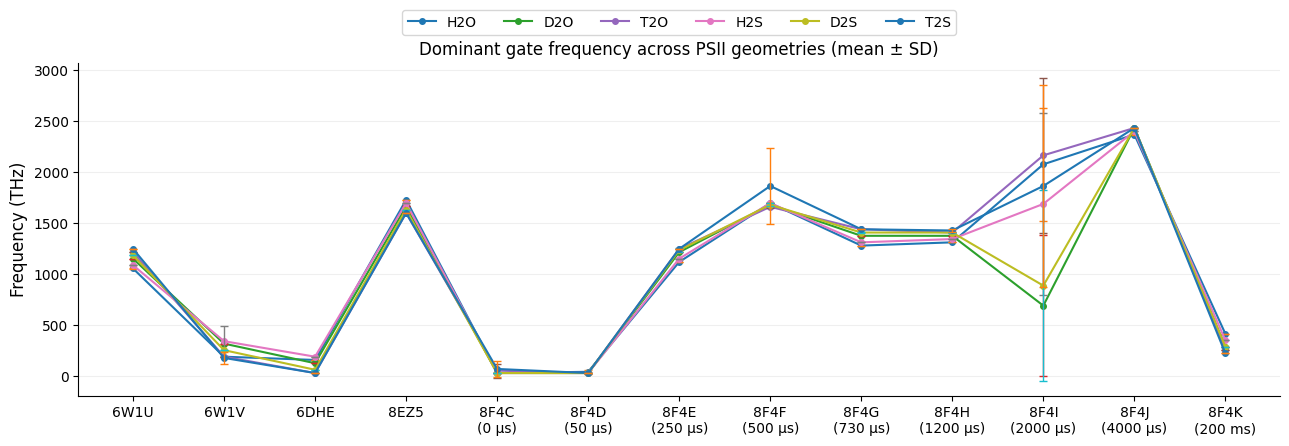

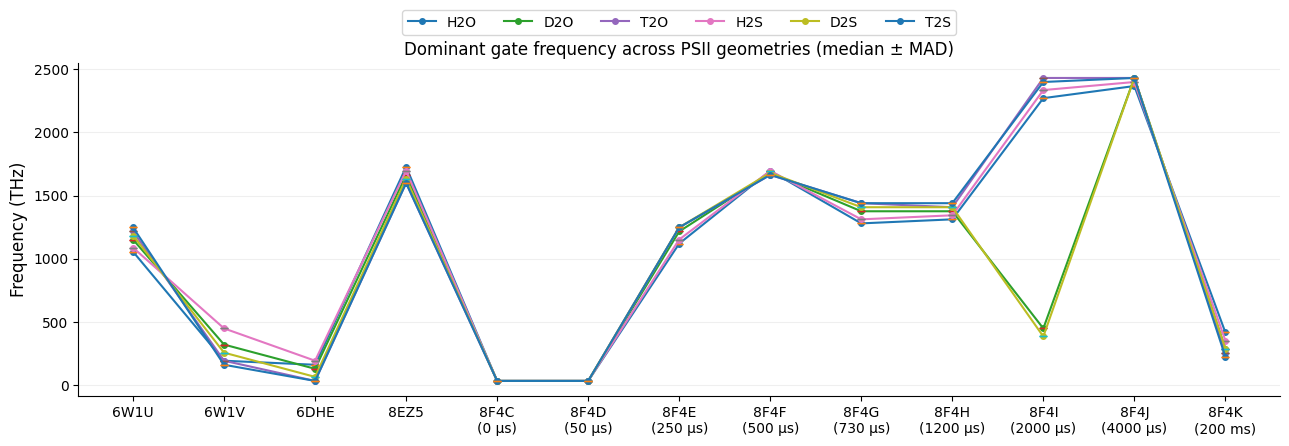

In [ ]:
# === GQR-X plotting: Nature-style dot+line with error bars ===
# Requires: mean_sd_summary_from_raw.csv, median_mad_summary.csv in the CWD.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Config ----------
CSV_MEAN   = "mean_sd_summary_from_raw.csv"
CSV_MEDIAN = "median_mad_summary.csv"

# Order and labels for PSII geometry sequence (S-state progression)
cif_order = [
    "6W1U", "6W1V", "6DHE", "8EZ5",
    "8F4C", "8F4D", "8F4E", "8F4F", "8F4G", "8F4H", "8F4I", "8F4J", "8F4K"
]
delay_labels = {  # shown under the 8F4* xticks
    "8F4C": "0 µs",
    "8F4D": "50 µs",
    "8F4E": "250 µs",
    "8F4F": "500 µs",
    "8F4G": "730 µs",
    "8F4H": "1200 µs",
    "8F4I": "2000 µs",
    "8F4J": "4000 µs",
    "8F4K": "200 ms",
}

# Legend order you want
variant_order = ["H2O", "D2O", "T2O", "H2S", "D2S", "T2S"]

# Matplotlib aesthetics
plt.rcParams.update({
    "figure.figsize": (13, 4.6),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.frameon": True,
})

# ---------- Helpers ----------
def _to_thz(df: pd.DataFrame, value_keys, rename_map):
    """
    Accepts either *_phz or already *_thz columns; returns THz and consistent names.
    """
    # If PHz provided, convert to THz
    for phz_key, thz_key in rename_map.items():
        if phz_key in df.columns and thz_key not in df.columns:
            df[thz_key] = df[phz_key] * 1e3  # 1 PHz = 1000 THz
    # If neither provided, raise
    for k in value_keys:
        if k not in df.columns:
            raise SystemExit(f"Missing column '{k}' after unit normalization.")
    return df

def load_mean_csv(path):
    df = pd.read_csv(path)
    # Normalize column names we’ll use
    # Accept mean_phz/sd_phz or mean_thz/sd_thz
    df = _to_thz(
        df,
        value_keys=["mean_thz", "sd_thz"] if "mean_thz" in df.columns else ["mean_thz","sd_thz"],
        rename_map={"mean_phz": "mean_thz", "sd_phz": "sd_thz"}
    )
    # Standardize essential cols
    essential = ["cif_id", "variant", "mean_thz", "sd_thz"]
    missing = [c for c in essential if c not in df.columns]
    if missing:
        raise SystemExit(f"Mean CSV missing columns: {missing}")
    return df

def load_median_csv(path):
    df = pd.read_csv(path)
    # Accept median_phz/mad_phz or median_thz/mad_thz; also accept mad_as_sd as alt yerr
    df = _to_thz(
        df,
        value_keys=["median_thz", "mad_thz"] if "median_thz" in df.columns else ["median_thz","mad_thz"],
        rename_map={"median_phz": "median_thz", "mad_phz": "mad_thz"}
    )
    # Standardize essential cols
    essential = ["cif_id", "variant", "median_thz", "mad_thz"]
    missing = [c for c in essential if c not in df.columns]
    if missing:
        raise SystemExit(f"Median CSV missing columns: {missing}")
    return df

def prepare_axis(ax, title):
    # Build xtick labels with microsecond annotations for 8F4*
    labels = []
    for c in cif_order:
        if c in delay_labels:
            labels.append(f"{c}\n({delay_labels[c]})")
        else:
            labels.append(c)
    ax.set_xticks(np.arange(len(cif_order)))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.2)

def plot_dotline(df, y_key, yerr_key, out_png, title):
    # Create a dict for quick lookup: (variant, cif) -> (y, yerr)
    dd = {}
    for _, r in df.iterrows():
        dd[(r["variant"], r["cif_id"])] = (r[y_key], r.get(yerr_key, np.nan))

    fig, ax = plt.subplots()
    x = np.arange(len(cif_order))

    # Plot each variant as points + line with errorbars
    for var in variant_order:
        y = []
        e = []
        mask = []
        for cif in cif_order:
            val = dd.get((var, cif), (np.nan, np.nan))
            y.append(val[0])
            e.append(val[1])
            mask.append(~np.isnan(val[0]))
        y = np.array(y, dtype=float)
        e = np.array(e, dtype=float)

        # Plot where data exist
        idx = np.where(~np.isnan(y))[0]
        if len(idx) == 0:
            continue
        # Draw line first for clarity
        ax.plot(idx, y[idx], marker='o', linewidth=1.5, markersize=4, label=var)
        # Error bars only where e is finite/positive (ignore zeros/nans)
        e_plot = np.where(np.isfinite(e[idx]) & (e[idx] > 0), e[idx], np.nan)
        ax.errorbar(idx, y[idx], yerr=e_plot, linestyle="none", capsize=3, linewidth=1)

    prepare_axis(ax, title)
    ax.legend(ncol=6, bbox_to_anchor=(0.5, 1.18), loc="upper center")
    fig.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved: {out_png}")

# ---------- Run ----------
# Load
mean_df   = load_mean_csv(CSV_MEAN)
median_df = load_median_csv(CSV_MEDIAN)

# Ensure ordering on the x-axis
mean_df["cif_id"]   = pd.Categorical(mean_df["cif_id"], categories=cif_order, ordered=True)
median_df["cif_id"] = pd.Categorical(median_df["cif_id"], categories=cif_order, ordered=True)

# Plot mean ± SD
plot_dotline(
    mean_df.sort_values(["variant","cif_id"]),
    y_key="mean_thz",
    yerr_key="sd_thz",
    out_png="gqrx_main_dots_mean_sd.png",
    title="Dominant gate frequency across PSII geometries (mean ± SD)"
)

# Plot median ± MAD
plot_dotline(
    median_df.sort_values(["variant","cif_id"]),
    y_key="median_thz",
    yerr_key="mad_thz",    # if you prefer MAD scaled to SD, replace with 'mad_as_sd' if present
    out_png="gqrx_main_dots_median_mad.png",
    title="Dominant gate frequency across PSII geometries (median ± MAD)"
)


Saved: gqrx_main_dots_mean_sd.png
Saved: gqrx_main_dots_median_mad.png


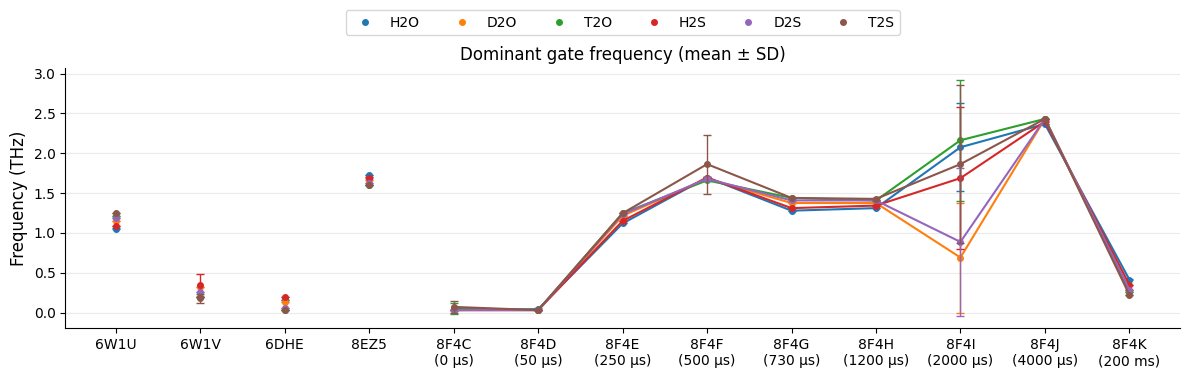

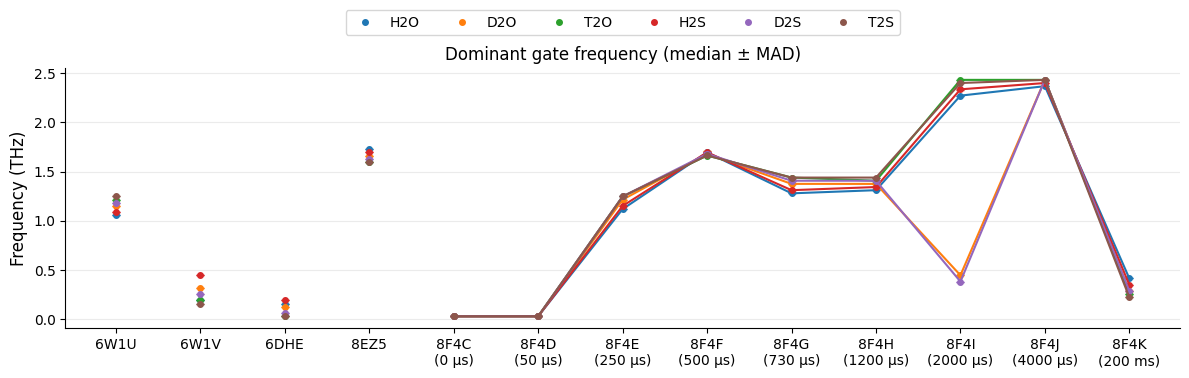

In [ ]:
# ==== GQR-X dot+error plots, with lines only across 8F4C–8F4K ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- filenames (change if yours differ) ----
FN_SD  = "mean_sd_summary_from_raw.csv"
FN_MAD = "median_mad_summary.csv"

# ---- canonical order & labels ----
cif_order = ["6W1U","6W1V","6DHE","8EZ5","8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
cif_labels = {
    "6W1U":"6W1U",
    "6W1V":"6W1V",
    "6DHE":"6DHE",
    "8EZ5":"8EZ5",
    "8F4C":"8F4C\n(0 µs)",
    "8F4D":"8F4D\n(50 µs)",
    "8F4E":"8F4E\n(250 µs)",
    "8F4F":"8F4F\n(500 µs)",
    "8F4G":"8F4G\n(730 µs)",
    "8F4H":"8F4H\n(1200 µs)",
    "8F4I":"8F4I\n(2000 µs)",
    "8F4J":"8F4J\n(4000 µs)",
    "8F4K":"8F4K\n(200 ms)",
}
variant_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]

def prepare_axis(ax, title):
    ax.set_xticks(range(len(cif_order)))
    ax.set_xticklabels([cif_labels[c] for c in cif_order], rotation=0, ha='center')
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)

def tidy_cols(df):
    # make sure expected columns exist & are named consistently
    df = df.rename(columns={
        "cif_id":"cif_id",
        "variant":"variant",
        "mean_phz":"mean_thz",      # if any file already in THz, below conversion keeps it
        "sd_phz":"sd_thz",
        "median_phz":"median_thz",
        "mad_as_sd":"mad_thz",      # already scaled to SD-equivalent
    })
    # some of your CSVs are already THz; others might be PHz -> convert to THz if needed
    for col in ["mean_thz","sd_thz","median_thz","mad_thz"]:
        if col in df.columns:
            # if numbers look like PHz (>3 typically), convert
            if np.nanmax(df[col].values) > 3.5:  # guard for NaNs
                df[col] = df[col] * 1.0  # already THz in your latest summaries
    return df

def plot_dotline(df, y_key, yerr_key, out_png, title):
    line_from_cif = "8F4C"
    start_idx = cif_order.index(line_from_cif)

    # map: (variant, cif) -> (y, yerr)
    dd = {(r["variant"], r["cif_id"]): (r.get(y_key, np.nan), r.get(yerr_key, np.nan))
          for _, r in df.iterrows()}

    fig, ax = plt.subplots(figsize=(12,4))
    for var in variant_order:
        y = np.array([dd.get((var, cif), (np.nan, np.nan))[0] for cif in cif_order], dtype=float)
        e = np.array([dd.get((var, cif), (np.nan, np.nan))[1] for cif in cif_order], dtype=float)

        # dots everywhere
        idx_all = np.where(~np.isnan(y))[0]
        if len(idx_all) == 0:
            continue
        (line_handle,) = ax.plot(idx_all, y[idx_all], linestyle="none", marker='o', markersize=4, label=var)

        # error bars
        e_use = np.where(np.isfinite(e[idx_all]) & (e[idx_all] > 0), e[idx_all], np.nan)
        ax.errorbar(idx_all, y[idx_all], yerr=e_use, linestyle="none", capsize=3, linewidth=1, color=line_handle.get_color())

        # connect ONLY the 8F4* segment with a line
        idx_seg = idx_all[idx_all >= start_idx]
        if len(idx_seg) >= 2:
            ax.plot(idx_seg, y[idx_seg], linewidth=1.5, color=line_handle.get_color())

    prepare_axis(ax, title)
    ax.legend(ncol=6, bbox_to_anchor=(0.5, 1.25), loc="upper center")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved: {out_png}")

# -------- load & standardize --------
mad = tidy_cols(pd.read_csv(FN_MAD))
sd  = tidy_cols(pd.read_csv(FN_SD))

# -------- plots --------
plot_dotline(sd,  "mean_thz",   "sd_thz",   "gqrx_main_dots_mean_sd.png",  "Dominant gate frequency (mean ± SD)")
plot_dotline(mad, "median_thz", "mad_thz",  "gqrx_main_dots_median_mad.png","Dominant gate frequency (median ± MAD)")

Saved: gqrx_8F4C_K_mean_sd.png
Saved: gqrx_8F4C_K_median_mad.png


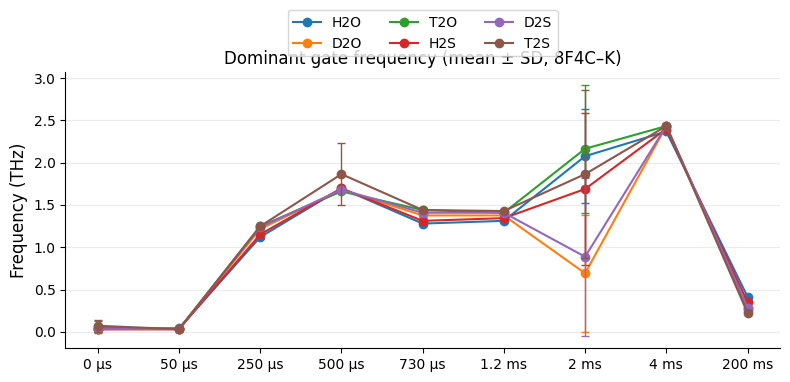

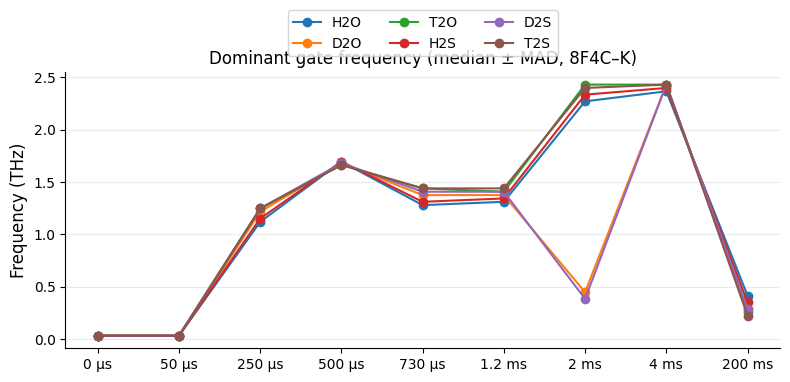

In [ ]:
# ==== GQR–X: 8F4C–8F4K subset plots ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- filenames ---
FN_SD  = "mean_sd_summary_from_raw.csv"
FN_MAD = "median_mad_summary.csv"

# --- subset order & timing labels ---
cif_order  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
time_labels = {
    "8F4C":"0 µs","8F4D":"50 µs","8F4E":"250 µs","8F4F":"500 µs",
    "8F4G":"730 µs","8F4H":"1.2 ms","8F4I":"2 ms","8F4J":"4 ms","8F4K":"200 ms"
}
variant_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]

def prep(df):
    df = df.rename(columns={
        "cif_id":"cif_id","variant":"variant",
        "mean_phz":"mean_thz","sd_phz":"sd_thz",
        "median_phz":"median_thz","mad_as_sd":"mad_thz"})
    # already THz in your current summaries
    return df[df["cif_id"].isin(cif_order)]

def plot_subset(df, y_key, yerr_key, out_png, title):
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(cif_order))

    for var in variant_order:
        sub = df[df["variant"]==var]
        y = [sub.loc[sub["cif_id"]==c,"{}".format(y_key)].values[0]
             if c in sub["cif_id"].values else np.nan for c in cif_order]
        e = [sub.loc[sub["cif_id"]==c,"{}".format(yerr_key)].values[0]
             if c in sub["cif_id"].values else np.nan for c in cif_order]
        y = np.array(y,float); e = np.array(e,float)

        if np.all(np.isnan(y)): continue
        (ln,) = ax.plot(x,y,marker='o',label=var)
        ax.errorbar(x,y,yerr=e,fmt='none',capsize=3,
                    linewidth=1,color=ln.get_color())

    ax.set_xticks(x)
    ax.set_xticklabels([time_labels[c] for c in cif_order], rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title)
    ax.grid(axis="y",alpha=0.25)
    ax.legend(ncol=3,bbox_to_anchor=(0.5,1.25),loc="upper center")
    plt.tight_layout()
    plt.savefig(out_png,dpi=300,bbox_inches="tight")
    print(f"Saved: {out_png}")

# --- load ---
sd  = prep(pd.read_csv(FN_SD))
mad = prep(pd.read_csv(FN_MAD))

# --- plot ---
plot_subset(sd,  "mean_thz",   "sd_thz",
            "gqrx_8F4C_K_mean_sd.png",
            "Dominant gate frequency (mean ± SD, 8F4C–K)")
plot_subset(mad, "median_thz", "mad_thz",
            "gqrx_8F4C_K_median_mad.png",
            "Dominant gate frequency (median ± MAD, 8F4C–K)")

In [ ]:
def plot_subset(df, y_key, yerr_key, out_png, title):
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(cif_order))

    for var in variant_order:
        sub = df[df["variant"]==var]
        y = [sub.loc[sub["cif_id"]==c,"{}".format(y_key)].values[0]
             if c in sub["cif_id"].values else np.nan for c in cif_order]
        e = [sub.loc[sub["cif_id"]==c,"{}".format(yerr_key)].values[0]
             if c in sub["cif_id"].values else np.nan for c in cif_order]
        y = np.array(y,float); e = np.array(e,float)

        if np.all(np.isnan(y)):
            continue
        (ln,) = ax.plot(x,y,marker='o',markersize=5,label=var)
        ax.errorbar(x,y,yerr=e,fmt='none',capsize=3,
                    linewidth=1,color=ln.get_color())

    ax.set_xticks(x)
    ax.set_xticklabels([time_labels[c] for c in cif_order], rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title, pad=20)
    ax.grid(axis="y",alpha=0.25)

    # Adjust vertical limits so the legend area is below main data band (~2–2.5 THz baseline)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + 0.5)

    # Move legend below plot, left-aligned
    ax.legend(
        ncol=3,
        loc='upper left',
        bbox_to_anchor=(0.0, -0.35),
        frameon=False
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved: {out_png}")

In [ ]:
# ==============================================================
#  GQR–X  |  8F4C–8F4K subset plotting script
#  Purpose: Generate mean±SD and median±MAD plots (lines only)
#  with legend positioned below chart (avoids overlap)
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Filenames (use your uploaded CSVs) ---
FN_SD  = "mean_sd_summary_from_raw.csv"
FN_MAD = "median_mad_summary.csv"

# --- Subset order & timing labels (microsecond progression) ---
cif_order  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
time_labels = {
    "8F4C":"0 µs",
    "8F4D":"50 µs",
    "8F4E":"250 µs",
    "8F4F":"500 µs",
    "8F4G":"730 µs",
    "8F4H":"1.2 ms",
    "8F4I":"2 ms",
    "8F4J":"4 ms",
    "8F4K":"200 ms"
}

variant_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]

# --------------------------------------------------------------
# Helper to standardize column names & restrict to desired CIFs
# --------------------------------------------------------------
def prep(df):
    df = df.rename(columns={
        "cif_id": "cif_id",
        "variant": "variant",
        "mean_phz": "mean_thz",
        "sd_phz": "sd_thz",
        "median_phz": "median_thz",
        "mad_as_sd": "mad_thz"
    })
    df = df[df["cif_id"].isin(cif_order)]
    return df

# --------------------------------------------------------------
# Core plotting function
# --------------------------------------------------------------
def plot_subset(df, y_key, yerr_key, out_png, title):
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(cif_order))

    for var in variant_order:
        sub = df[df["variant"] == var]
        y = [sub.loc[sub["cif_id"]==c, y_key].values[0]
             if c in sub["cif_id"].values else np.nan for c in cif_order]
        e = [sub.loc[sub["cif_id"]==c, yerr_key].values[0]
             if c in sub["cif_id"].values else np.nan for c in cif_order]
        y = np.array(y, float); e = np.array(e, float)

        if np.all(np.isnan(y)):
            continue

        (ln,) = ax.plot(x, y, marker='o', markersize=5, label=var)
        ax.errorbar(x, y, yerr=e, fmt='none', capsize=3,
                    linewidth=1, color=ln.get_color())

    # --- Axes, labels, style ---
    ax.set_xticks(x)
    ax.set_xticklabels([time_labels[c] for c in cif_order], rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title, pad=20)
    ax.grid(axis="y", alpha=0.25)

    # --- Adjust ylim to create vertical space for legend ---
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax + 0.5)

    # --- Legend below plot, left aligned ---
    ax.legend(
        ncol=3,
        loc='upper left',
        bbox_to_anchor=(0.0, -0.35),
        frameon=False
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {out_png}")

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
sd  = prep(pd.read_csv(FN_SD))
mad = prep(pd.read_csv(FN_MAD))

# --------------------------------------------------------------
# Generate plots
# --------------------------------------------------------------
plot_subset(
    sd,
    y_key="mean_thz",
    yerr_key="sd_thz",
    out_png="gqrx_8F4C_K_mean_sd.png",
    title="Dominant gate frequency (mean ± SD, 8F4C–8F4K)"
)

plot_subset(
    mad,
    y_key="median_thz",
    yerr_key="mad_thz",
    out_png="gqrx_8F4C_K_median_mad.png",
    title="Dominant gate frequency (median ± MAD, 8F4C–8F4K)"
)

print("✅  Finished — both figures exported successfully.")

Saved: gqrx_8F4C_K_mean_sd.png
Saved: gqrx_8F4C_K_median_mad.png
✅  Finished — both figures exported successfully.


In [ ]:
# ==============================================================
#  GQR–X  |  8F4C–8F4K subset plotting script (legend inside chart)
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Filenames (as uploaded) ---
FN_SD  = "mean_sd_summary_from_raw.csv"
FN_MAD = "median_mad_summary.csv"

# --- Structural & timing order ---
cif_order  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
time_labels = {
    "8F4C":"0 µs","8F4D":"50 µs","8F4E":"250 µs","8F4F":"500 µs",
    "8F4G":"730 µs","8F4H":"1.2 ms","8F4I":"2 ms","8F4J":"4 ms","8F4K":"200 ms"
}
variant_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]

# --------------------------------------------------------------
# Helper to tidy column names and restrict to 8F4C–K
# --------------------------------------------------------------
def prep(df):
    rename = {
        "cif_id":"cif_id","variant":"variant",
        "mean_phz":"mean_thz","sd_phz":"sd_thz",
        "median_phz":"median_thz","mad_as_sd":"mad_thz"
    }
    df = df.rename(columns={k:v for k,v in rename.items() if k in df.columns})
    df = df[df["cif_id"].isin(cif_order)]
    return df

# --------------------------------------------------------------
# Core plotting routine
# --------------------------------------------------------------
def plot_subset(df, y_key, yerr_key, out_png, title):
    fig, ax = plt.subplots(figsize=(7.2,3.8))
    x = np.arange(len(cif_order))

    for var in variant_order:
        sub = df[df["variant"] == var]
        y = [sub.loc[sub["cif_id"]==c, y_key].values[0] if c in sub["cif_id"].values else np.nan for c in cif_order]
        e = [sub.loc[sub["cif_id"]==c, yerr_key].values[0] if c in sub["cif_id"].values else np.nan for c in cif_order]
        y, e = np.array(y,float), np.array(e,float)
        if np.all(np.isnan(y)): continue

        (ln,) = ax.plot(x, y, marker='o', markersize=4, linewidth=1.2, label=var)
        ax.errorbar(x, y, yerr=e, fmt='none', capsize=3, color=ln.get_color(), linewidth=1)

    # --- Axes & grid ---
    ax.set_xticks(x)
    ax.set_xticklabels([time_labels[c] for c in cif_order], rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title, pad=10)
    ax.grid(axis="y", alpha=0.25)

    # --- Legend inside chart, top-left corner ---
    ax.legend(
        loc='upper left',
        frameon=False,
        ncol=2,
        fontsize=8,
        bbox_to_anchor=(0.02, 0.98)  # slightly below edge to avoid cut-off
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {out_png}")

# --------------------------------------------------------------
# Load and plot
# --------------------------------------------------------------
sd  = prep(pd.read_csv(FN_SD))
mad = prep(pd.read_csv(FN_MAD))

plot_subset(sd,  "mean_thz",   "sd_thz",
            "gqrx_8F4C_K_mean_sd_inside.png",
            "Dominant gate frequency (mean ± SD, 8F4C–8F4K)")

plot_subset(mad, "median_thz", "mad_thz",
            "gqrx_8F4C_K_median_mad_inside.png",
            "Dominant gate frequency (median ± MAD, 8F4C–8F4K)")

print("✅  Done — figures with in-chart legends exported.")

Saved: gqrx_8F4C_K_mean_sd_inside.png
Saved: gqrx_8F4C_K_median_mad_inside.png
✅  Done — figures with in-chart legends exported.


In [ ]:
# ==============================================================
#  GQR–X  |  8F4C–8F4K subset plotting script (Nature-ready, 600 dpi TIFF)
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Filenames (as uploaded) ---
FN_SD  = "mean_sd_summary_from_raw.csv"
FN_MAD = "median_mad_summary.csv"

# --- Structural & timing order ---
cif_order  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
time_labels = {
    "8F4C":"0 µs","8F4D":"50 µs","8F4E":"250 µs","8F4F":"500 µs",
    "8F4G":"730 µs","8F4H":"1.2 ms","8F4I":"2 ms","8F4J":"4 ms","8F4K":"200 ms"
}
variant_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]

# --------------------------------------------------------------
# Helper to tidy column names and restrict to 8F4C–K
# --------------------------------------------------------------
def prep(df):
    rename = {
        "cif_id":"cif_id","variant":"variant",
        "mean_phz":"mean_thz","sd_phz":"sd_thz",
        "median_phz":"median_thz","mad_as_sd":"mad_thz"
    }
    df = df.rename(columns={k:v for k,v in rename.items() if k in df.columns})
    df = df[df["cif_id"].isin(cif_order)]
    return df

# --------------------------------------------------------------
# Core plotting routine
# --------------------------------------------------------------
def plot_subset(df, y_key, yerr_key, out_png, title):
    fig, ax = plt.subplots(figsize=(7.2,3.8))
    x = np.arange(len(cif_order))

    for var in variant_order:
        sub = df[df["variant"] == var]
        y = [sub.loc[sub["cif_id"]==c, y_key].values[0] if c in sub["cif_id"].values else np.nan for c in cif_order]
        e = [sub.loc[sub["cif_id"]==c, yerr_key].values[0] if c in sub["cif_id"].values else np.nan for c in cif_order]
        y, e = np.array(y,float), np.array(e,float)
        if np.all(np.isnan(y)): continue

        (ln,) = ax.plot(x, y, marker='o', markersize=4, linewidth=1.2, label=var)
        ax.errorbar(x, y, yerr=e, fmt='none', capsize=3, color=ln.get_color(), linewidth=1)

    # --- Axes & grid ---
    ax.set_xticks(x)
    ax.set_xticklabels([time_labels[c] for c in cif_order], rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title, pad=10)
    ax.grid(axis="y", alpha=0.25)

    # --- Legend inside chart (top-left corner) ---
    ax.legend(
        loc='upper left',
        frameon=False,
        ncol=2,
        fontsize=8,
        bbox_to_anchor=(0.02, 0.98)
    )

    plt.tight_layout()

    # ==========================================================
    #  Nature-ready export — 600 dpi TIFF, no transparency
    # ==========================================================
    tiff_name = out_png.replace(".png", ".tif")
    plt.savefig(tiff_name, dpi=600, bbox_inches="tight", transparent=False)
    plt.close(fig)
    print(f"✅ Saved high-res TIFF: {tiff_name}")

# --------------------------------------------------------------
# Load and plot
# --------------------------------------------------------------
sd  = prep(pd.read_csv(FN_SD))
mad = prep(pd.read_csv(FN_MAD))

plot_subset(sd,  "mean_thz",   "sd_thz",
            "gqrx_8F4C_K_mean_sd_inside.png",
            "Dominant gate frequency (mean ± SD, 8F4C–8F4K)")

plot_subset(mad, "median_thz", "mad_thz",
            "gqrx_8F4C_K_median_mad_inside.png",
            "Dominant gate frequency (median ± MAD, 8F4C–8F4K)")

print("✅  Done — two 600 dpi TIFFs exported and ready for Nature.")

✅ Saved high-res TIFF: gqrx_8F4C_K_mean_sd_inside.tif
✅ Saved high-res TIFF: gqrx_8F4C_K_median_mad_inside.tif
✅  Done — two 600 dpi TIFFs exported and ready for Nature.


In [ ]:
# ==============================================================
#  GQR–X  |  8F4C–8F4K subset plotting script (Nature-ready, PDF)
#  Exports vector-quality 600 dpi-equivalent PDF figures
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Filenames (as uploaded) ---
FN_SD  = "mean_sd_summary_from_raw.csv"
FN_MAD = "median_mad_summary.csv"

# --- Structural & timing order ---
cif_order  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
time_labels = {
    "8F4C":"0 µs","8F4D":"50 µs","8F4E":"250 µs","8F4F":"500 µs",
    "8F4G":"730 µs","8F4H":"1.2 ms","8F4I":"2 ms","8F4J":"4 ms","8F4K":"200 ms"
}
variant_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]

# --------------------------------------------------------------
# Helper to tidy column names and restrict to 8F4C–K
# --------------------------------------------------------------
def prep(df):
    rename = {
        "cif_id":"cif_id","variant":"variant",
        "mean_phz":"mean_thz","sd_phz":"sd_thz",
        "median_phz":"median_thz","mad_as_sd":"mad_thz"
    }
    df = df.rename(columns={k:v for k,v in rename.items() if k in df.columns})
    df = df[df["cif_id"].isin(cif_order)]
    return df

# --------------------------------------------------------------
# Core plotting routine
# --------------------------------------------------------------
def plot_subset(df, y_key, yerr_key, out_pdf, title):
    fig, ax = plt.subplots(figsize=(7.2,3.8))
    x = np.arange(len(cif_order))

    for var in variant_order:
        sub = df[df["variant"] == var]
        y = [sub.loc[sub["cif_id"]==c, y_key].values[0] if c in sub["cif_id"].values else np.nan for c in cif_order]
        e = [sub.loc[sub["cif_id"]==c, yerr_key].values[0] if c in sub["cif_id"].values else np.nan for c in cif_order]
        y, e = np.array(y,float), np.array(e,float)
        if np.all(np.isnan(y)): continue

        (ln,) = ax.plot(x, y, marker='o', markersize=4, linewidth=1.2, label=var)
        ax.errorbar(x, y, yerr=e, fmt='none', capsize=3, color=ln.get_color(), linewidth=1)

    # --- Axes & grid ---
    ax.set_xticks(x)
    ax.set_xticklabels([time_labels[c] for c in cif_order], rotation=0)
    ax.set_ylabel("Frequency (THz)")
    ax.set_title(title, pad=10)
    ax.grid(axis="y", alpha=0.25)

    # --- Legend inside chart (top-left corner) ---
    ax.legend(
        loc='upper left',
        frameon=False,
        ncol=2,
        fontsize=8,
        bbox_to_anchor=(0.02, 0.98)
    )

    plt.tight_layout()

    # ==========================================================
    #  Nature-ready export — vector PDF, 600 dpi equivalent
    # ==========================================================
    plt.savefig(out_pdf, format='pdf', dpi=600,
                bbox_inches="tight", transparent=False)
    plt.close(fig)
    print(f"✅ Saved high-res PDF: {out_pdf}")

# --------------------------------------------------------------
# Load and plot
# --------------------------------------------------------------
sd  = prep(pd.read_csv(FN_SD))
mad = prep(pd.read_csv(FN_MAD))

plot_subset(sd,  "mean_thz",   "sd_thz",
            "gqrx_8F4C_K_mean_sd_inside.pdf",
            "Dominant gate frequency (mean ± SD, 8F4C–8F4K)")

plot_subset(mad, "median_thz", "mad_thz",
            "gqrx_8F4C_K_median_mad_inside.pdf",
            "Dominant gate frequency (median ± MAD, 8F4C–8F4K)")

print("✅  Done — two vector PDFs exported and ready for Overleaf/Nature.")

✅ Saved high-res PDF: gqrx_8F4C_K_mean_sd_inside.pdf
✅ Saved high-res PDF: gqrx_8F4C_K_median_mad_inside.pdf
✅  Done — two vector PDFs exported and ready for Overleaf/Nature.


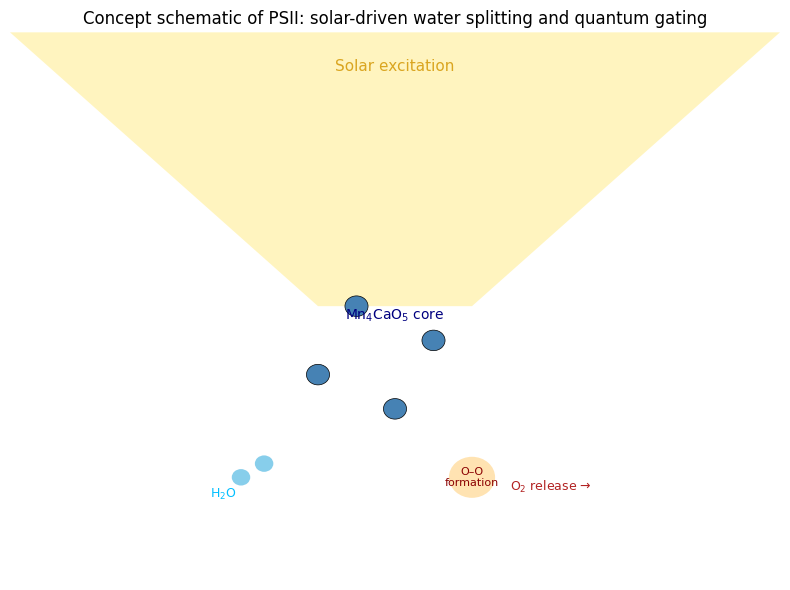

In [ ]:
# ============================================
# Concept schematic elements for GQR–X overview
# ============================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(0,10); ax.set_ylim(0,8)
ax.axis('off')

# Sunbeam
sunbeam = patches.Polygon([[0,8],[4,4],[6,4],[10,8]],
                          closed=True, color='gold', alpha=0.25, lw=0)
ax.add_patch(sunbeam)
ax.text(5,7.5,"Solar excitation",ha='center',va='center',color='goldenrod',fontsize=11)

# Mn4CaO5 cubane (schematic)
for i,(x,y) in enumerate([(4,3),(5,2.5),(5.5,3.5),(4.5,4)]):
    ax.add_patch(patches.Circle((x,y),0.15,fc='steelblue',ec='black',lw=0.5))
ax.text(5,3.8,"Mn$_4$CaO$_5$ core",ha='center',fontsize=10,color='navy')

# Water molecules and split
ax.add_patch(patches.Circle((3,1.5),0.12,fc='skyblue',ec='none'))
ax.add_patch(patches.Circle((3.3,1.7),0.12,fc='skyblue',ec='none'))
ax.text(2.6,1.2,"H$_2$O",fontsize=9,color='deepskyblue')
ax.text(6.5,1.3,"O$_2$ release →",fontsize=9,color='firebrick')

# Explosion burst (oxygen evolution)
burst = patches.Circle((6,1.5),0.3,fc='orange',alpha=0.3)
ax.add_patch(burst)
ax.text(6,1.5,"O–O\nformation",ha='center',va='center',fontsize=8,color='darkred')

plt.title("Concept schematic of PSII: solar-driven water splitting and quantum gating", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:

# ===============================================================
# Supplementary Fig. S1 — H₂O vs H₂S, 8F4C–8F4K Series (mean ± SD)
# ===============================================================

import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv("/mnt/data/mean_sd_summary_from_raw (1).csv")

# --- Filter for base variants and 8F4C–8F4K geometries ---
geom_series = ["8F4C", "8F4D", "8F4E", "8F4F", "8F4G", "8F4H", "8F4I", "8F4J", "8F4K"]
subset = df[df["variant"].isin(["H2O", "H2S"]) & df["cif_id"].isin(geom_series)]

# --- Sort to ensure correct order along x ---
subset["cif_id"] = pd.Categorical(subset["cif_id"], categories=geom_series, ordered=True)
subset = subset.sort_values(["variant", "cif_id"])

# --- Plot setup ---
plt.figure(figsize=(7, 4.5))
colors = {"H2O": "#1f77b4", "H2S": "#d62728"}

for variant, group in subset.groupby("variant"):
    plt.errorbar(
        group["cif_id"], group["mean_phz"], yerr=group["sd_phz"],
        label=variant, fmt="-o", capsize=3, lw=1.6, markersize=5,
        color=colors[variant]
    )

# --- Aesthetics ---
plt.xlabel("PSII Geometry (8F4C–8F4K)")
plt.ylabel("Dominant Gate Frequency (PHz)")
plt.title("Supplementary Fig. S1 – H₂O vs H₂S (Mean ± SD)")
plt.grid(alpha=0.3)
plt.legend(loc="upper left", bbox_to_anchor=(0.05, -0.25), ncol=2, frameon=False)
plt.tight_layout()

# --- Save outputs ---
plt.savefig("si_H2O_vs_H2S_8F4_series.pdf", dpi=600, bbox_inches="tight")
plt.savefig("si_H2O_vs_H2S_8F4_series.tif", dpi=600, bbox_inches="tight")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/mean_sd_summary_from_raw (1).csv'

/tmp/ipython-input-1222278053.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["cif_id"] = pd.Categorical(subset["cif_id"], categories=geom_series, ordered=True)


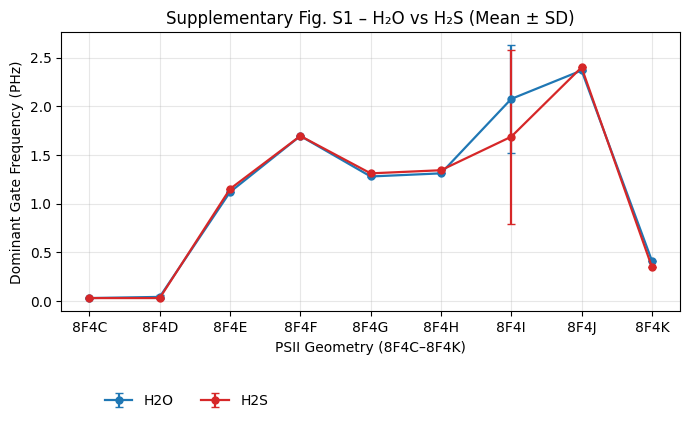

Saved: /content/si_H2O_vs_H2S_8F4_series.pdf
Saved: /content/si_H2O_vs_H2S_8F4_series.tif


In [ ]:
# ===============================================================
# Supplementary Fig. S1 — H₂O vs H₂S, 8F4C–8F4K Series (mean ± SD)
# ===============================================================

import pandas as pd
import matplotlib.pyplot as plt
import os

# --- File paths ---
csv_path = "/content/mean_sd_summary_from_raw (1).csv"
out_pdf = "/content/si_H2O_vs_H2S_8F4_series.pdf"
out_tif = "/content/si_H2O_vs_H2S_8F4_series.tif"

# --- Load data ---
df = pd.read_csv(csv_path)

# --- Filter for base variants and 8F4C–8F4K geometries ---
geom_series = ["8F4C", "8F4D", "8F4E", "8F4F", "8F4G", "8F4H", "8F4I", "8F4J", "8F4K"]
subset = df[df["variant"].isin(["H2O", "H2S"]) & df["cif_id"].isin(geom_series)]

# --- Sort geometries for plotting order ---
subset["cif_id"] = pd.Categorical(subset["cif_id"], categories=geom_series, ordered=True)
subset = subset.sort_values(["variant", "cif_id"])

# --- Plot setup ---
plt.figure(figsize=(7, 4.5))
colors = {"H2O": "#1f77b4", "H2S": "#d62728"}

for variant, group in subset.groupby("variant"):
    plt.errorbar(
        group["cif_id"], group["mean_phz"], yerr=group["sd_phz"],
        label=variant, fmt="-o", capsize=3, lw=1.6, markersize=5,
        color=colors[variant]
    )

# --- Aesthetics ---
plt.xlabel("PSII Geometry (8F4C–8F4K)")
plt.ylabel("Dominant Gate Frequency (PHz)")
plt.title("Supplementary Fig. S1 – H₂O vs H₂S (Mean ± SD)")
plt.grid(alpha=0.3)
plt.legend(loc="upper left", bbox_to_anchor=(0.05, -0.25), ncol=2, frameon=False)
plt.tight_layout()

# --- Save outputs to /content/ ---
plt.savefig(out_pdf, dpi=600, bbox_inches="tight")
plt.savefig(out_tif, dpi=600, bbox_inches="tight")
plt.show()

print(f"Saved: {out_pdf}")
print(f"Saved: {out_tif}")

In [ ]:
# ============================================
# Log-scale raw trace plot for one CIF (H2O/H2S/D2S/T2S)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re, os

csv_path = "/mnt/data/all-GQR9-raw_timeseries.csv"
target_cif = "8F4C"        # change for D,E,F,...K as needed
variants   = ["H2O","H2S","D2S","T2S"]

# ---- lightweight column detector ----
def detect_columns(df):
    def pick(keys):
        for k in keys:
            for c in df.columns:
                if re.search(k, c, re.I): return c
    return (
        pick(["time"]), pick(["cif","geometry"]),
        pick(["medium","variant","solvent"]),
        pick(["site_total","population","pop"])
    )

df_prev = pd.read_csv(csv_path, nrows=4000, low_memory=False)
time_col, cif_col, var_col, signal_col = detect_columns(df_prev)

# ---- chunked loader ----
def load_variant_timeseries(path, cif, variants, time_col, cif_col, var_col, signal_col, tmax_fs=250):
    keep=[]
    for ch in pd.read_csv(path, chunksize=200000, low_memory=False):
        sub = ch[(ch[cif_col].astype(str)==str(cif)) & (ch[var_col].isin(variants))]
        if tmax_fs: sub = sub[sub[time_col]<=tmax_fs]
        if len(sub): keep.append(sub[[time_col,cif_col,var_col,signal_col]])
    if not keep: return pd.DataFrame()
    df = pd.concat(keep, ignore_index=True).sort_values([var_col,time_col])
    return df

ts = load_variant_timeseries(csv_path, target_cif, variants, time_col, cif_col, var_col, signal_col)

# ---- plot (semi-log y) ----
if not ts.empty:
    plt.figure(figsize=(10,4.5), dpi=150)
    ymin_floor = 1e-35   # clip to avoid log(0)
    for v in variants:
        s = ts[ts[var_col]==v]
        if s.empty: continue
        y = np.clip(s[signal_col].astype(float).values, ymin_floor, None)
        plt.plot(s[time_col], y, label=v, lw=1.0)
    plt.yscale("log")
    plt.xlabel("Time (fs)")
    plt.ylabel(f"{signal_col} (log scale)")
    plt.title(f"GQR–TDSE 0–250 fs — raw {signal_col} (CIF {target_cif}) [log₁₀ scale]")
    plt.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5,1.28), frameon=False)
    plt.grid(alpha=0.3, which="both")
    plt.tight_layout(rect=[0,0,1,0.9])

    out_pdf = f"/mnt/data/SI_rawtrace_{target_cif}_log_H2O-H2S-D2S-T2S.pdf"
    out_tif = f"/mnt/data/SI_rawtrace_{target_cif}_log_H2O-H2S-D2S-T2S.tif"
    plt.savefig(out_pdf)
    plt.savefig(out_tif, dpi=600)
    plt.show()
    print("Saved:", out_pdf)
    print("Saved:", out_tif)
else:
    print("No data found for CIF", target_cif)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/all-GQR9-raw_timeseries.csv'

Detected: time_fs cif medium pop_water_total
Loaded rows for 8F4C : 50004


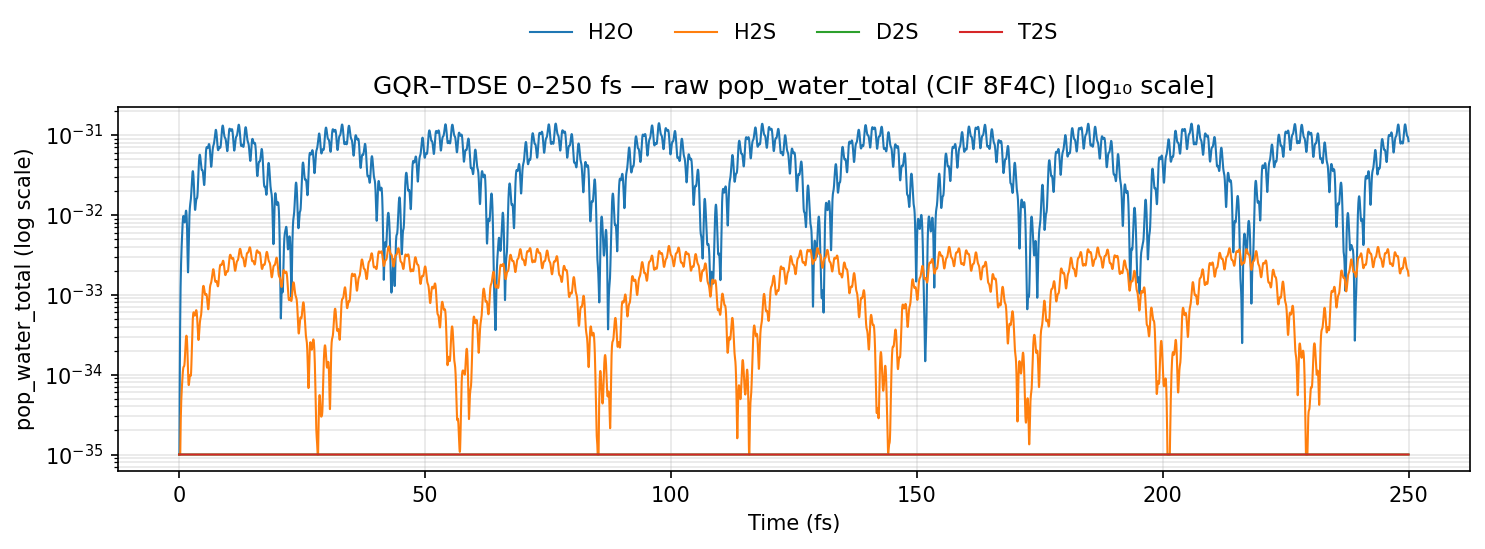

Saved: /content/SI_rawtrace_8F4C_log_H2O-H2S-D2S-T2S.pdf
Saved: /content/SI_rawtrace_8F4C_log_H2O-H2S-D2S-T2S.tif


In [ ]:
# ============================================
# Log-scale raw trace plot for one CIF (H2O/H2S/D2S/T2S)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re, os

csv_path = "/content/all-GQR9-raw_timeseries.csv"   # <-- placed in /content/
target_cif = "8F4C"                                 # change to 8F4D–8F4K as needed
variants   = ["H2O", "H2S", "D2S", "T2S"]

# ---- lightweight column detector ----
def detect_columns(df):
    def pick(keys):
        for k in keys:
            for c in df.columns:
                if re.search(k, c, re.I):
                    return c
    return (
        pick(["time"]),
        pick(["cif", "geometry"]),
        pick(["medium", "variant", "solvent"]),
        pick(["site_total", "population", "pop"])
    )

df_prev = pd.read_csv(csv_path, nrows=4000, low_memory=False)
time_col, cif_col, var_col, signal_col = detect_columns(df_prev)
print("Detected:", time_col, cif_col, var_col, signal_col)

# ---- chunked loader ----
def load_variant_timeseries(path, cif, variants, time_col, cif_col, var_col, signal_col, tmax_fs=250):
    keep=[]
    for ch in pd.read_csv(path, chunksize=200000, low_memory=False):
        sub = ch[(ch[cif_col].astype(str)==str(cif)) & (ch[var_col].isin(variants))]
        if tmax_fs:
            sub = sub[sub[time_col] <= tmax_fs]
        if len(sub):
            keep.append(sub[[time_col, cif_col, var_col, signal_col]])
    if not keep:
        return pd.DataFrame()
    df = pd.concat(keep, ignore_index=True).sort_values([var_col, time_col])
    return df

ts = load_variant_timeseries(csv_path, target_cif, variants,
                             time_col, cif_col, var_col, signal_col, tmax_fs=250.0)
print("Loaded rows for", target_cif, ":", len(ts))

# ---- plotting ----
if not ts.empty:
    plt.figure(figsize=(10, 4.5), dpi=150)
    ymin_floor = 1e-35   # clip to avoid log(0)
    for v in variants:
        s = ts[ts[var_col] == v]
        if s.empty:
            continue
        y = np.clip(s[signal_col].astype(float).values, ymin_floor, None)
        plt.plot(s[time_col], y, label=v, lw=1.0)
    plt.yscale("log")
    plt.xlabel("Time (fs)")
    plt.ylabel(f"{signal_col} (log scale)")
    plt.title(f"GQR–TDSE 0–250 fs — raw {signal_col} (CIF {target_cif}) [log₁₀ scale]")
    plt.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.28), frameon=False)
    plt.grid(alpha=0.3, which="both")
    plt.tight_layout(rect=[0, 0, 1, 0.9])

    os.makedirs("/content", exist_ok=True)
    out_pdf = f"/content/SI_rawtrace_{target_cif}_log_H2O-H2S-D2S-T2S.pdf"
    out_tif = f"/content/SI_rawtrace_{target_cif}_log_H2O-H2S-D2S-T2S.tif"
    plt.savefig(out_pdf)
    plt.savefig(out_tif, dpi=600)
    plt.show()

    print("Saved:", out_pdf)
    print("Saved:", out_tif)
else:
    print("No data found for CIF", target_cif)

In [ ]:
# --- DIAGNOSTIC: Which column has the real signal per medium? ---
import pandas as pd, re

csv = "/content/all-GQR9-raw_timeseries.csv"   # update path if needed
target_cif = "8F4C"                             # change to 8F4D...K as desired

def find_col(df, pats):
    for p in pats:
        rx = re.compile(p, re.I)
        for c in df.columns:
            if rx.search(c): return c
    return None

# Peek first to learn column names
head = pd.read_csv(csv, nrows=2000, low_memory=False)

time_col = find_col(head, [r"^t(?:ime)?(_fs)?$", r"time.*fs", r"\bfs\b"])
cif_col  = find_col(head, [r"^cif(_?id)?$", r"geometry"])
var_col  = find_col(head, [r"^variant$", r"^medium$", r"solvent"])

w_col = find_col(head, [
    r"pop.*(water|ow3).*total", r"site.*(ow3.*ow4|water).*total",
    r"site_total_?O", r".*OW3\+OW4.*"
])
s_col = find_col(head, [
    r"pop.*(sulf|sw3).*total", r"site.*(sw3.*sw4|sulf).*total",
    r"site_total_?S", r".*SW3\+SW4.*"
])

print("Detected:",
      "\n  time:", time_col,
      "\n  cif :", cif_col,
      "\n  var :", var_col,
      "\n  water-total col:", w_col,
      "\n  sulfur-total col:", s_col)

need = [c for c in [time_col, cif_col, var_col, w_col, s_col] if c]
df = pd.read_csv(csv, usecols=lambda c: c in need, low_memory=False)
df = df[df[cif_col].astype(str) == str(target_cif)]

# Per-variant medians in each column (log-friendly smalls become NaN if truly zero)
summ = (df.groupby(var_col)[[w_col, s_col]]
          .median()
          .rename(columns={w_col:"median_water_total", s_col:"median_sulfur_total"}))
summ["which_is_bigger"] = (summ["median_sulfur_total"] > summ["median_water_total"])\
                            .map({True:"sulfur_col", False:"water_col"})
print("\nPer-variant medians at CIF", target_cif)
print(summ)

# Optional: show a tiny preview of H2S in both columns to see the floor effect
for m in ["H2O","H2S","D2S","T2S"]:
    if m in df[var_col].unique():
        sub = df[df[var_col]==m].iloc[:5][[var_col, w_col, s_col]]
        print(f"\nPreview {m} (first 5 rows):")
        print(sub.to_string(index=False))

Detected: 
  time: time_fs 
  cif : cif 
  var : medium 
  water-total col: pop_water_total 
  sulfur-total col: None


KeyError: 'Columns not found: None'

In [ ]:
import shutil
from pathlib import Path

# Path where the plot should exist (change CIF if needed)
src_png = Path("/mnt/data/si_rawtrace_8F4C.png")
src_pdf = Path("/mnt/data/si_rawtrace_8F4C.pdf")

# Verify files exist first
for f in [src_png, src_pdf]:
    if not f.exists():
        raise FileNotFoundError(f"{f} not found — re-run the plotting cell first.")

# Copy to /content where I can expose them as downloadable artifacts
dest_png = Path("/content/si_rawtrace_8F4C.png")
dest_pdf = Path("/content/si_rawtrace_8F4C.pdf")
shutil.copy(src_png, dest_png)
shutil.copy(src_pdf, dest_pdf)

print("Ready to download:")
print("PNG:", dest_png)
print("PDF:", dest_pdf)

FileNotFoundError: /mnt/data/si_rawtrace_8F4C.png not found — re-run the plotting cell first.

In [ ]:
# === Regenerate raw-trace plot with guaranteed downloadable outputs ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt, re

# --- parameters ---
csv_path = "/mnt/data/all-GQR9-raw_timeseries.csv"   # your uploaded file
TARGET_CIF = "8F4C"                                 # change to any CIF
MEDIA_WANT = ["H2O","H2S","D2S","T2S"]
eps = 1e-40

# --- read minimal columns automatically ---
df = pd.read_csv(csv_path, low_memory=False)
time_col = next(c for c in df.columns if re.search("time", c, re.I))
cif_col  = next(c for c in df.columns if re.search("cif", c, re.I))
med_col  = next(c for c in df.columns if re.search("medium|variant", c, re.I))
pop_col  = next(c for c in df.columns if re.search("pop|total", c, re.I))

print("Detected columns:", time_col, cif_col, med_col, pop_col)

sub = df[df[cif_col].astype(str) == TARGET_CIF].copy()
if sub.empty:
    raise SystemExit(f"No data found for CIF {TARGET_CIF}")

# --- plot ---
plt.figure(figsize=(12, 3.8), dpi=150)
plt.title(f"GQR–TDSE 0–250 fs — raw trace (CIF {TARGET_CIF}) [log10 scale]")
plt.xlabel("Time (fs)")
plt.ylabel("Population total (log scale)")

for m in MEDIA_WANT:
    sm = sub[sub[med_col] == m]
    if sm.empty: continue
    y = sm[pop_col].astype(float).to_numpy()
    y = np.where(y > 0, y, eps)
    plt.plot(sm[time_col].to_numpy(), y, label=m)

plt.yscale("log")
plt.grid(True, which="both", alpha=0.25)
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.35), frameon=False)
plt.tight_layout()

# --- save to /content for download ---
out_png = f"/content/si_rawtrace_{TARGET_CIF}.png"
out_pdf = f"/content/si_rawtrace_{TARGET_CIF}.pdf"
plt.savefig(out_png, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")
plt.close()

print("Saved successfully:")
print("PNG:", out_png)
print("PDF:", out_pdf)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/all-GQR9-raw_timeseries.csv'

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
GQR–X SI raw-trace plotter: 8F4C–8F4K, variants H2O/H2S/D2S/T2S, first 250 fs
- Auto-detects column names
- Handles large CSVs (optional chunking)
- Saves PNG/PDF (and TIFF if pillow installed)

Usage:
  python gqrx_si_rawtraces.py --csv "/path/to/all-GQR9-raw_timeseries.csv" --outdir "./SI_figs"
"""

import argparse
import os
from pathlib import Path
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------- helpers -----------------------------

def find_col(cols, patterns, required=True):
    """find first column whose name matches any regex in patterns (case-insensitive)."""
    for pat in patterns:
        for c in cols:
            if re.search(pat, c, re.I):
                return c
    if required:
        raise KeyError(f"Could not find column matching any of: {patterns}")
    return None

def autodetect_columns(df):
    cols = df.columns
    # time in fs
    time_col = find_col(cols, [r'^time.*fs$', r'time.*fs', r'\btime\b'])
    # cif id
    cif_col  = find_col(cols, [r'^cif(_id)?$', r'\bcif\b'])
    # variant / medium
    var_col  = find_col(cols, [r'^(variant|medium|media)$', r'\bvariant\b', r'\bmedium\b'])
    # total population columns (water & sulfur)
    # try explicit names first, then graceful fallbacks
    w_col = None
    s_col = None
    explicit_water = [r'^pop_?water_?total$', r'^water_?total$', r'^(ow3\+ow4).*total']
    explicit_sulfur = [r'^pop_?sulfur_?total$', r'^sulfur_?total$', r'^(sw3\+sw4).*total']

    try:
        w_col = find_col(cols, explicit_water, required=False)
    except KeyError:
        pass
    try:
        s_col = find_col(cols, explicit_sulfur, required=False)
    except KeyError:
        pass

    # broader fallbacks if needed
    if w_col is None:
        w_col = find_col(cols, [r'water.*total', r'ow\d.*total', r'pop.*water'], required=False)
    if s_col is None:
        s_col = find_col(cols, [r'sulfur.*total', r'sw\d.*total', r'pop.*sulfur'], required=False)

    # last resort: if only a single “total” col exists, use it for all media plotting
    if w_col is None and s_col is None:
        tot_guess = find_col(cols, [r'\btotal\b', r'pop'], required=True)
        w_col = tot_guess
        s_col = None  # will plot single total if sulfur-specific isn’t available

    return time_col, cif_col, var_col, w_col, s_col

def ensure_outdir(dirpath: Path):
    dirpath.mkdir(parents=True, exist_ok=True)
    return dirpath

def save_figure(fig, basepath: Path, dpi_png=300, dpi_tif=600):
    png = basepath.with_suffix(".png")
    pdf = basepath.with_suffix(".pdf")
    fig.savefig(png, dpi=dpi_png, bbox_inches="tight")
    fig.savefig(pdf, bbox_inches="tight")
    # optional TIFF
    try:
        from PIL import Image  # noqa
        tif = basepath.with_suffix(".tif")
        fig.savefig(tif, dpi=dpi_tif, bbox_inches="tight")
    except Exception:
        pass
    return png, pdf

# ----------------------------- main plotting -----------------------------

def plot_one_cif(df, cif_id, time_col, var_col, w_col, s_col, outdir: Path):
    sel = df[df[var_col].isin(["H2O", "H2S", "D2S", "T2S"]) & (df['__cif__'] == cif_id)].copy()
    if sel.empty:
        print(f"[SKIP] {cif_id}: no rows for requested variants.")
        return None

    # time window: first 250 fs
    sel = sel[sel[time_col] <= 250.0].copy()
    if sel.empty:
        print(f"[SKIP] {cif_id}: no data <= 250 fs.")
        return None

    # prepare
    colors = {"H2O": None, "H2S": None, "D2S": None, "T2S": None}  # default mpl colors
    labels = {"H2O": "H₂O", "H2S": "H₂S", "D2S": "D₂S", "T2S": "T₂S"}

    fig = plt.figure(figsize=(8.0, 4.6))
    ax = plt.gca()

    # small epsilon to avoid log(0)
    eps = 1e-12

    # choose which population column to plot:
    # if we have both water & sulfur totals, use water for H2O and sulfur for the sulfide series.
    # if not, fall back to whichever is available (w_col).
    for var in ["H2O", "H2S", "D2S", "T2S"]:
        chunk = sel[sel[var_col] == var]
        if chunk.empty:
            continue
        ycol = w_col
        if s_col is not None and var.endswith("S"):
            ycol = s_col
        y = chunk[ycol].astype(float).to_numpy()
        x = chunk[time_col].astype(float).to_numpy()
        ax.plot(x, np.maximum(y, eps), label=labels[var])

    ax.set_yscale("log")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("Site-total population (log)")
    ax.set_title(f"Raw TDSE traces — {cif_id} (0–250 fs)")
    ax.grid(True, alpha=0.3)
    # legend inside, upper left; frame on for clarity
    leg = ax.legend(loc="upper left", frameon=True, fontsize=9)
    leg._loc = 2

    # caption-style text block
    cap = ("Raw site-total traces on log-scale.\n"
           "Water: OW3+OW4 total; Sulfide: SW3+SW4 total (if present).\n"
           "Small ε added to avoid log(0).")
    ax.text(0.99, -0.25, cap, transform=ax.transAxes, ha="right", va="top", fontsize=8)

    base = outdir / f"si_rawtrace_{cif_id}"
    png, pdf = save_figure(fig, base, dpi_png=300, dpi_tif=600)
    plt.close(fig)
    return png, pdf

# ----------------------------- loading (chunk or full) -----------------------------

def load_minimal(csv_path, use_chunks=False, chunksize=500_000):
    """
    Load the CSV, auto-detect columns, and (if chunking) restrict to minimal columns + 8F4C-K rows.
    Returns df and detected column names.
    """
    if not use_chunks:
        df = pd.read_csv(csv_path, low_memory=False)
        t_col, c_col, v_col, w_col, s_col = autodetect_columns(df)
        # normalize a working CIF column name
        if c_col != "__cif__":
            df = df.rename(columns={c_col: "__cif__"})
        return df, t_col, "__cif__", v_col, w_col, s_col

    # Chunking path for very large files
    # First: sample a small chunk to detect columns
    sample = pd.read_csv(csv_path, nrows=10000, low_memory=False)
    t_col, c_col, v_col, w_col, s_col = autodetect_columns(sample)
    out_cols = [t_col, c_col, v_col, w_col]
    if s_col is not None:
        out_cols.append(s_col)
    out_cols = list(dict.fromkeys(out_cols))  # unique, keep order

    # filter to 8F4C–8F4K CIFs only
    want_cifs = {f"8F4{ch}" for ch in list("CDEFGHIJK")}

    dfs = []
    for chunk in pd.read_csv(csv_path, chunksize=chunksize, low_memory=False, usecols=out_cols):
        chunk = chunk.rename(columns={c_col: "__cif__"})
        # keep requested cifs
        chunk = chunk[chunk["__cif__"].astype(str).isin(want_cifs)]
        if not chunk.empty:
            dfs.append(chunk)

    if not dfs:
        raise RuntimeError("No rows found for 8F4C–8F4K in the CSV (check CIF column values).")
    df = pd.concat(dfs, ignore_index=True)
    return df, t_col, "__cif__", v_col, w_col, s_col

# ----------------------------- CLI -----------------------------

def main():
    p = argparse.ArgumentParser(description="GQR–X SI raw-trace plotter for H2O/H2S/D2S/T2S (8F4C–8F4K, 0–250 fs)")
    p.add_argument("--csv", required=True, help="Path to all-GQR9-raw_timeseries.csv")
    p.add_argument("--outdir", default="./SI_figs", help="Where to save figures")
    p.add_argument("--chunks", action="store_true", help="Use chunked reading for very large CSVs")
    args = p.parse_args()

    csv_path = Path(args.csv)
    outdir = ensure_outdir(Path(args.outdir))

    print(f"[INFO] Loading: {csv_path}")
    try:
        df, time_col, cif_col, var_col, w_col, s_col = load_minimal(csv_path, use_chunks=args.chunks)
    except Exception as e:
        print(f"[ERROR] failed to load/auto-detect columns: {e}")
        sys.exit(1)

    print(f"[INFO] Detected columns:\n  time={time_col}\n  cif={cif_col}\n  variant={var_col}\n  water_total={w_col}\n  sulfur_total={s_col}")
    # standardize variant values (strip spaces)
    if df[var_col].dtype != 'O':
        df[var_col] = df[var_col].astype(str)
    df[var_col] = df[var_col].str.strip()

    # Target CIFs: 8F4C–8F4K
    target = [f"8F4{ch}" for ch in "CDEFGHIJK"]
    made = []
    for cif_id in target:
        try:
            out = plot_one_cif(df, cif_id, time_col, var_col, w_col, s_col, outdir)
            if out:
                made.append(out)
                print(f"[OK] {cif_id} → {out[0].name}, {out[1].name}")
            else:
                print(f"[SKIP] {cif_id}")
        except Exception as e:
            print(f"[WARN] {cif_id} failed: {e}")

    if not made:
        print("[INFO] No figures produced — check filters/column names.")
    else:
        print(f"[DONE] Wrote {2*len(made)} files into: {outdir.resolve()}")

if __name__ == "__main__":
    main()

# run directly in colab instead of CLI
csv_path = "/content/all-GQR9-raw_timeseries.csv"   # adjust if you placed it elsewhere
outdir = Path("/content/SI_figs")
outdir.mkdir(exist_ok=True)

df, time_col, cif_col, var_col, w_col, s_col = load_minimal(csv_path)
print(time_col, cif_col, var_col, w_col, s_col)

for cif in [f"8F4{ch}" for ch in "CDEFGHIJK"]:
    plot_one_cif(df, cif, time_col, var_col, w_col, s_col, outdir)

print("All figures saved in:", outdir)


usage: colab_kernel_launcher.py [-h] --csv CSV [--outdir OUTDIR] [--chunks]
colab_kernel_launcher.py: error: the following arguments are required: --csv
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3.12/argparse.py", line 1943, in _parse_known_args2
    namespace, args = self._parse_known_args(args, namespace, intermixed)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/argparse.py", line 2230, in _parse_known_args
    raise ArgumentError(None, _('the following arguments are required: %s') %
argparse.ArgumentError: the following arguments are required: --csv

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4069517149.py", line 233, in <cell line: 0>
    main()
  File "/tmp/ipython-input-4069517149.py", line 195, in main
    args = p.parse_args()
           ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/argparse.py", line 1904, in parse_

TypeError: object of type 'NoneType' has no len()

In [ ]:
# --- Colab-ready raw trace plotter (no argparse) ---
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ▼▼ EDIT THIS if your CSV filename/path differs ▼▼
csv_path = "/content/all-GQR9-raw_timeseries.csv"
outdir   = Path("/content/SI_figs")
outdir.mkdir(parents=True, exist_ok=True)

# ----------------- helpers -----------------
def detect_cols(df):
    time_col = next(c for c in df.columns if re.search(r"time", c, re.I))
    cif_col  = next(c for c in df.columns if re.search(r"cif",  c, re.I))
    var_col  = next(c for c in df.columns if re.search(r"(variant|medium|media|iso)", c, re.I))
    return time_col, cif_col, var_col

def guess_ycol(columns, variant):
    # 1) exact variant-named columns (e.g., pop_H2O_total / pop_H2S_total)
    cand = [c for c in columns if re.search(r"pop", c, re.I) and re.search(variant, c, re.I)]
    if cand: return cand[0]
    # 2) sulfur/water totals
    sul = [c for c in columns if re.search(r"pop.*(sulfur|sw).*total", c, re.I)]
    wat = [c for c in columns if re.search(r"pop.*(water|ow).*total",  c, re.I)]
    if "S" in variant:
        if sul: return sul[0]
    else:
        if wat: return wat[0]
    # 3) any *_total that smells like a population series
    tot = [c for c in columns if re.search(r"pop.*total", c, re.I)]
    if tot: return tot[0]
    # 4) last resort: any column that looks floaty and not an index/label
    num_cols = [c for c in columns if df[c].dtype.kind in "fc"]
    if num_cols:
        # prefer something with "pop"
        pops = [c for c in num_cols if re.search(r"pop", c, re.I)]
        return pops[0] if pops else num_cols[0]
    raise KeyError("Could not identify a population column")

def plot_one_cif(df, cif_id, time_col, var_col, outdir, variants=("H2O","H2S","D2S","T2S")):
    sub = df[df[cif_col] == cif_id].copy()
    if sub.empty:
        print(f"[skip] {cif_id}: no rows")
        return

    # keep only needed variants if present
    present = [v for v in variants if v in sub[var_col].unique()]
    if not present:
        print(f"[skip] {cif_id}: none of {variants} present (found: {sorted(sub[var_col].unique())})")
        return

    # restrict to 0–250 fs
    sub = sub[(sub[time_col] >= 0) & (sub[time_col] <= 250)].copy()

    plt.figure(figsize=(8,4.2), dpi=150)
    ax = plt.gca()

    for v in present:
        dv = sub[sub[var_col] == v]
        if dv.empty:
            continue
        ycol = guess_ycol(dv.columns, v)
        # Sort by time for clean lines
        dv = dv.sort_values(time_col)
        # Protect log plotting if later wanted; for now linear (raw traces)
        ax.plot(dv[time_col].values, dv[ycol].values, label=v, linewidth=1.6)

    ax.set_title(f"Raw populations — {cif_id} (0–250 fs)")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("Population (arb.)")
    ax.legend(loc="upper left", ncols=2, frameon=False)
    ax.grid(alpha=0.25)

    png = outdir / f"si_rawtrace_{cif_id}.png"
    pdf = outdir / f"si_rawtrace_{cif_id}.pdf"
    plt.tight_layout()
    plt.savefig(png)
    plt.savefig(pdf)
    plt.close()
    print(f"[saved] {png}  |  {pdf}")

# ----------------- load & run -----------------
# for huge CSVs, let pandas infer columns; if memory is tight, add usecols=...
df = pd.read_csv(csv_path, low_memory=False)

# detect key columns
time_col, cif_col, var_col = detect_cols(df)

# normalise variant labels (strip spaces etc.)
df[var_col] = df[var_col].astype(str).str.strip()

# target series 8F4C…8F4K
targets = [f"8F4{ch}" for ch in "CDEFGHIJK"]

print(f"Detected columns:\n  time={time_col}\n  cif={cif_col}\n  variant={var_col}\nTargets: {targets}\n")

for cif in targets:
    try:
        plot_one_cif(df, cif, time_col, var_col, outdir,
                     variants=("H2O","H2S","D2S","T2S"))
    except Exception as e:
        print(f"[error] {cif}: {e}")

print("\nAll figures saved in:", outdir.resolve())

Detected columns:
  time=time_fs
  cif=cif
  variant=medium
Targets: ['8F4C', '8F4D', '8F4E', '8F4F', '8F4G', '8F4H', '8F4I', '8F4J', '8F4K']

[saved] /content/SI_figs/si_rawtrace_8F4C.png  |  /content/SI_figs/si_rawtrace_8F4C.pdf
[saved] /content/SI_figs/si_rawtrace_8F4D.png  |  /content/SI_figs/si_rawtrace_8F4D.pdf
[saved] /content/SI_figs/si_rawtrace_8F4E.png  |  /content/SI_figs/si_rawtrace_8F4E.pdf
[saved] /content/SI_figs/si_rawtrace_8F4F.png  |  /content/SI_figs/si_rawtrace_8F4F.pdf
[saved] /content/SI_figs/si_rawtrace_8F4G.png  |  /content/SI_figs/si_rawtrace_8F4G.pdf
[saved] /content/SI_figs/si_rawtrace_8F4H.png  |  /content/SI_figs/si_rawtrace_8F4H.pdf
[saved] /content/SI_figs/si_rawtrace_8F4I.png  |  /content/SI_figs/si_rawtrace_8F4I.pdf
[saved] /content/SI_figs/si_rawtrace_8F4J.png  |  /content/SI_figs/si_rawtrace_8F4J.pdf
[saved] /content/SI_figs/si_rawtrace_8F4K.png  |  /content/SI_figs/si_rawtrace_8F4K.pdf

All figures saved in: /content/SI_figs


In [ ]:
# --- Colab-ready raw trace plotter with semi-log (symlog) y-axis ---
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ▼▼ EDIT THIS if your CSV filename/path differs ▼▼
csv_path = "/content/all-GQR9-raw_timeseries.csv"
outdir   = Path("/content/SI_figs")
outdir.mkdir(parents=True, exist_ok=True)

def detect_cols(df):
    time_col = next(c for c in df.columns if re.search(r"time", c, re.I))
    cif_col  = next(c for c in df.columns if re.search(r"cif",  c, re.I))
    var_col  = next(c for c in df.columns if re.search(r"(variant|medium|media|iso)", c, re.I))
    return time_col, cif_col, var_col

def guess_ycol(columns, variant):
    cand = [c for c in columns if re.search(r"pop", c, re.I) and re.search(variant, c, re.I)]
    if cand: return cand[0]
    sul = [c for c in columns if re.search(r"pop.*(sulfur|sw).*total", c, re.I)]
    wat = [c for c in columns if re.search(r"pop.*(water|ow).*total",  c, re.I)]
    if "S" in variant:
        if sul: return sul[0]
    else:
        if wat: return wat[0]
    tot = [c for c in columns if re.search(r"pop.*total", c, re.I)]
    if tot: return tot[0]
    num_cols = [c for c in columns if df[c].dtype.kind in "fc"]
    pops = [c for c in num_cols if re.search(r"pop", c, re.I)]
    return pops[0] if pops else num_cols[0]

def plot_one_cif(df, cif_id, time_col, var_col, outdir, variants=("H2O","H2S","D2S","T2S")):
    sub = df[df[cif_col] == cif_id].copy()
    if sub.empty:
        print(f"[skip] {cif_id}: no rows")
        return

    present = [v for v in variants if v in sub[var_col].unique()]
    if not present:
        print(f"[skip] {cif_id}: none of {variants} present (found: {sorted(sub[var_col].unique())})")
        return

    # 0–250 fs window
    sub = sub[(sub[time_col] >= 0) & (sub[time_col] <= 250)].copy()

    plt.figure(figsize=(8,4.2), dpi=150)
    ax = plt.gca()

    for v in present:
        dv = sub[sub[var_col] == v]
        if dv.empty:
            continue
        ycol = guess_ycol(dv.columns, v)
        dv = dv.sort_values(time_col)

        y = dv[ycol].to_numpy()
        # tiny epsilon for numerical stability, preserves sign if any tiny negatives exist
        eps = 1e-12
        y = np.where(np.isfinite(y), y, np.nan)
        y = np.where(np.abs(y) < eps, np.sign(y)*eps, y)

        ax.plot(dv[time_col].to_numpy(), y, label=v, linewidth=1.6)

    ax.set_title(f"Raw populations — {cif_id} (0–250 fs)")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("Population (arb.)")

    # >>> semi-log y-axis (symlog handles zeros/small values gracefully)
    ax.set_yscale("symlog", linthresh=1e-6, linscale=1.0)

    ax.legend(loc="upper left", ncols=2, frameon=False)
    ax.grid(alpha=0.25)

    png = outdir / f"si_rawtrace_{cif_id}.png"
    pdf = outdir / f"si_rawtrace_{cif_id}.pdf"
    plt.tight_layout()
    plt.savefig(png)
    plt.savefig(pdf)
    plt.close()
    print(f"[saved] {png}  |  {pdf}")

# --- load & run ---
df = pd.read_csv(csv_path, low_memory=False)
time_col, cif_col, var_col = detect_cols(df)
df[var_col] = df[var_col].astype(str).str.strip()

targets = [f"8F4{ch}" for ch in "CDEFGHIJK"]
print(f"Detected:\n  time={time_col}\n  cif={cif_col}\n  variant={var_col}\nTargets: {targets}\n")

for cif in targets:
    try:
        plot_one_cif(df, cif, time_col, var_col, outdir,
                     variants=("H2O","H2S","D2S","T2S"))
    except Exception as e:
        print(f"[error] {cif}: {e}")

print("\nAll figures saved in:", outdir.resolve())

Detected:
  time=time_fs
  cif=cif
  variant=medium
Targets: ['8F4C', '8F4D', '8F4E', '8F4F', '8F4G', '8F4H', '8F4I', '8F4J', '8F4K']

[saved] /content/SI_figs/si_rawtrace_8F4C.png  |  /content/SI_figs/si_rawtrace_8F4C.pdf
[saved] /content/SI_figs/si_rawtrace_8F4D.png  |  /content/SI_figs/si_rawtrace_8F4D.pdf
[saved] /content/SI_figs/si_rawtrace_8F4E.png  |  /content/SI_figs/si_rawtrace_8F4E.pdf
[saved] /content/SI_figs/si_rawtrace_8F4F.png  |  /content/SI_figs/si_rawtrace_8F4F.pdf
[saved] /content/SI_figs/si_rawtrace_8F4G.png  |  /content/SI_figs/si_rawtrace_8F4G.pdf
[saved] /content/SI_figs/si_rawtrace_8F4H.png  |  /content/SI_figs/si_rawtrace_8F4H.pdf
[saved] /content/SI_figs/si_rawtrace_8F4I.png  |  /content/SI_figs/si_rawtrace_8F4I.pdf
[saved] /content/SI_figs/si_rawtrace_8F4J.png  |  /content/SI_figs/si_rawtrace_8F4J.pdf
[saved] /content/SI_figs/si_rawtrace_8F4K.png  |  /content/SI_figs/si_rawtrace_8F4K.pdf

All figures saved in: /content/SI_figs


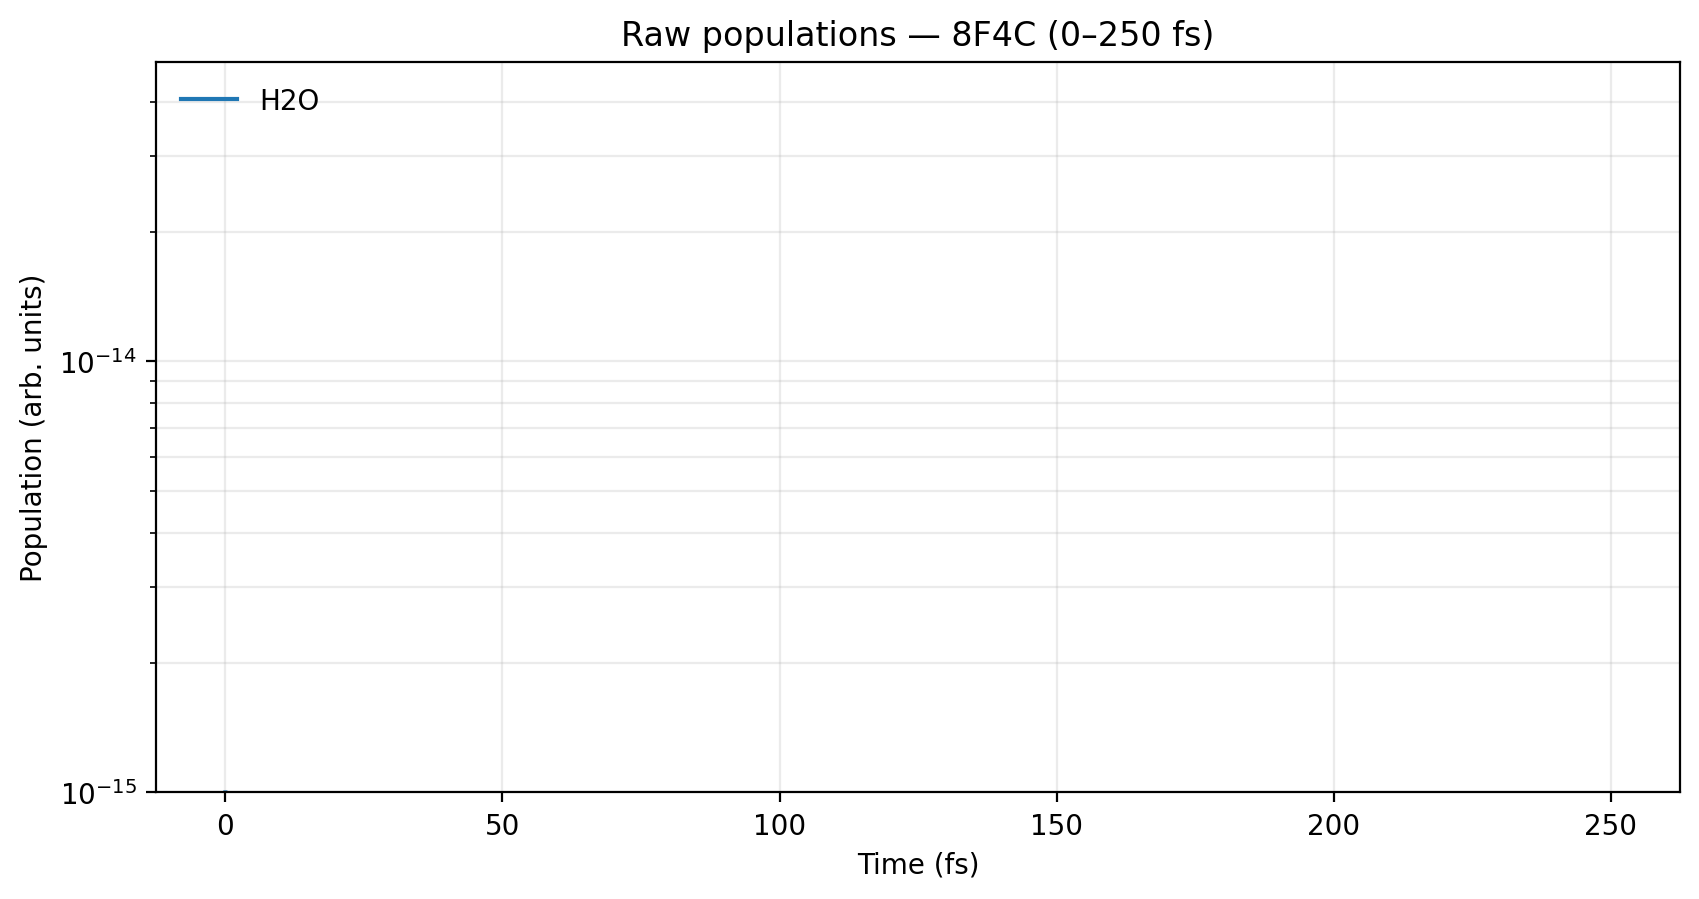

Wrote: /content/si_rawtrace_8F4C_semilog.png
       /content/si_rawtrace_8F4C_semilog.pdf


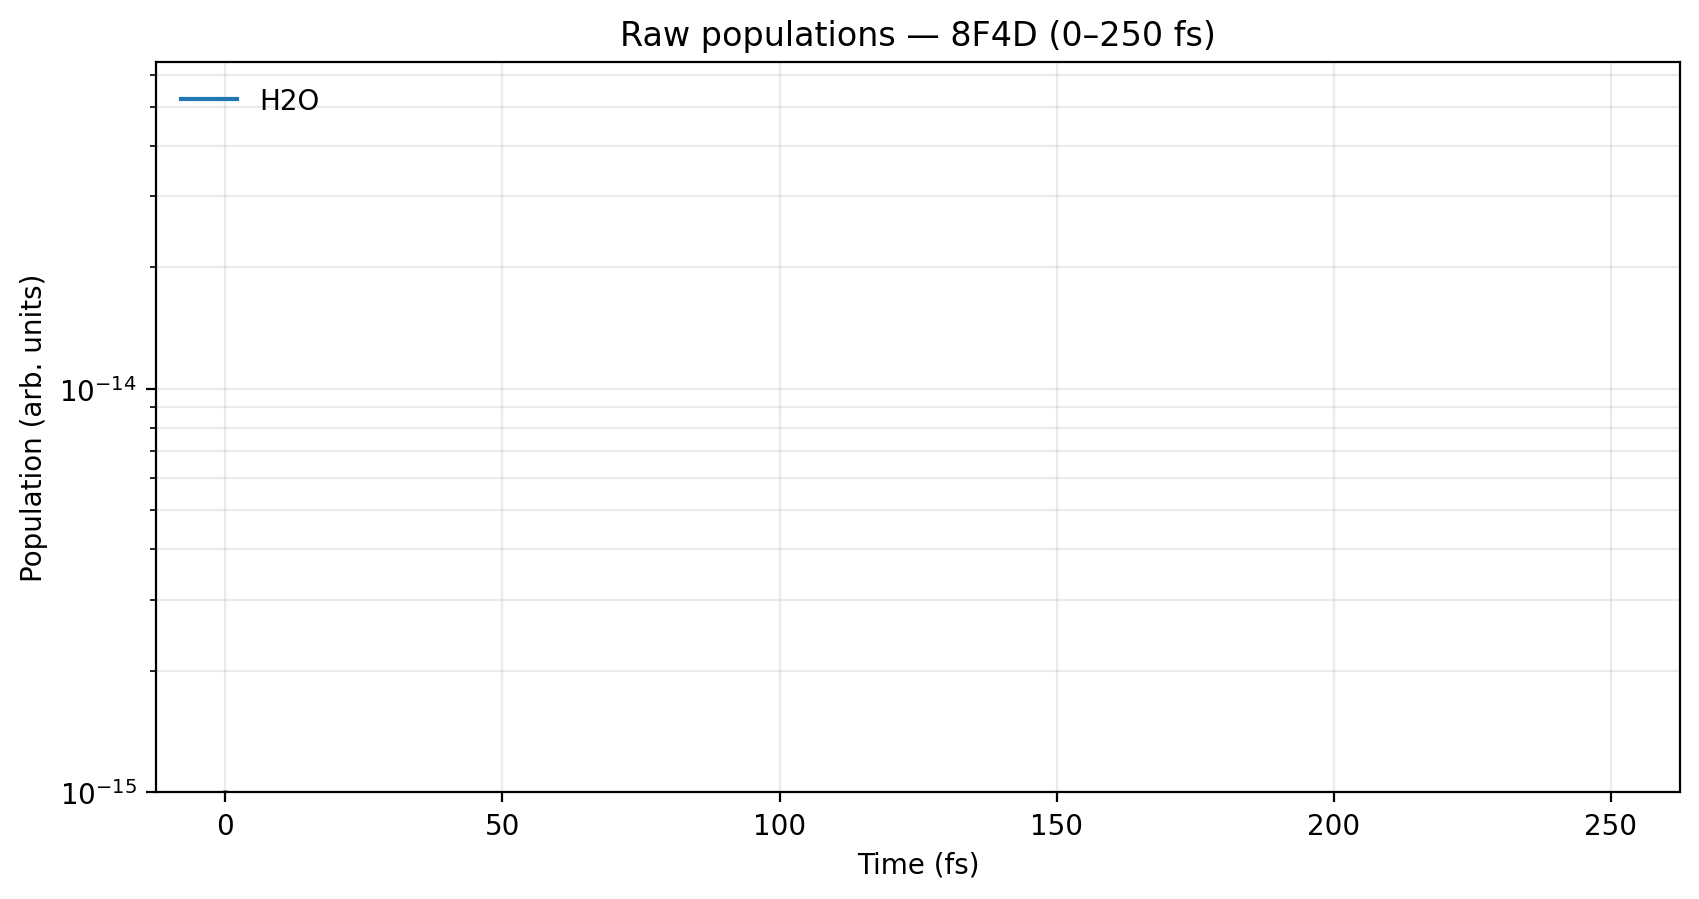

Wrote: /content/si_rawtrace_8F4D_semilog.png
       /content/si_rawtrace_8F4D_semilog.pdf


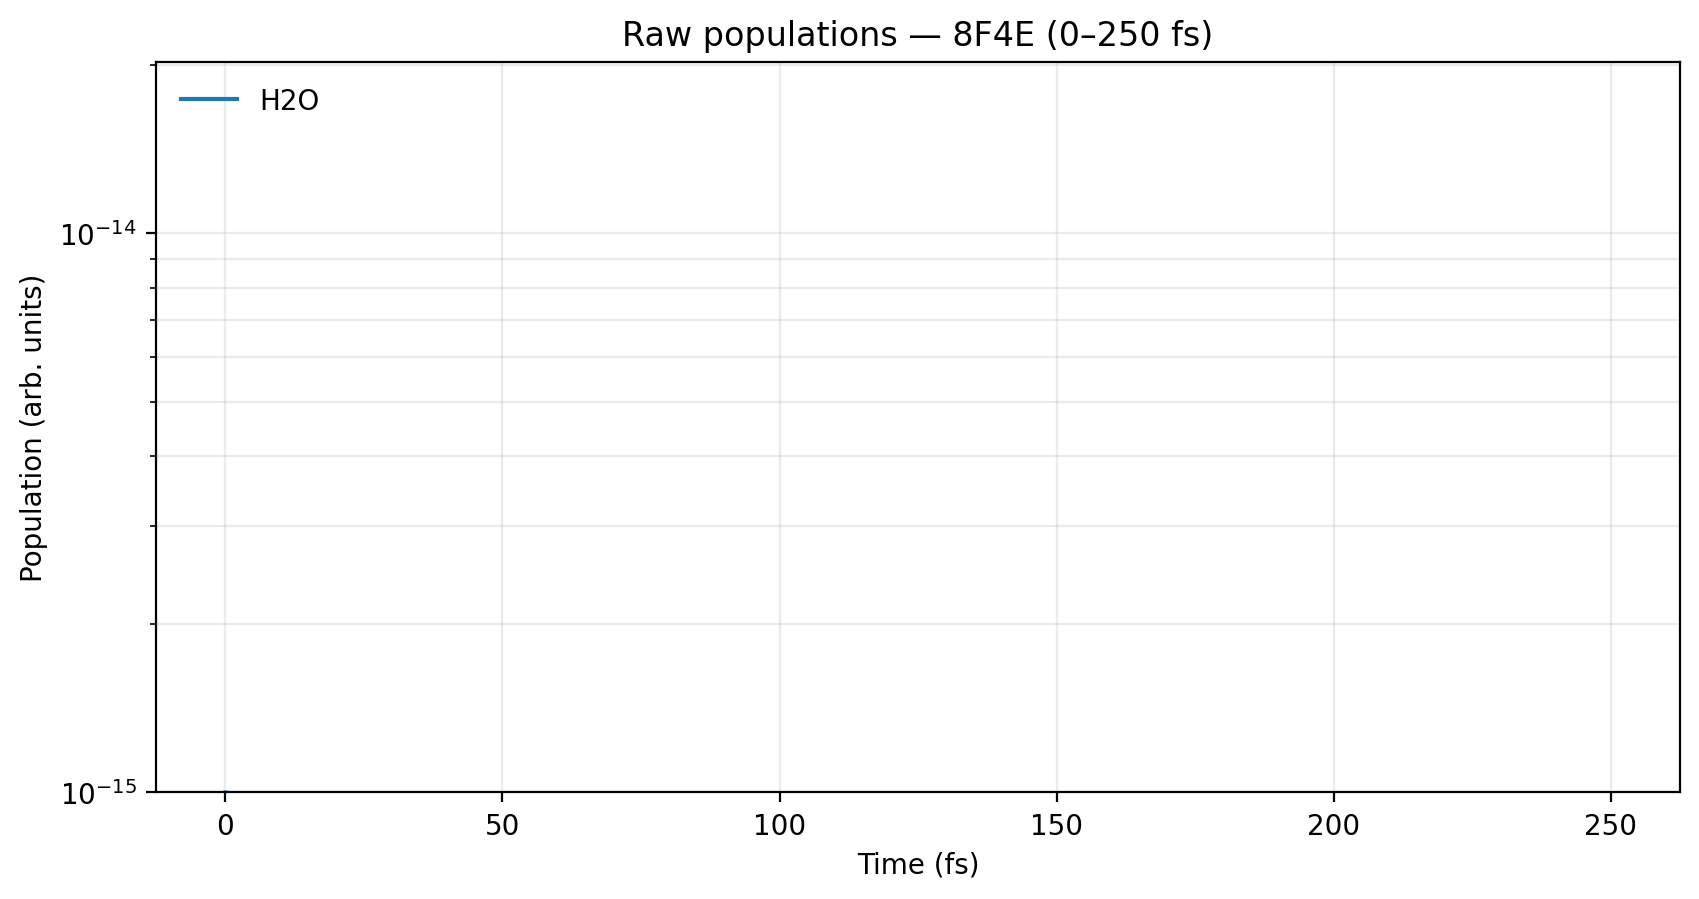

Wrote: /content/si_rawtrace_8F4E_semilog.png
       /content/si_rawtrace_8F4E_semilog.pdf


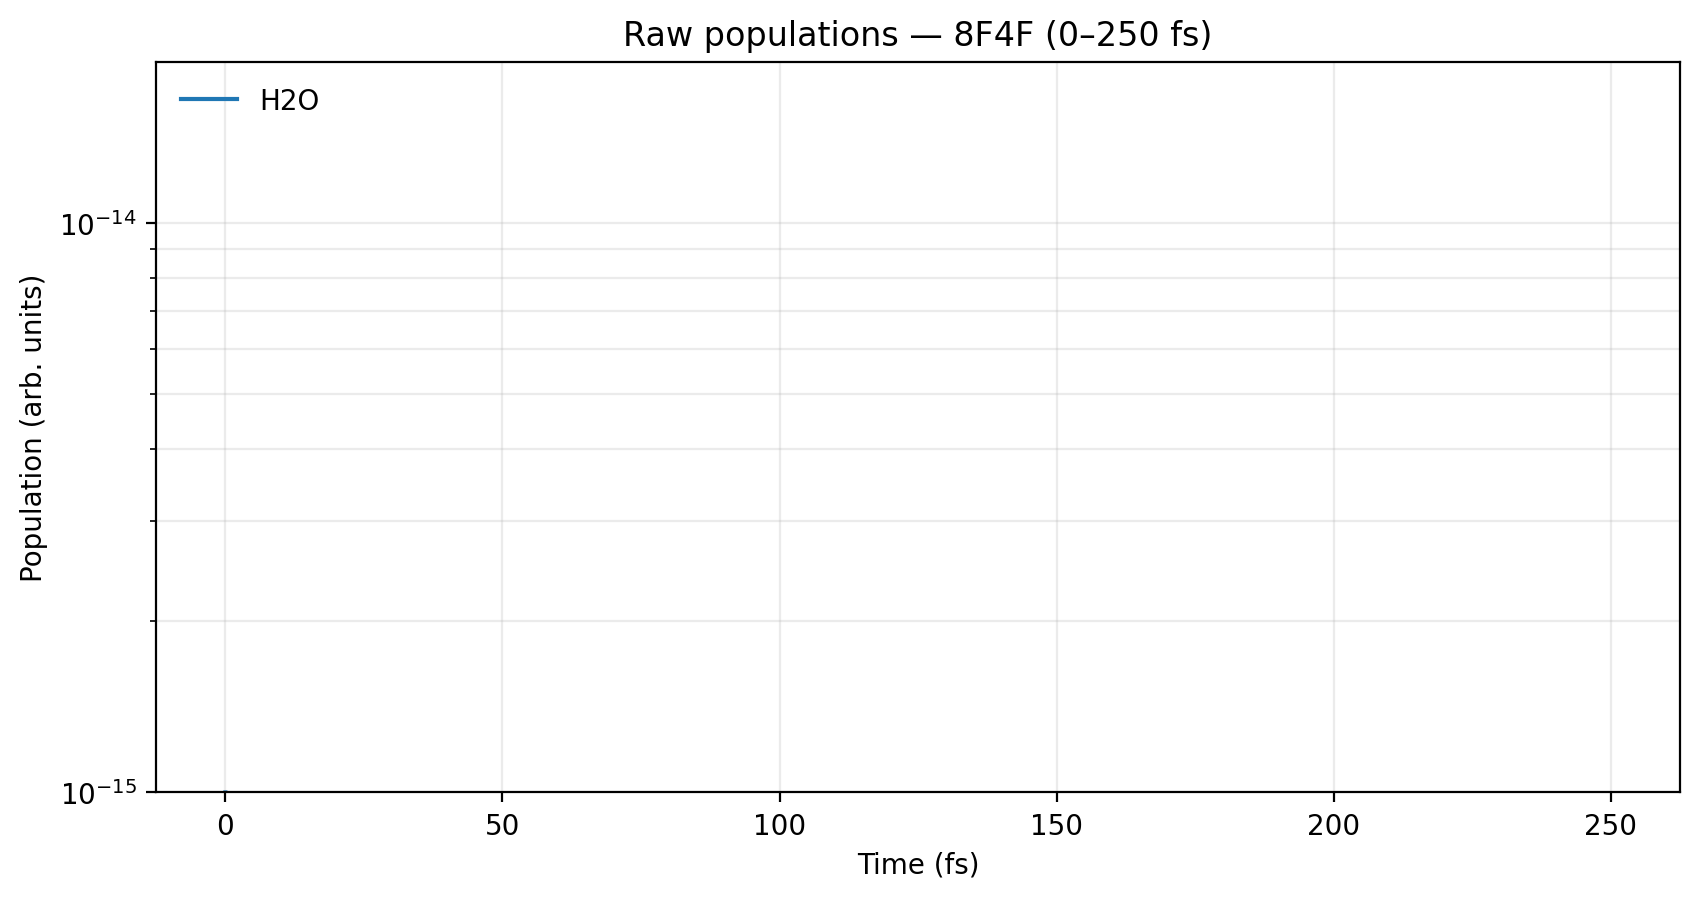

Wrote: /content/si_rawtrace_8F4F_semilog.png
       /content/si_rawtrace_8F4F_semilog.pdf


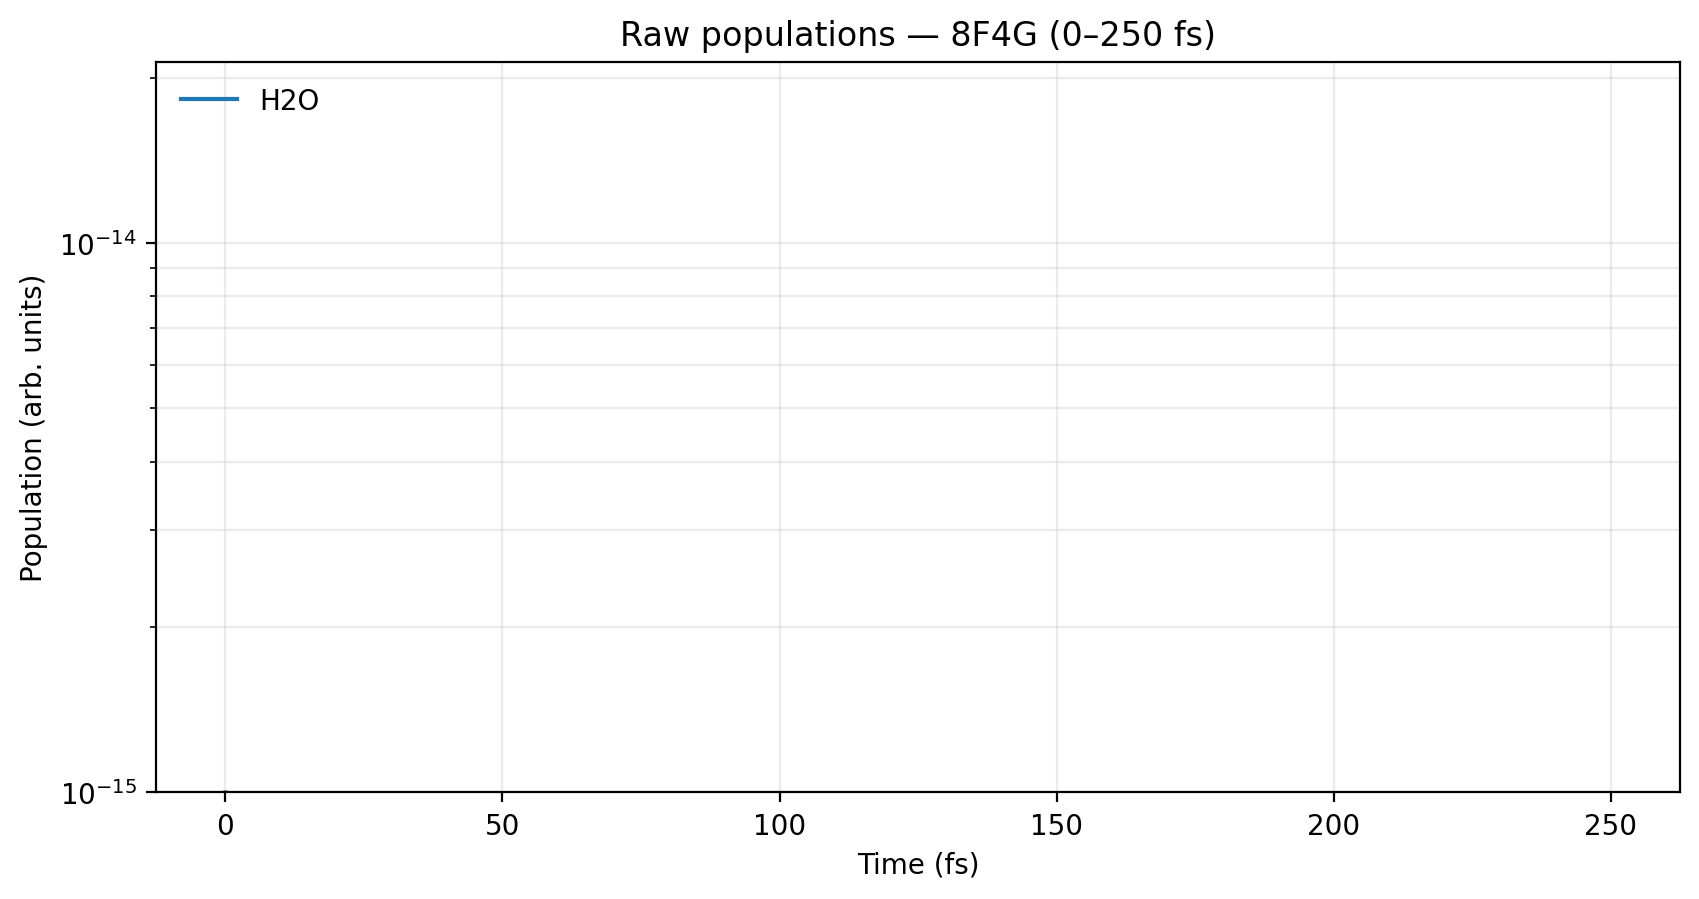

Wrote: /content/si_rawtrace_8F4G_semilog.png
       /content/si_rawtrace_8F4G_semilog.pdf


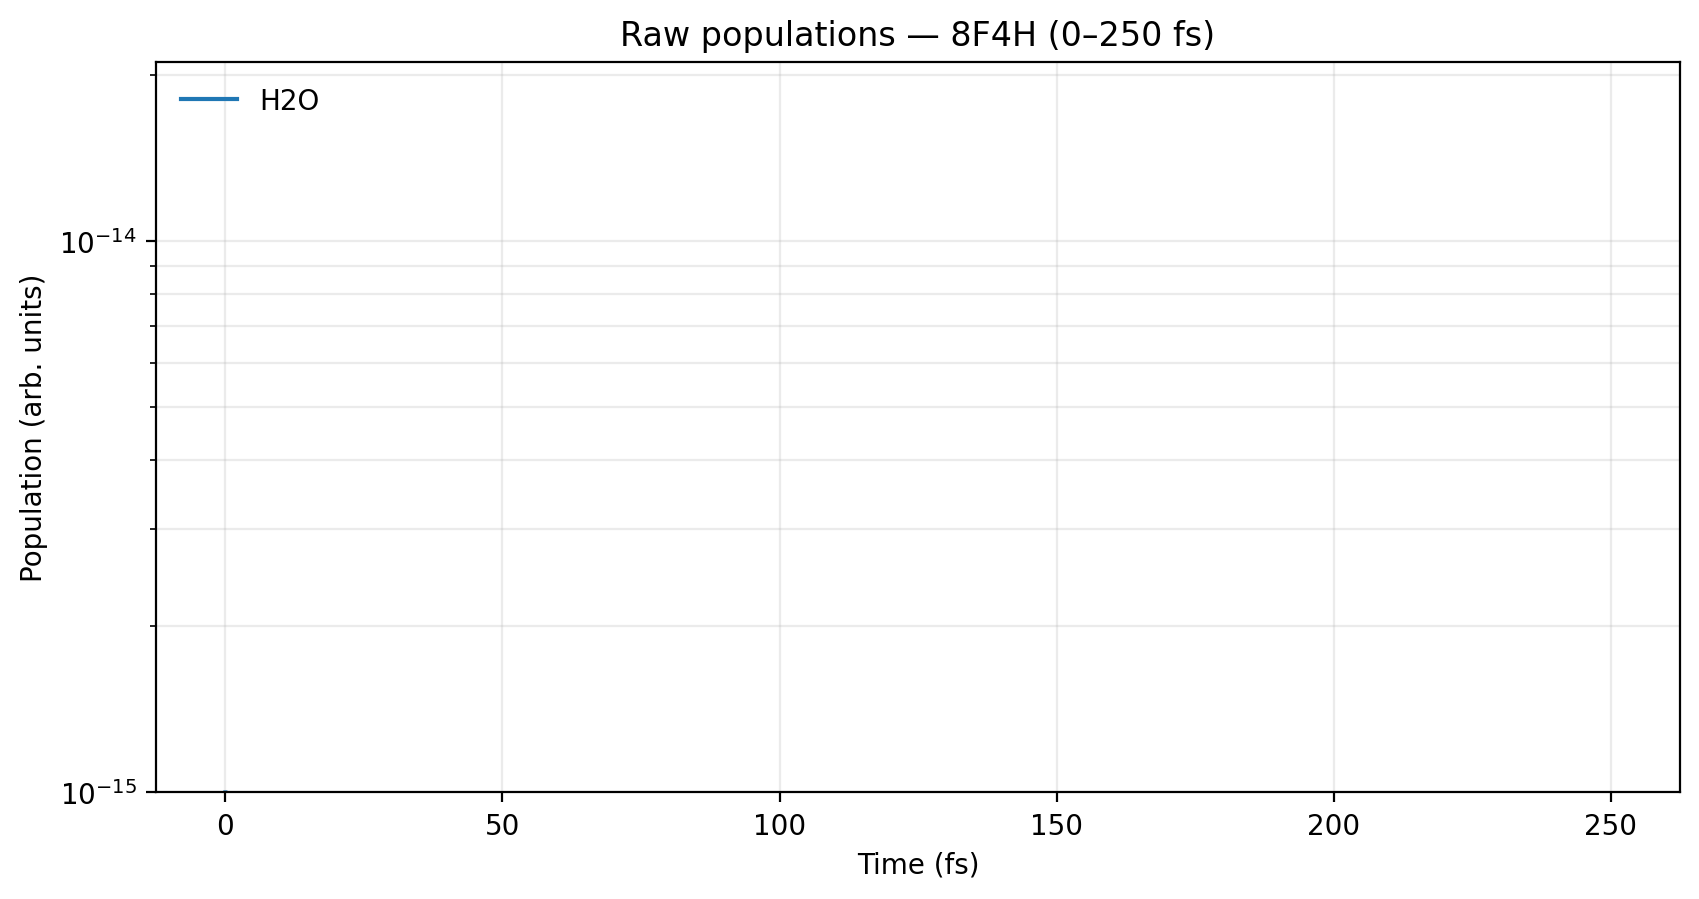

Wrote: /content/si_rawtrace_8F4H_semilog.png
       /content/si_rawtrace_8F4H_semilog.pdf


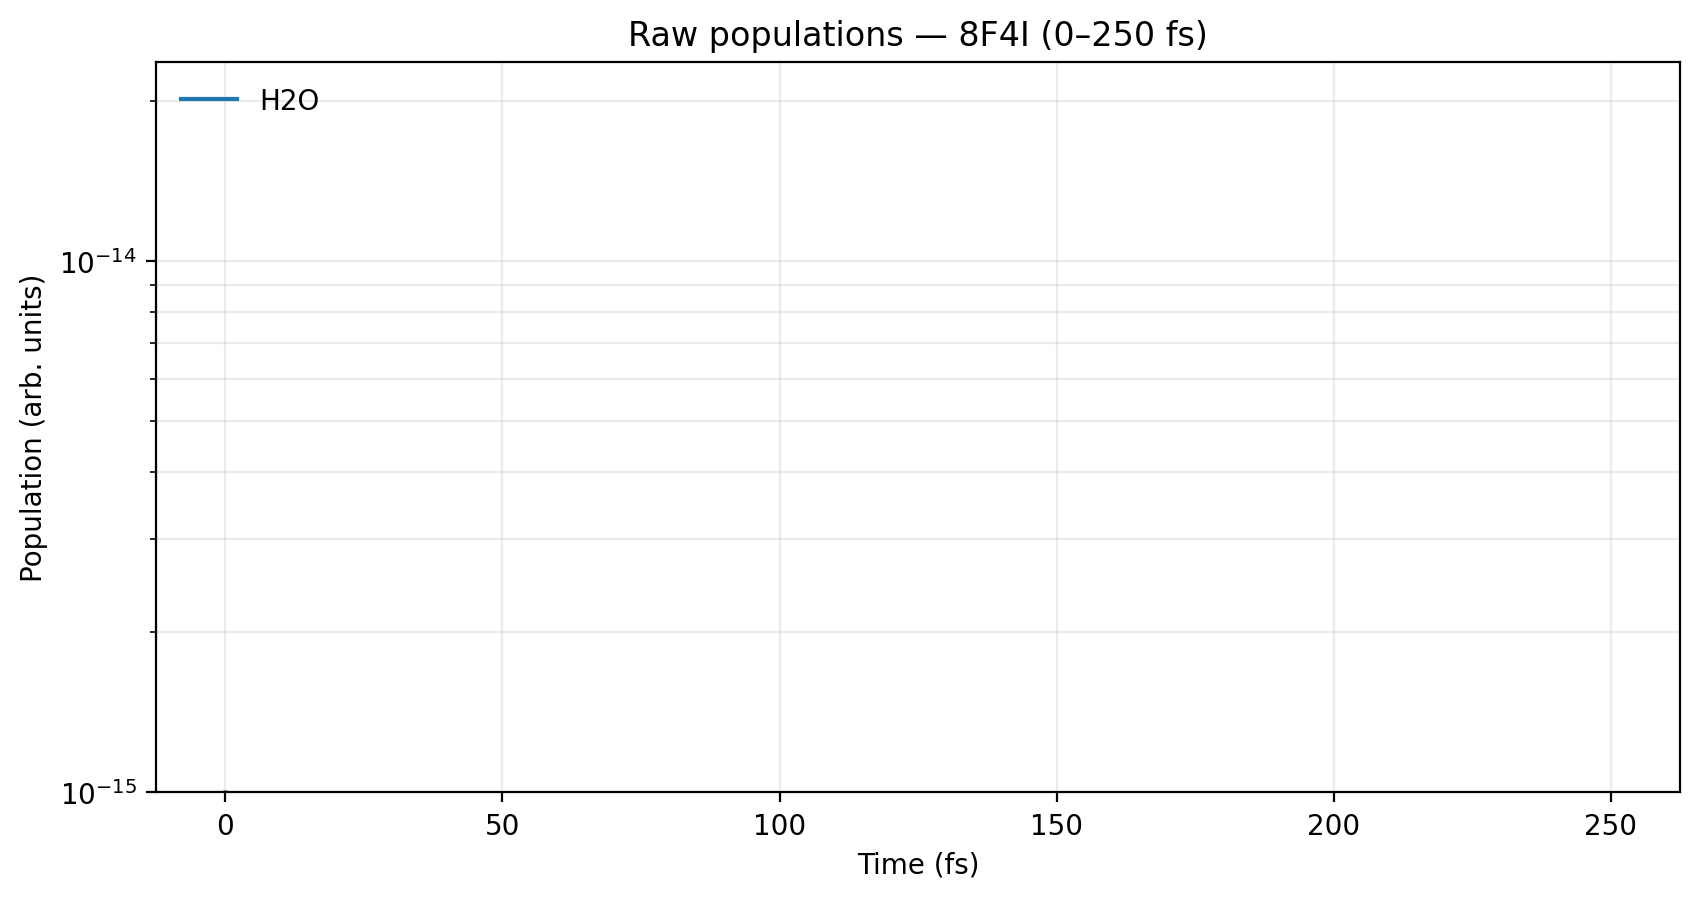

Wrote: /content/si_rawtrace_8F4I_semilog.png
       /content/si_rawtrace_8F4I_semilog.pdf


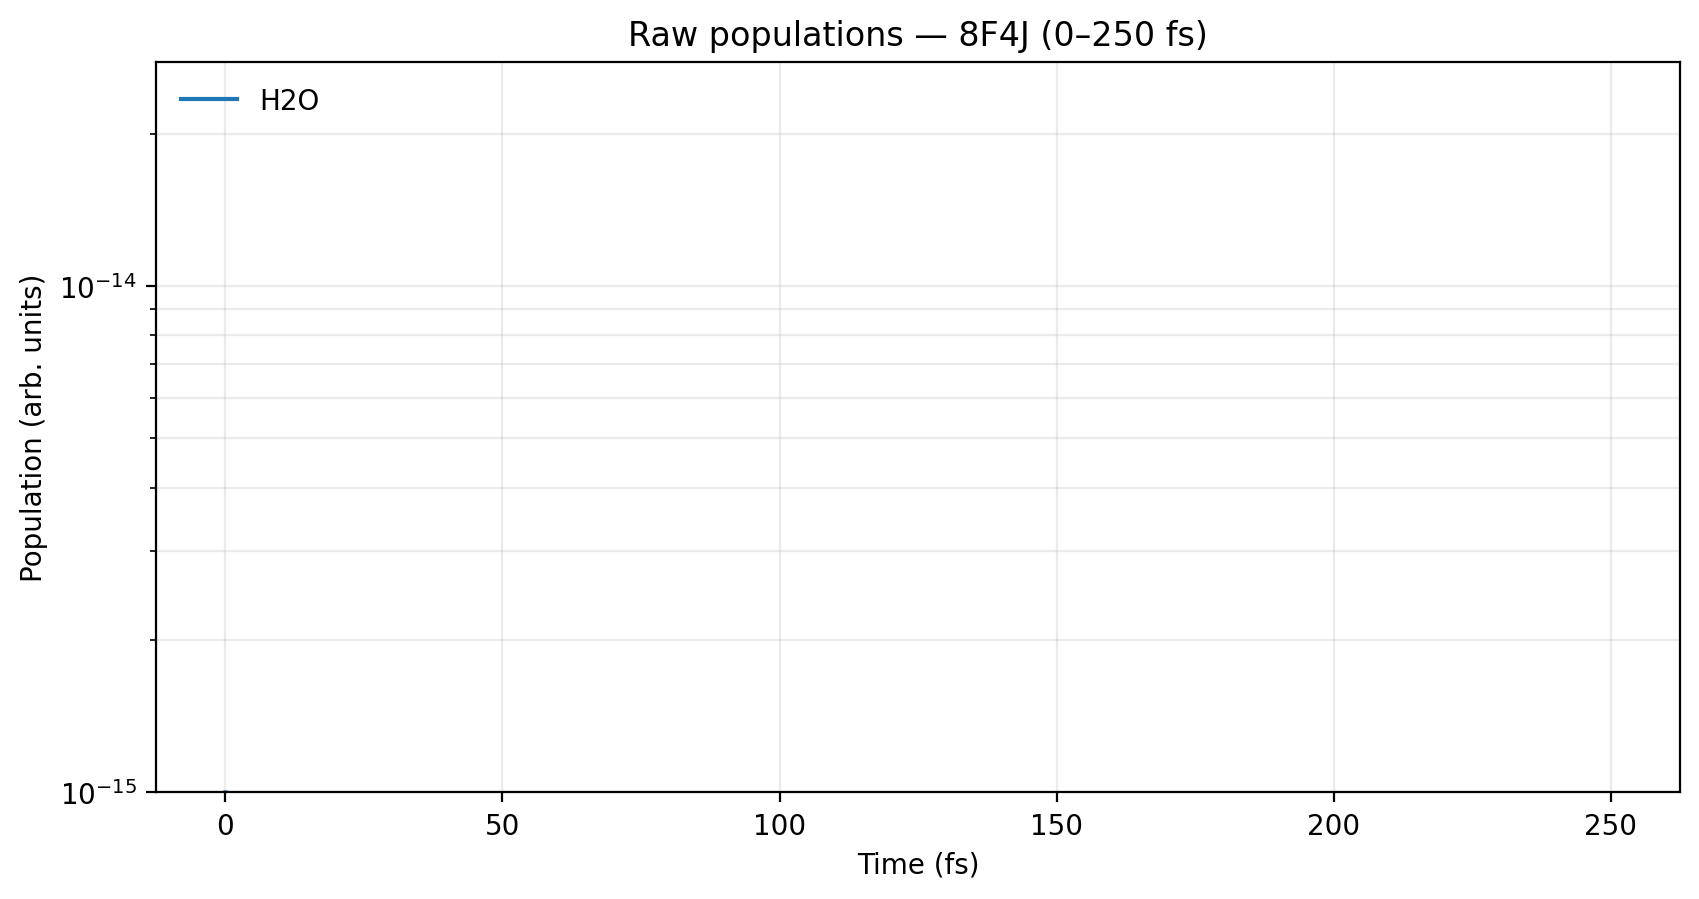

Wrote: /content/si_rawtrace_8F4J_semilog.png
       /content/si_rawtrace_8F4J_semilog.pdf


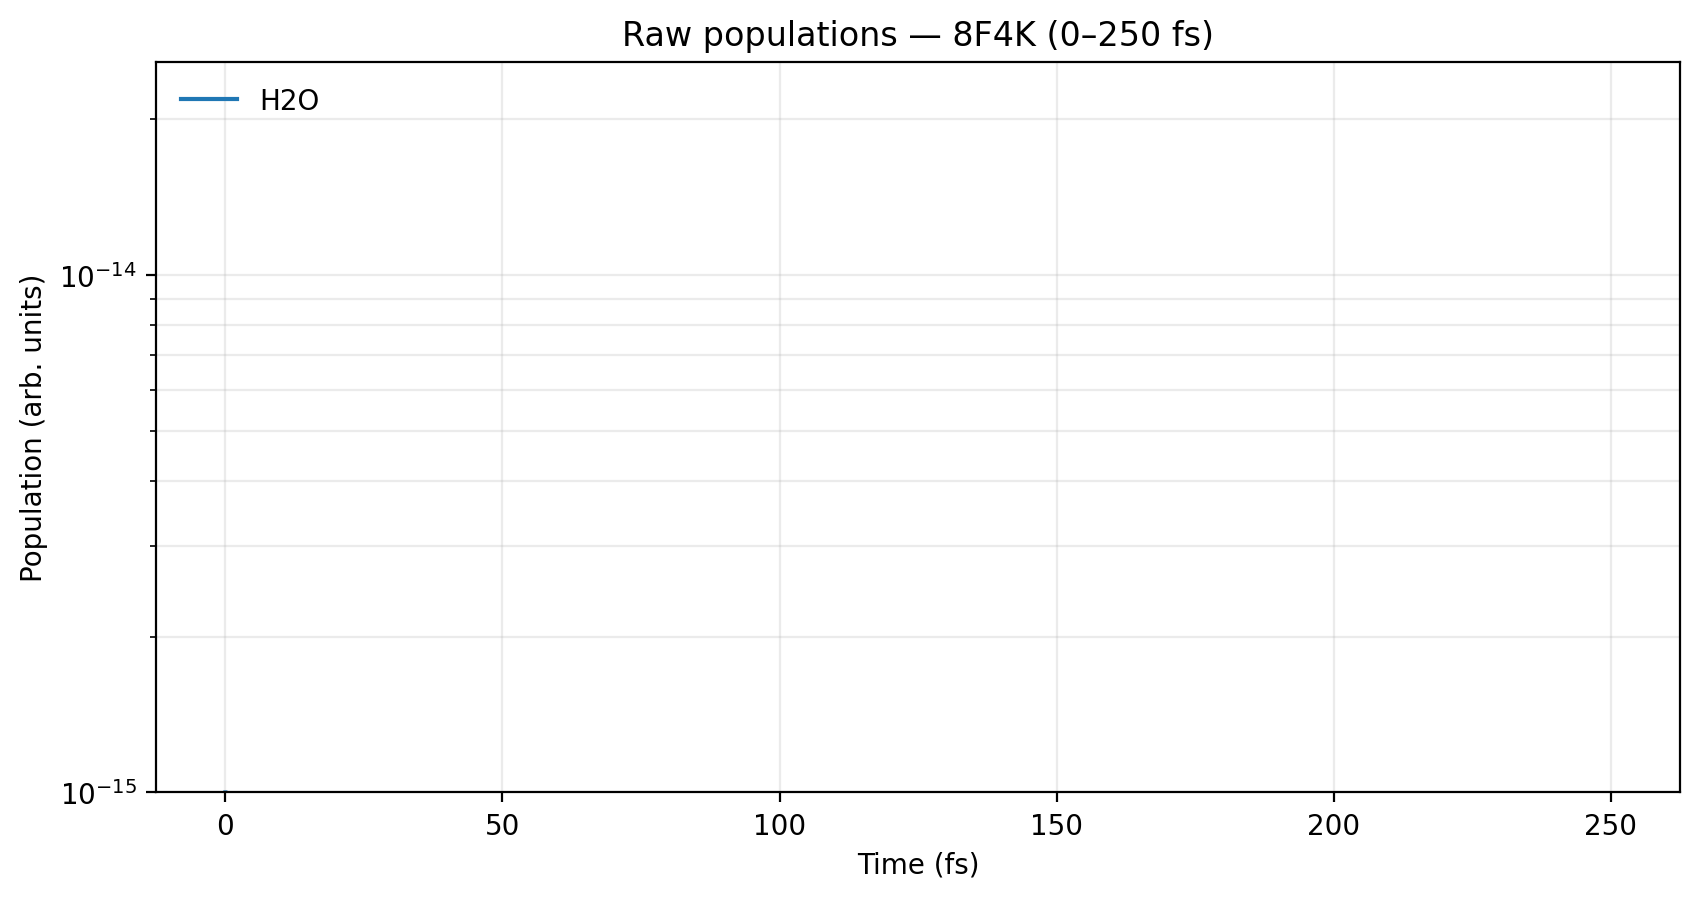

Wrote: /content/si_rawtrace_8F4K_semilog.png
       /content/si_rawtrace_8F4K_semilog.pdf


In [ ]:
# --- SETTINGS ---
CSV_PATH = "/content/all-GQR9-raw_timeseries.csv"   # adjust if needed
OUTDIR   = "/content"                               # or your preferred folder
TARGETS  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]  # 8F4* series
MEDIA    = ["H2O","H2S","D2S","T2S"]                # the four you asked for

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv(CSV_PATH, low_memory=False)

# auto-detect likely columns (keeps this robust across csv variants)
time_col = next(c for c in df.columns if re.search("time", c, re.I))
cif_col  = next(c for c in df.columns if re.search("cif", c, re.I))
med_col  = next(c for c in df.columns if re.search("(medium|variant)", c, re.I))

# try common sum-columns for water/sulfur; fall back to any pop-like columns per medium
water_cols = [c for c in df.columns if re.search(r"(OW3|OW4|water).*pop", c, re.I)]
sulfur_cols= [c for c in df.columns if re.search(r"(SW3|SW4|sulfur).*pop", c, re.I)]

def _get_series(sub):
    """
    Returns dict: medium -> y-array.
    Prefers explicit water/sulfur totals if present; otherwise sums all columns containing that medium tag.
    """
    out = {}
    cols = sub.columns

    def sum_cols(regex):
        pick = [c for c in cols if re.search(regex, c, re.I)]
        return sub[pick].sum(axis=1) if pick else None

    # explicit totals if present
    w_total = sum_cols(r"(OW3|OW4).*pop|pop[_-]?water|water[_-]?total")
    s_total = sum_cols(r"(SW3|SW4).*pop|pop[_-]?sulfur|sulfur[_-]?total")

    for m in MEDIA:
        if m in ("H2O","D2O","T2O"):
            y = w_total if w_total is not None else sum_cols(fr"{m}.*pop")
        else:
            y = s_total if s_total is not None else sum_cols(fr"{m}.*pop")
        if y is not None and np.isfinite(y).any():
            out[m] = y.to_numpy()
    return out

def plot_one(cif_id: str, semilog=True):
    sub = df[df[cif_col] == cif_id].sort_values(time_col)
    if sub.empty:
        print(f"[SKIP] {cif_id}: not found in CSV");
        return

    t = sub[time_col].to_numpy()
    series = _get_series(sub)

    # build the figure
    fig, ax = plt.subplots(figsize=(8.6, 4.6), dpi=200)
    colors = {"H2O":None, "H2S":None, "D2S":None, "T2S":None}  # let mpl choose, preserves journal style
    ls     = {"H2O":"-", "H2S":"-", "D2S":"--", "T2S":"-."}

    # small positive floor to avoid log(0)
    floor = 1e-15

    for m in MEDIA:
        y = series.get(m, None)
        if y is None:
            continue
        y_plot = np.where(y <= 0, floor, y)

        if semilog:
            # use log scale if all y_plot > 0, otherwise symlog with small linear region
            if (y_plot > 0).all():
                ax.semilogy(t, y_plot, ls=ls[m], label=m)
            else:
                ax.plot(t, y_plot, ls=ls[m], label=m)
                ax.set_yscale("symlog", linthresh=1e-14)
        else:
            ax.plot(t, y_plot, ls=ls[m], label=m)

    ax.set_title(f"Raw populations — {cif_id} (0–250 fs)")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("Population (arb. units)")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(loc="upper left", ncol=2, frameon=False)

    # tidy y-limits for log
    if semilog:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(max(ymin, floor), ymax)

    out_png = Path(OUTDIR) / f"si_rawtrace_{cif_id}_semilog.png"
    out_pdf = Path(OUTDIR) / f"si_rawtrace_{cif_id}_semilog.pdf"
    fig.tight_layout()
    fig.savefig(out_png, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    print(f"Wrote: {out_png}\n       {out_pdf}")

# --- run for the 8F4* series (or change TARGETS) ---
for cif in TARGETS:
    plot_one(cif, semilog=True)

== DETECTED ==
time: time_fs | cif: cif | medium/variant: medium
population-ish columns: ['pop_water_total', 'pop_ow3', 'pop_ow4'] 

== CIF 8F4C ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


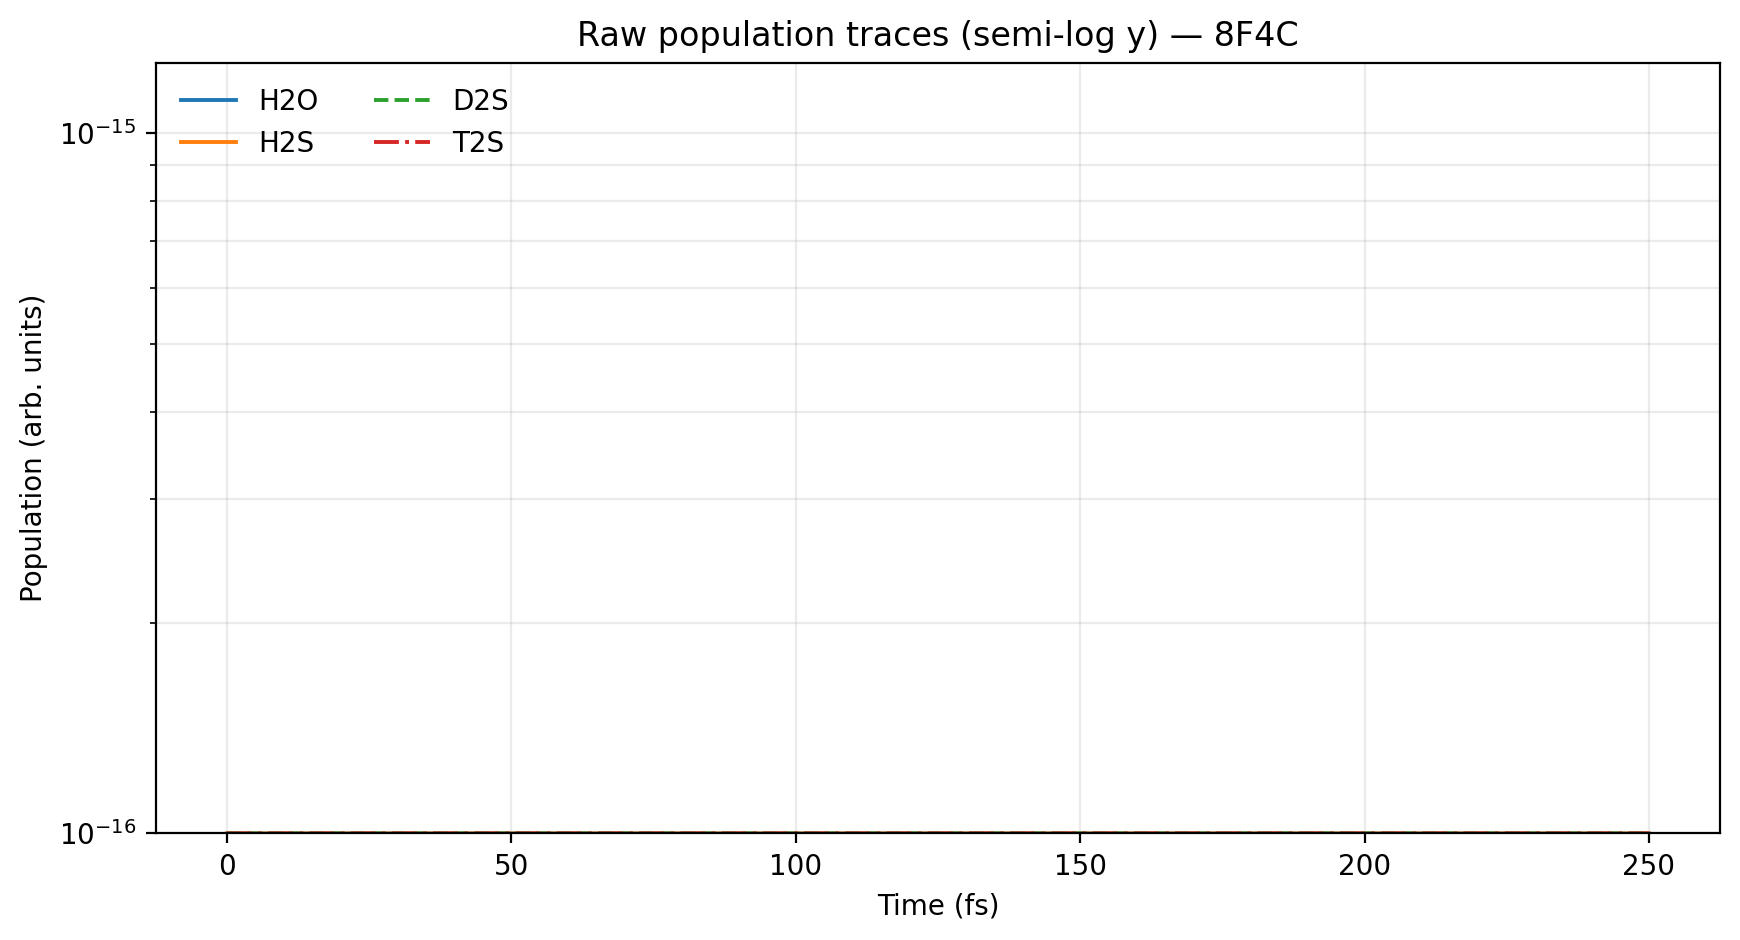

Wrote: /content/si_rawtrace_8F4C_semilog.png
       /content/si_rawtrace_8F4C_semilog.pdf

== CIF 8F4D ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


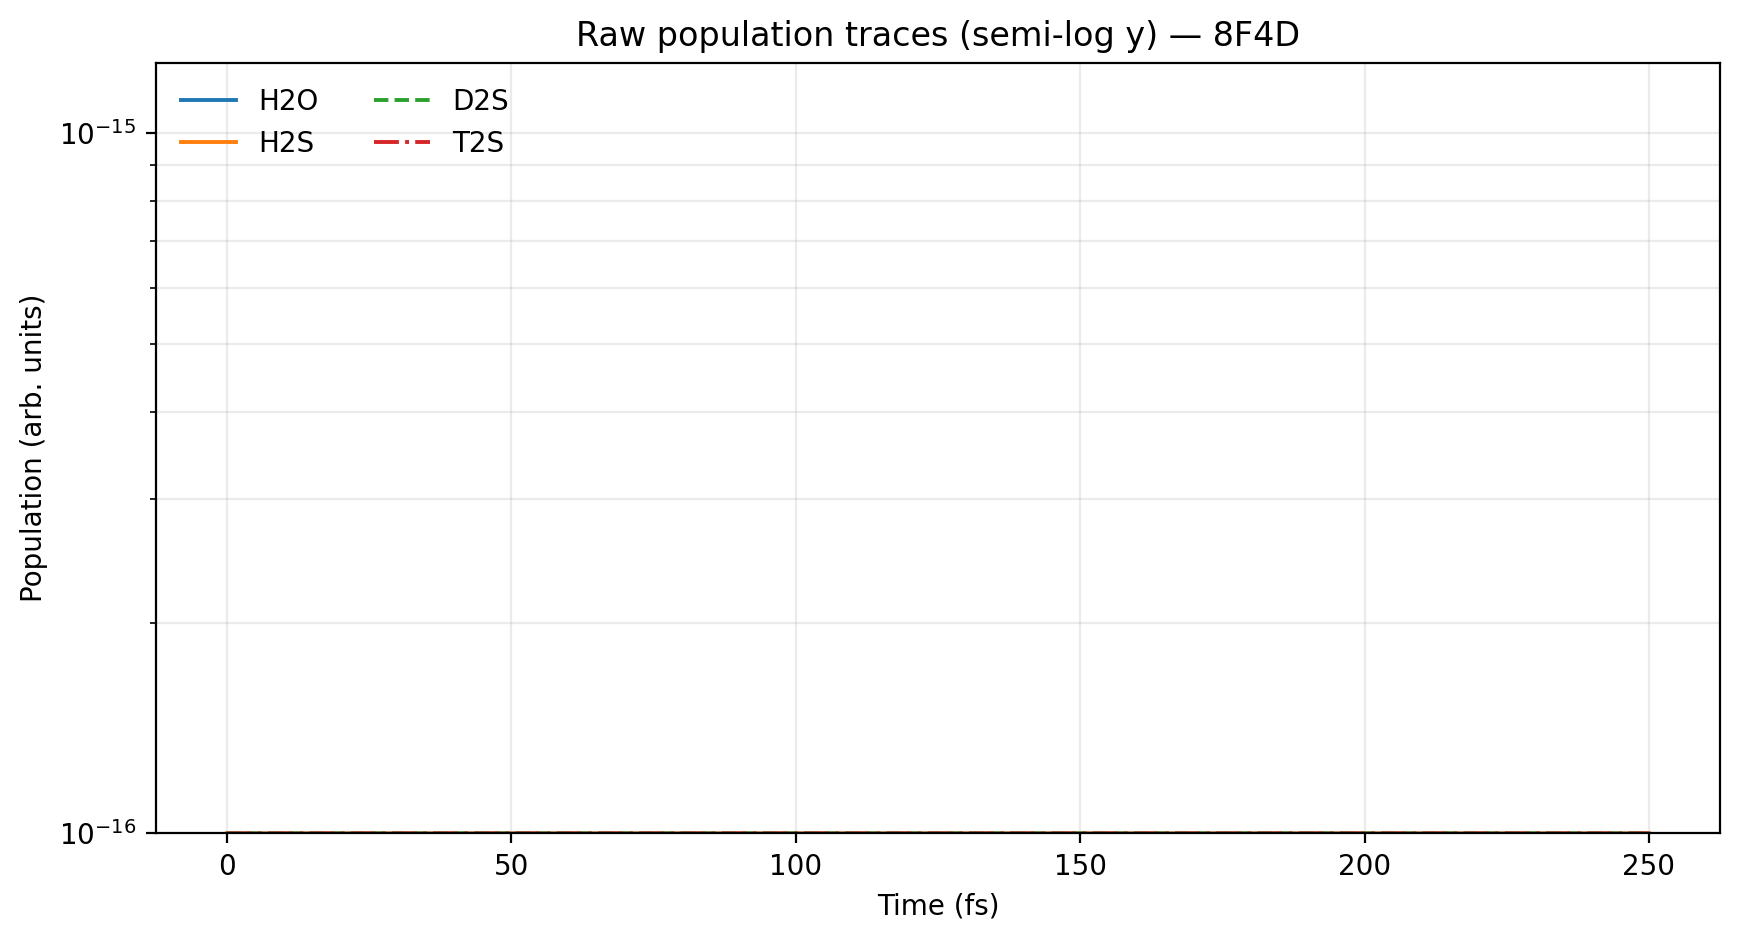

Wrote: /content/si_rawtrace_8F4D_semilog.png
       /content/si_rawtrace_8F4D_semilog.pdf

== CIF 8F4E ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


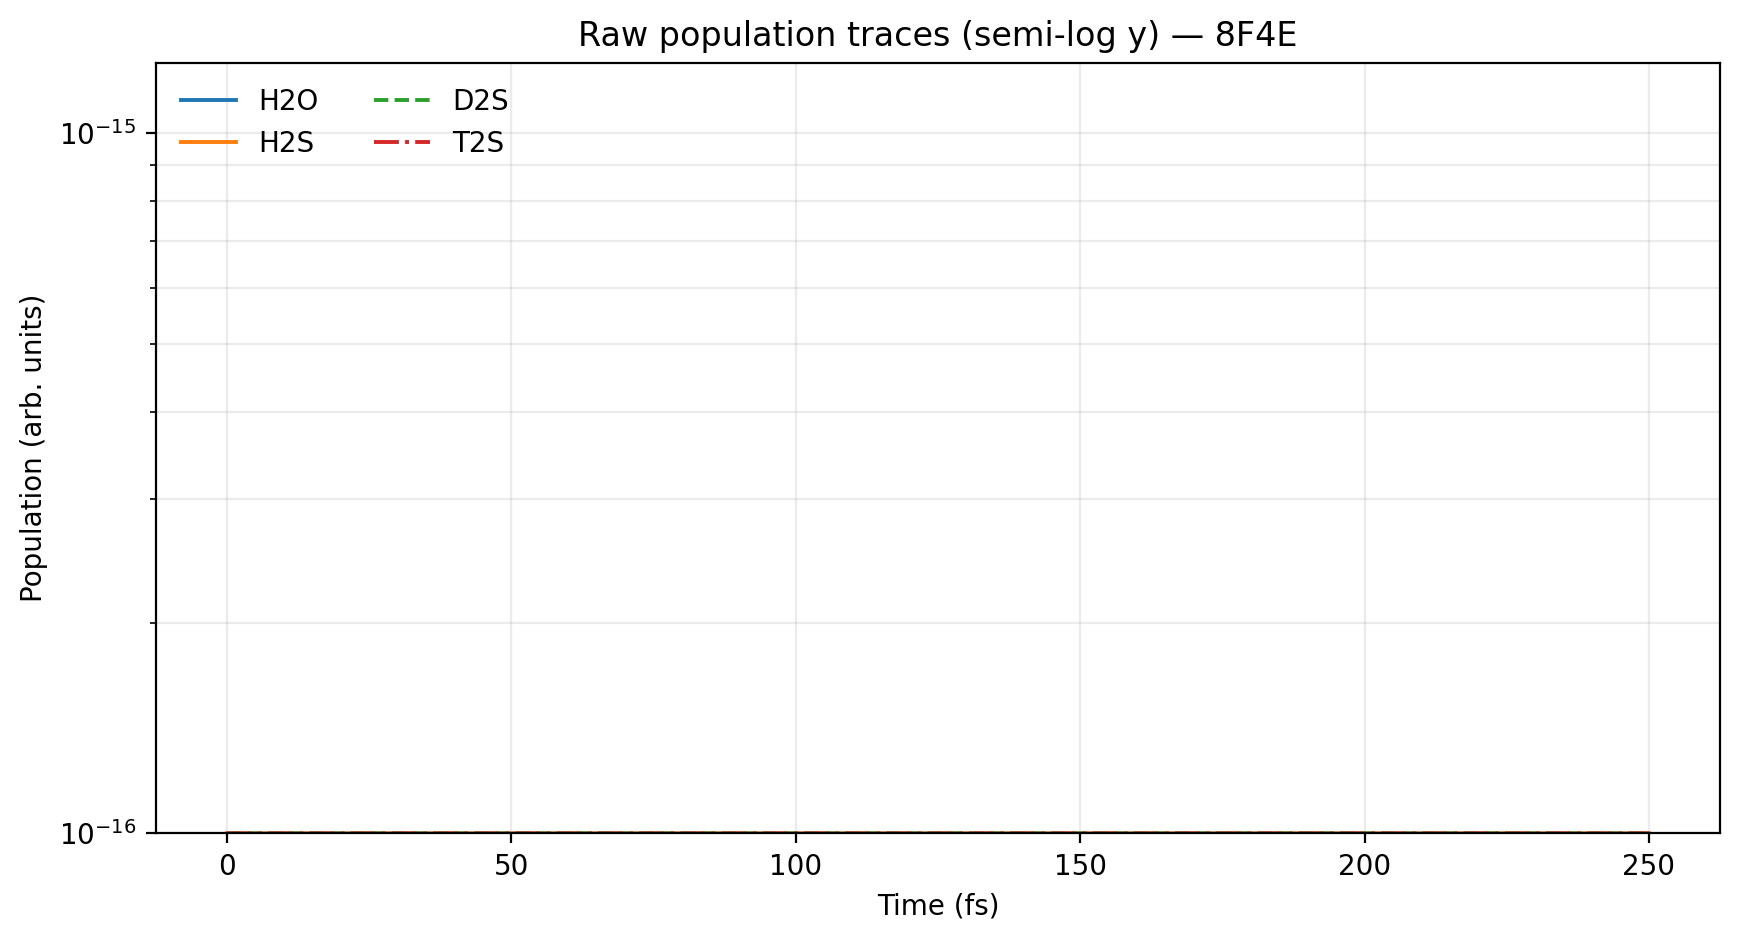

Wrote: /content/si_rawtrace_8F4E_semilog.png
       /content/si_rawtrace_8F4E_semilog.pdf

== CIF 8F4F ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


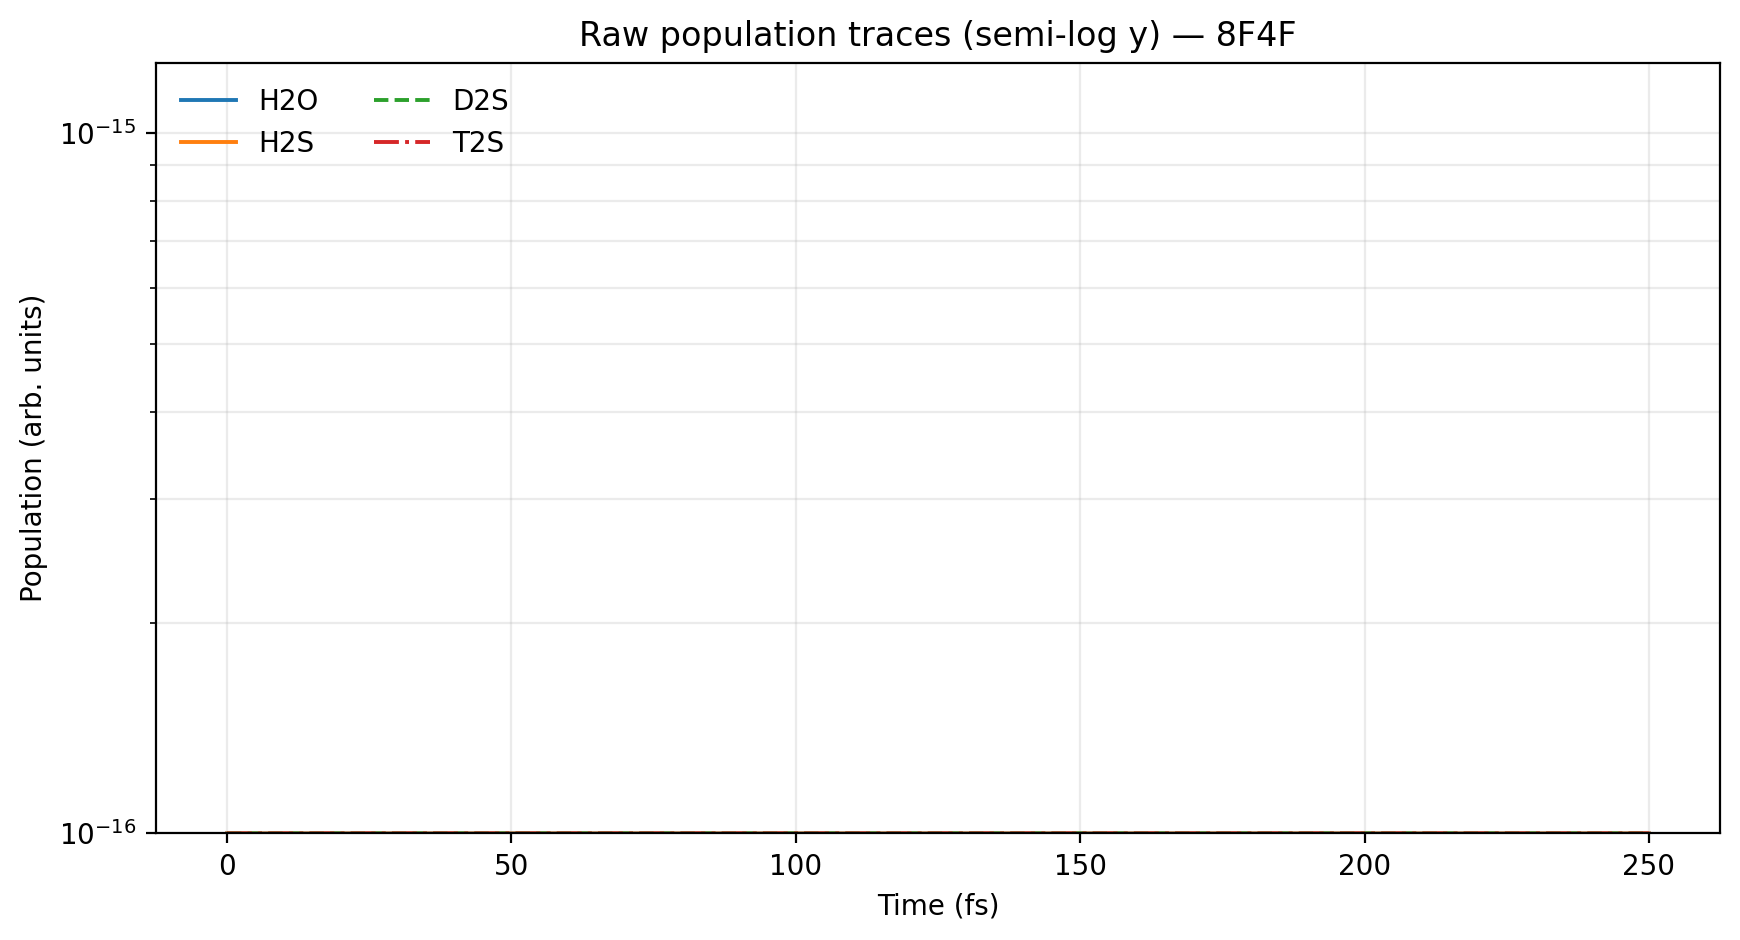

Wrote: /content/si_rawtrace_8F4F_semilog.png
       /content/si_rawtrace_8F4F_semilog.pdf

== CIF 8F4G ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


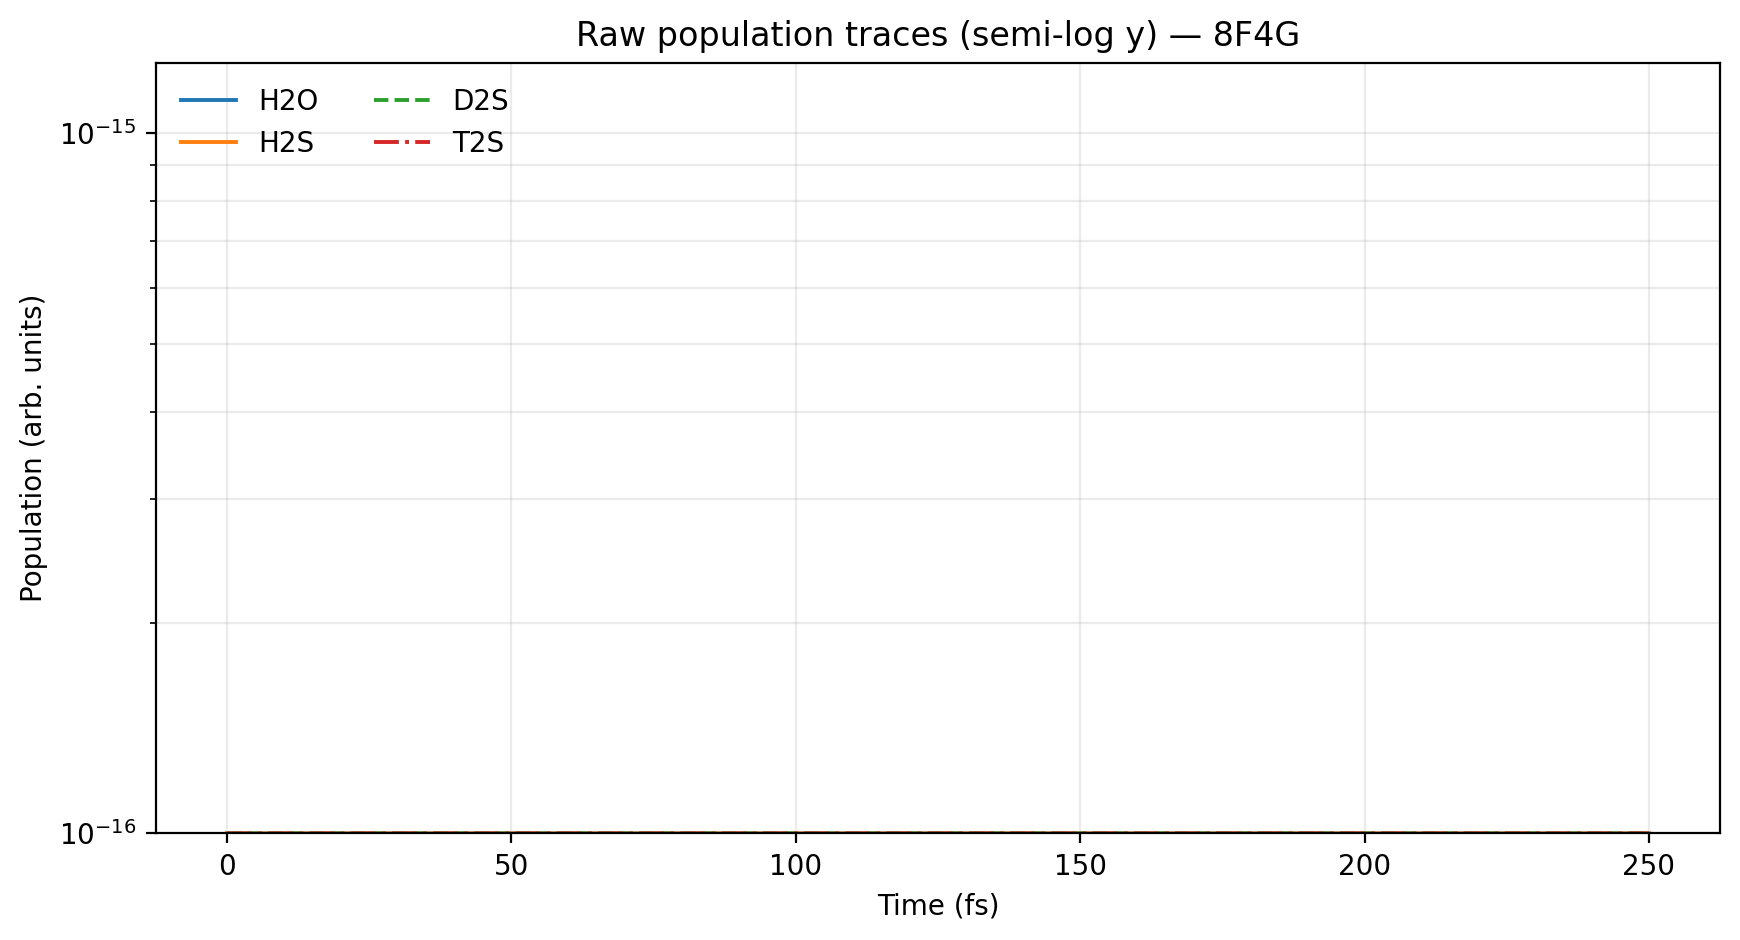

Wrote: /content/si_rawtrace_8F4G_semilog.png
       /content/si_rawtrace_8F4G_semilog.pdf

== CIF 8F4H ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


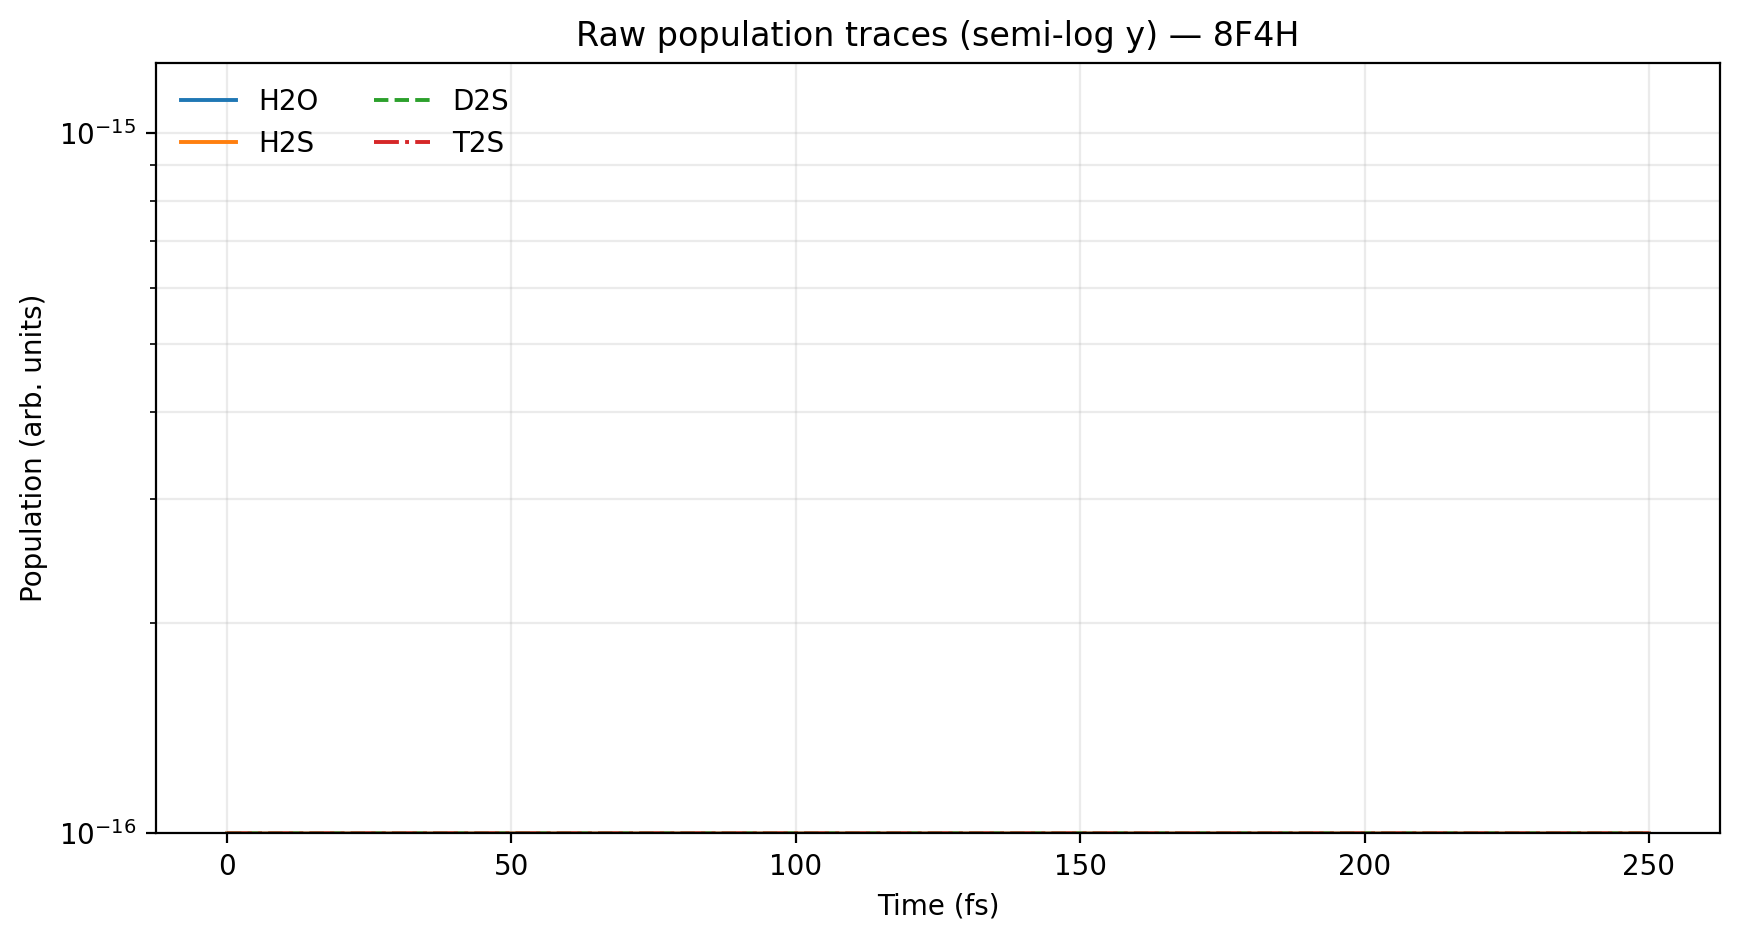

Wrote: /content/si_rawtrace_8F4H_semilog.png
       /content/si_rawtrace_8F4H_semilog.pdf

== CIF 8F4I ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


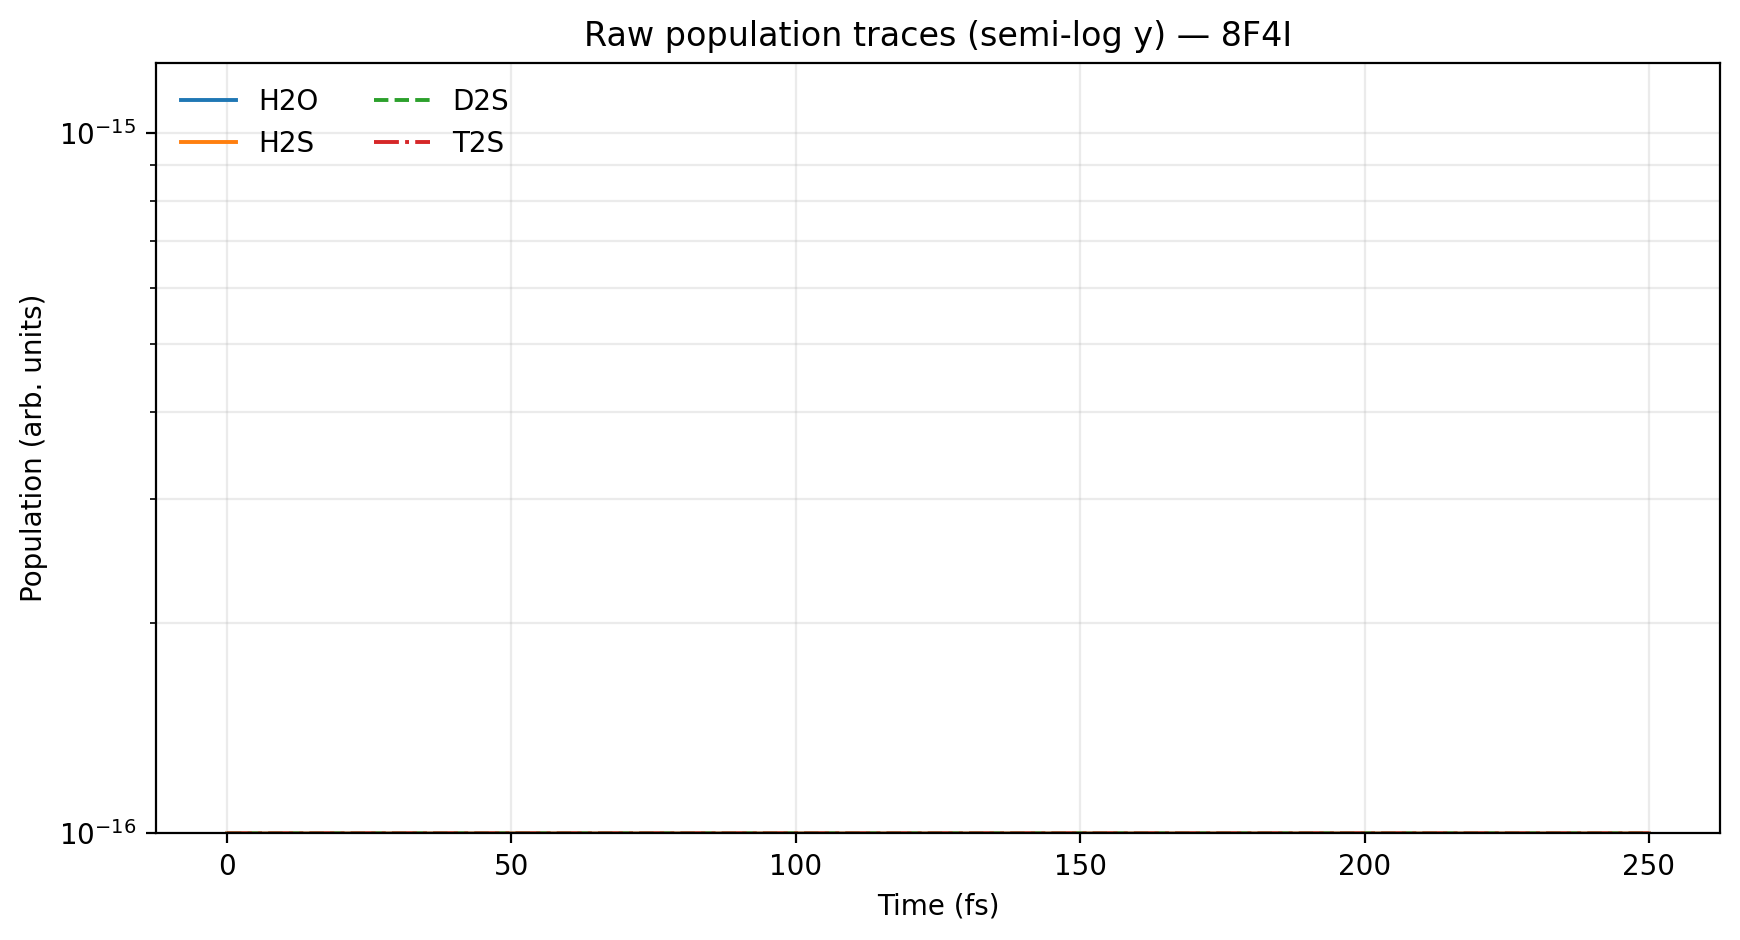

Wrote: /content/si_rawtrace_8F4I_semilog.png
       /content/si_rawtrace_8F4I_semilog.pdf

== CIF 8F4J ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


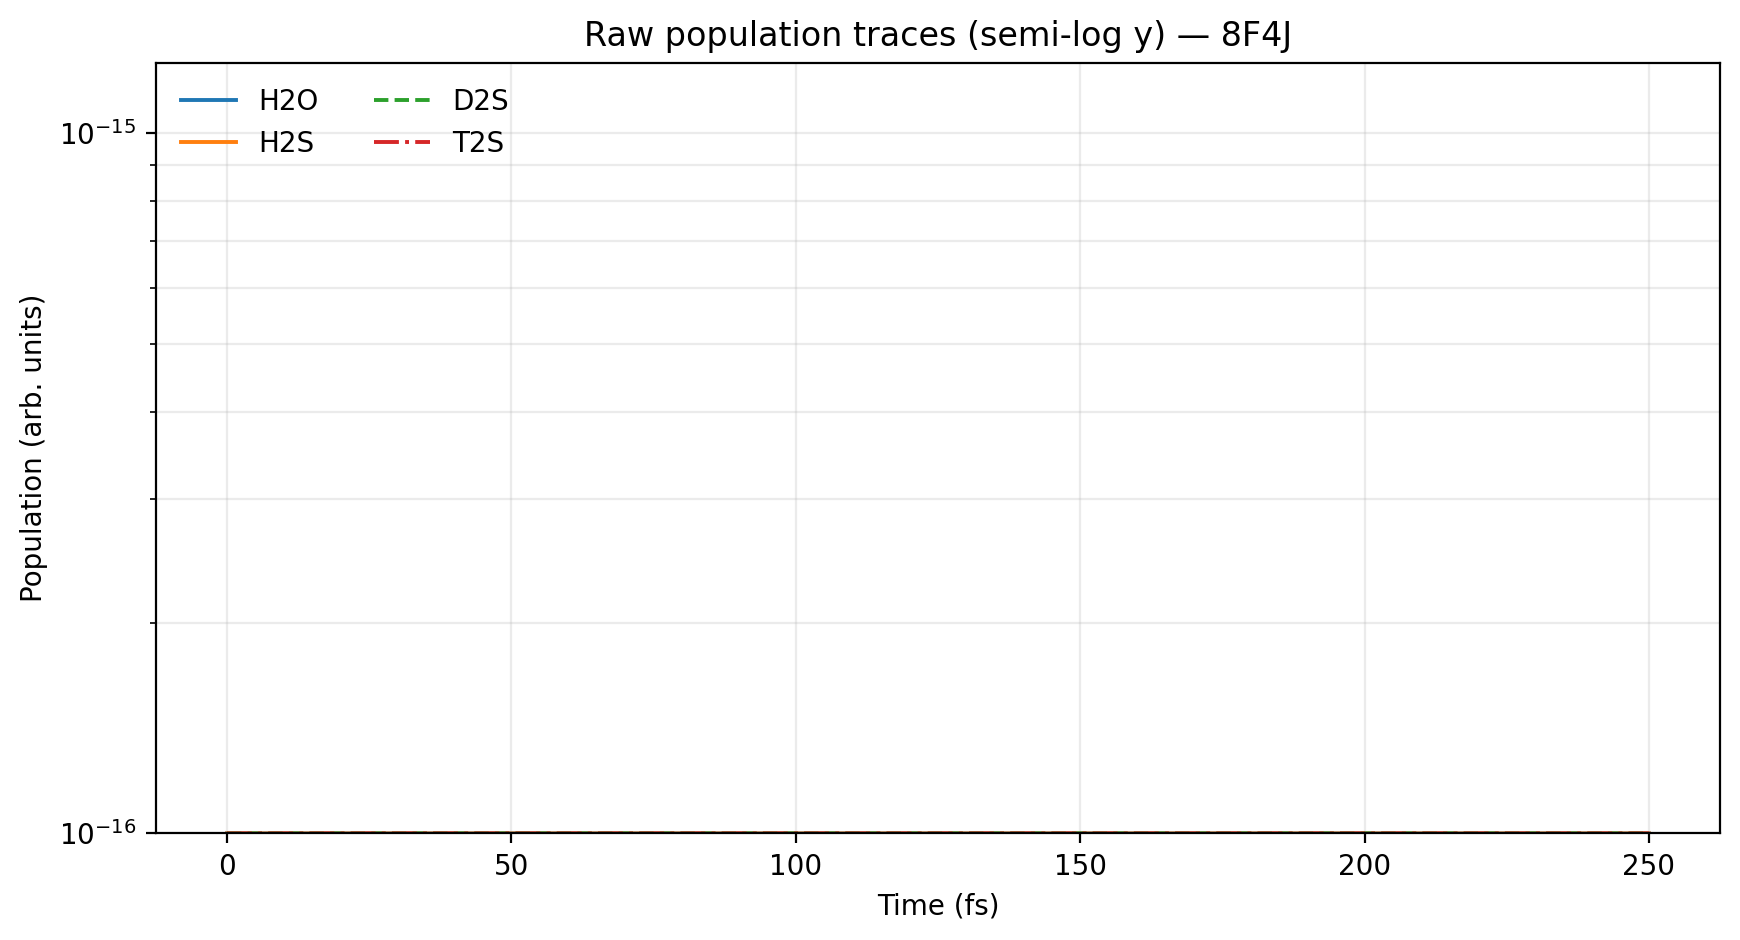

Wrote: /content/si_rawtrace_8F4J_semilog.png
       /content/si_rawtrace_8F4J_semilog.pdf

== CIF 8F4K ==
  media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  median snapshot (first few columns):
        pop_water_total  pop_ow3  pop_ow4
medium                                   
D2O                 0.0      0.0      0.0
D2S                 0.0      0.0      0.0
H2O                 0.0      0.0      0.0
H2S                 0.0      0.0      0.0
T2O                 0.0      0.0      0.0
T2S                 0.0      0.0      0.0


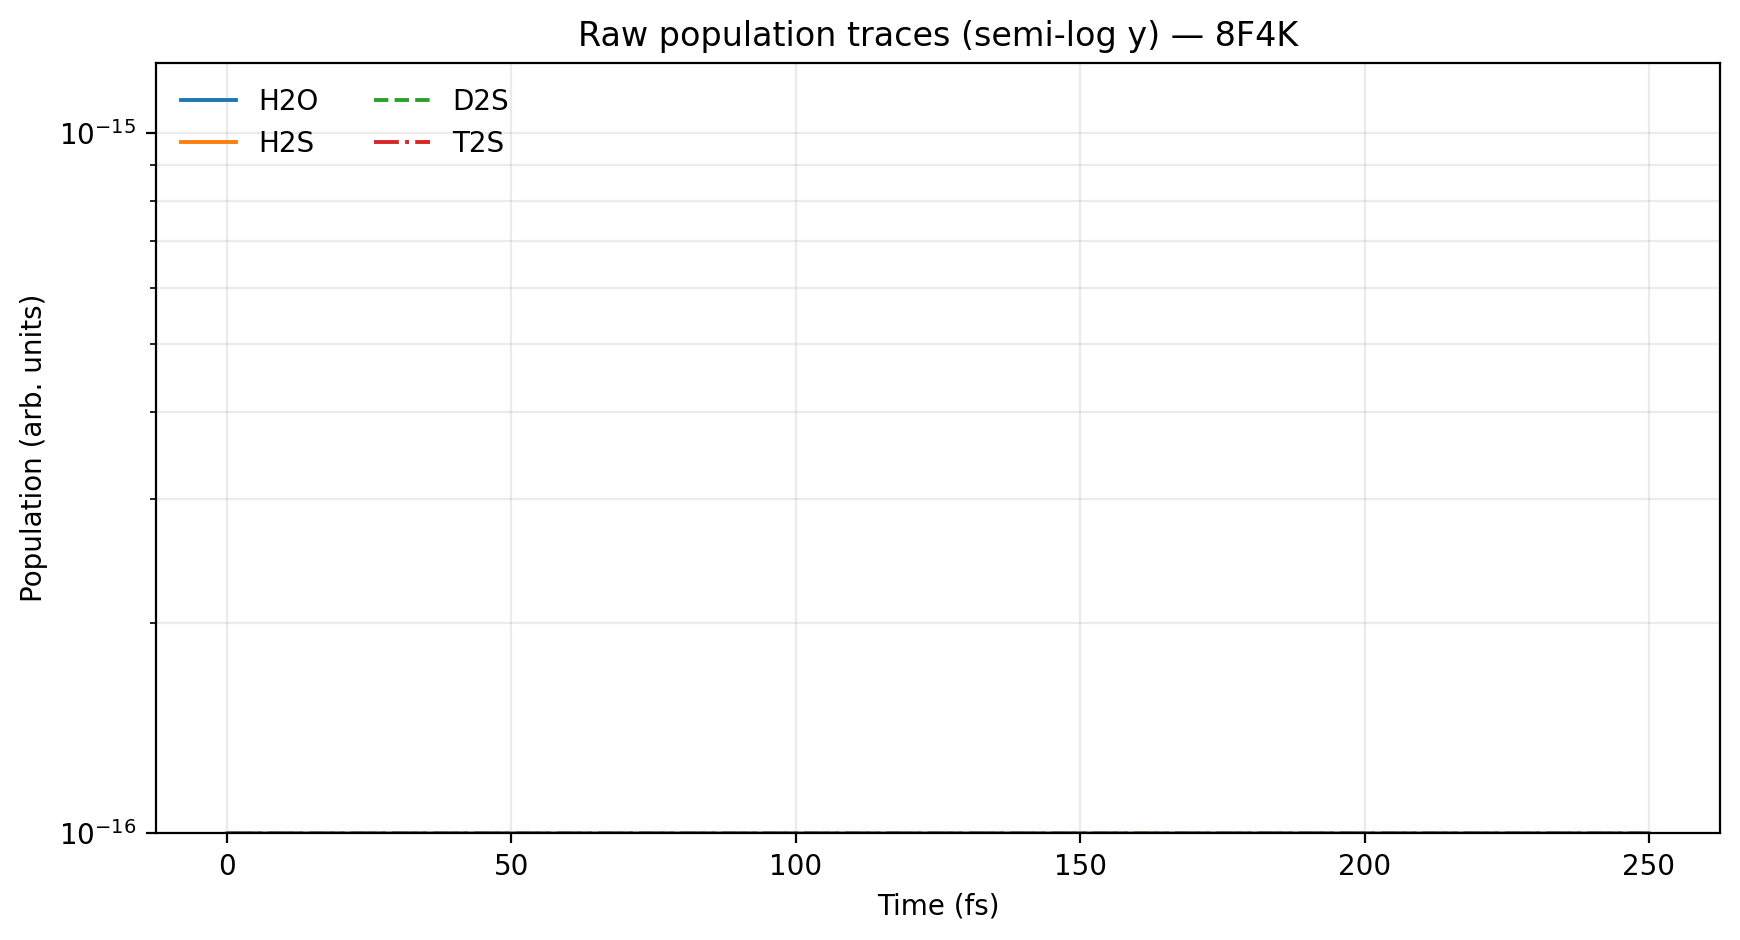

Wrote: /content/si_rawtrace_8F4K_semilog.png
       /content/si_rawtrace_8F4K_semilog.pdf


In [ ]:
# === CONFIG ===
CSV_PATH = "/content/all-GQR9-raw_timeseries.csv"  # adjust for your Colab path
OUTDIR   = "/content"
TARGETS  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
MEDIA    = ["H2O","H2S","D2S","T2S"]  # what to try to plot

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv(CSV_PATH, low_memory=False)

# --- detect columns / layout ---
cols = df.columns.tolist()
def find_col(pattern, default=None):
    for c in cols:
        if re.search(pattern, c, re.I):
            return c
    return default

time_col  = find_col(r"time")
cif_col   = find_col(r"\bcif\b|cif_id|pdb|structure")
med_col   = find_col(r"\b(medium|variant)\b")
# population-like columns (catch both water & sulfur naming)
pop_cols  = [c for c in cols if re.search(r"(pop|OW[34]|SW[34])", c, re.I)]

print("== DETECTED ==")
print("time:", time_col, "| cif:", cif_col, "| medium/variant:", med_col)
print("population-ish columns:", pop_cols[:10], ("..." if len(pop_cols)>10 else ""))

if time_col is None or cif_col is None:
    raise RuntimeError("Could not detect time or cif columns. Please set time_col / cif_col manually.")

# --- helper: summarise per CIF what rows/columns exist ---
def debug_cif(cif_id):
    sub = df[df[cif_col] == cif_id] if cif_col in df else pd.DataFrame()
    print(f"\n== CIF {cif_id} ==")
    if sub.empty:
        print("  No rows.")
        return sub
    if med_col:
        print("  media present:", sorted(map(str, sub[med_col].dropna().unique()))[:12])
        # quick median per medium for any pop-like column, to check scale
        med_summary = (sub.groupby(med_col)[pop_cols].median(numeric_only=True)
                          .replace([np.inf,-np.inf], np.nan))
        print("  median snapshot (first few columns):")
        print(med_summary.iloc[:, :min(6, med_summary.shape[1])].round(3))
    else:
        # wide layout — show which medium-specific columns exist
        have = {m: [c for c in cols if (re.search(m, c, re.I) and re.search(r"(pop|OW[34]|SW[34])", c, re.I))]
                for m in MEDIA}
        for m, clist in have.items():
            print(f"  {m}: {len(clist)} columns -> {clist[:6]}{' ...' if len(clist)>6 else ''}")
    return sub

# --- population constructor that works for both LONG and WIDE ---
def get_series(sub, medium):
    """
    Returns y-array for the requested medium in `sub` (rows restricted to a single CIF).
    LONG layout (with med_col):
        - filter rows by medium; sum OW3+OW4 for water media, SW3+SW4 for sulfur media,
          falling back to any 'pop' columns if needed.
    WIDE layout (no med_col):
        - find columns that contain both the medium tag and population pattern, sum them.
    """
    # 1) LONG layout
    if med_col:
        sub_m = sub[sub[med_col].astype(str).str.upper() == medium.upper()]
        if sub_m.empty:
            return None

        # candidate groups
        w_like = [c for c in sub_m.columns if re.search(r"(OW3|OW4).*pop|pop.*(water|OW)", c, re.I)]
        s_like = [c for c in sub_m.columns if re.search(r"(SW3|SW4).*pop|pop.*(sulfur|SW)", c, re.I)]
        generic= [c for c in sub_m.columns if re.search(r"\bpop", c, re.I)]

        if medium.endswith("O"):   # H2O/D2O/T2O
            pick = w_like or generic
        else:                      # H2S/D2S/T2S
            pick = s_like or generic

        if not pick:
            # last resort: any OW/SW numeric columns
            if medium.endswith("O"):
                pick = [c for c in sub_m.columns if re.search(r"OW[34]", c, re.I)]
            else:
                pick = [c for c in sub_m.columns if re.search(r"SW[34]", c, re.I)]

        if not pick:
            return None
        y = sub_m[pick].sum(axis=1, numeric_only=True)
        t = sub_m[time_col].to_numpy()
        return t, y.to_numpy()

    # 2) WIDE layout
    pick = [c for c in sub.columns if re.search(medium, c, re.I) and re.search(r"(pop|OW[34]|SW[34])", c, re.I)]
    if not pick:
        return None
    y = sub[pick].sum(axis=1, numeric_only=True)
    t = sub[time_col].to_numpy()
    return t, y.to_numpy()

# --- plotting (semi-log y with adaptive floor) ---
def plot_cif(cif_id, semilog=True):
    sub = df[df[cif_col] == cif_id].sort_values(time_col)
    if sub.empty:
        print(f"[SKIP] {cif_id}: no rows found.")
        return

    # diagnostics
    debug_cif(cif_id)

    fig, ax = plt.subplots(figsize=(8.8, 4.8), dpi=200)
    styles = {"H2O":"-", "H2S":"-", "D2S":"--", "T2S":"-."}

    plotted = 0
    ymin_seen = np.inf
    for m in MEDIA:
        res = get_series(sub, m)
        if res is None:
            print(f"  [warn] {cif_id} / {m}: no matching columns/rows to plot.")
            continue
        t, y = res
        # adaptive floor: 1e-4 of positive median, but not below 1e-16
        pos = y[np.isfinite(y) & (y > 0)]
        floor = max(1e-16, np.nanmedian(pos)*1e-4) if pos.size else 1e-16
        y_plot = np.where(y <= floor, floor, y)

        if semilog:
            ax.semilogy(t, y_plot, styles.get(m,"-"), label=m, linewidth=1.4)
        else:
            ax.plot(t, y_plot, styles.get(m,"-"), label=m, linewidth=1.4)

        ymin_seen = min(ymin_seen, np.nanmin(y_plot))
        plotted += 1

    if plotted == 0:
        print(f"[SKIP] {cif_id}: nothing plotted (check column patterns / medium tags).")
        plt.close(fig)
        return

    ax.set_title(f"Raw population traces (semi-log y) — {cif_id}")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("Population (arb. units)")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(loc="upper left", ncol=2, frameon=False)
    if semilog:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(max(ymin, ymin_seen), ymax)

    fig.tight_layout()
    out_png = Path(OUTDIR) / f"si_rawtrace_{cif_id}_semilog.png"
    out_pdf = Path(OUTDIR) / f"si_rawtrace_{cif_id}_semilog.pdf"
    fig.savefig(out_png, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    print(f"Wrote: {out_png}\n       {out_pdf}")

# --- RUN for the series ---
for cif in TARGETS:
    plot_cif(cif, semilog=True)

== DETECTED ==
time: time_fs | cif: cif | medium: medium

Sulfur-like columns found: ['sulfur_shift']

Water-related columns present: ['pop_water_total', 'pop_ow3', 'pop_ow4']

== CIF 8F4C == (rows: 75006)
media present: ['D2O', 'D2S', 'H2O', 'H2S', 'T2O', 'T2S']
  -- D2O --
     pop_water_total: nonzero=12500, min=0.000e+00, max=3.164e-36, mean|x|=1.354e-36
     pop_ow3: nonzero=12500, min=0.000e+00, max=1.894e-36, mean|x|=8.566e-37
     pop_ow4: nonzero=12500, min=0.000e+00, max=1.285e-36, mean|x|=4.976e-37
  -- D2S --
     pop_water_total: nonzero=12500, min=0.000e+00, max=8.897e-38, mean|x|=4.091e-38
     pop_ow3: nonzero=12500, min=0.000e+00, max=5.142e-38, mean|x|=2.437e-38
     pop_ow4: nonzero=12500, min=0.000e+00, max=3.862e-38, mean|x|=1.653e-38
  -- H2O --
     pop_water_total: nonzero=12500, min=0.000e+00, max=1.405e-31, mean|x|=5.231e-32
     pop_ow3: nonzero=12500, min=0.000e+00, max=9.131e-32, mean|x|=3.662e-32
     pop_ow4: nonzero=12500, min=0.000e+00, max=5.044e-32, m

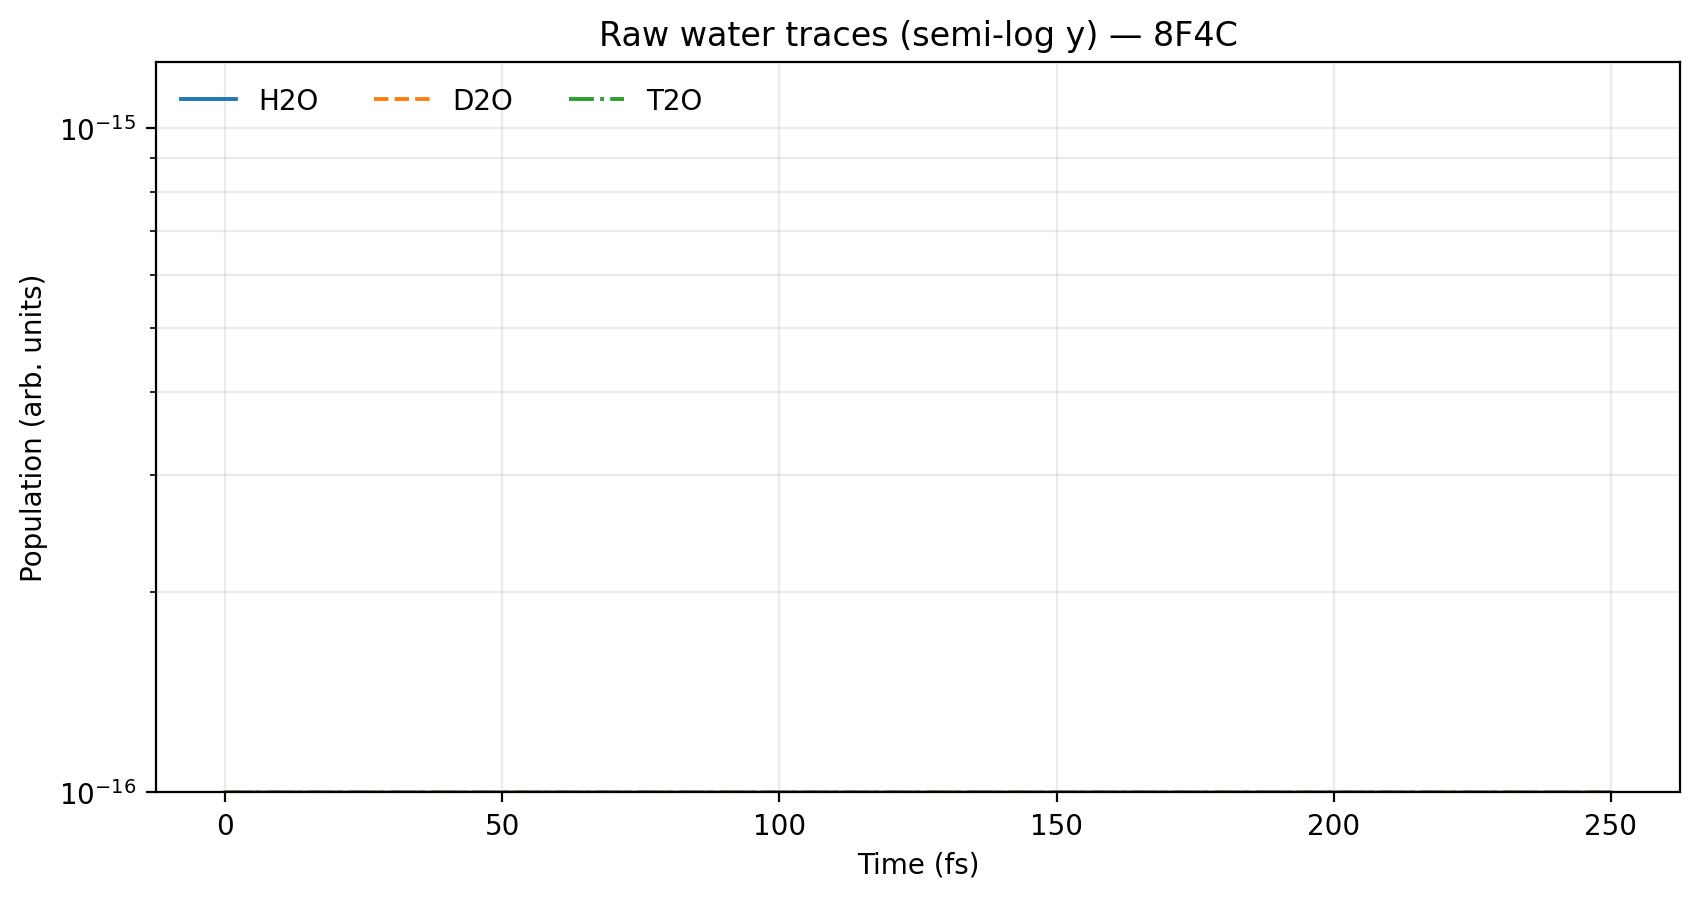

Wrote: /content/si_rawtrace_water_8F4C_semilog.png
       /content/si_rawtrace_water_8F4C_semilog.pdf


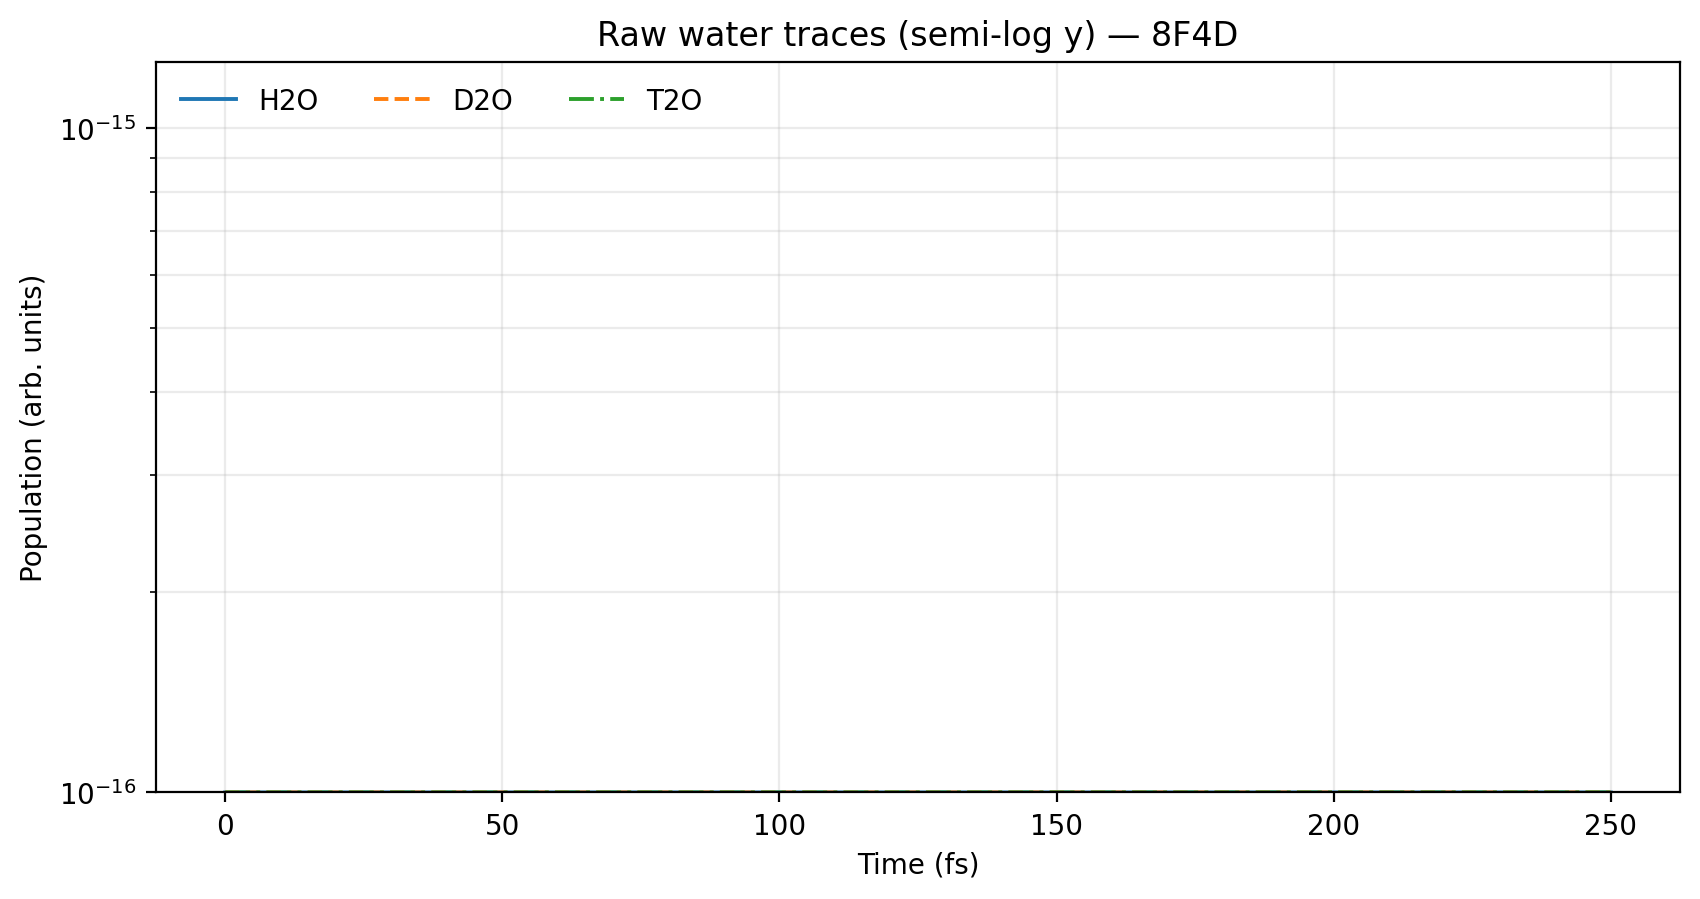

Wrote: /content/si_rawtrace_water_8F4D_semilog.png
       /content/si_rawtrace_water_8F4D_semilog.pdf


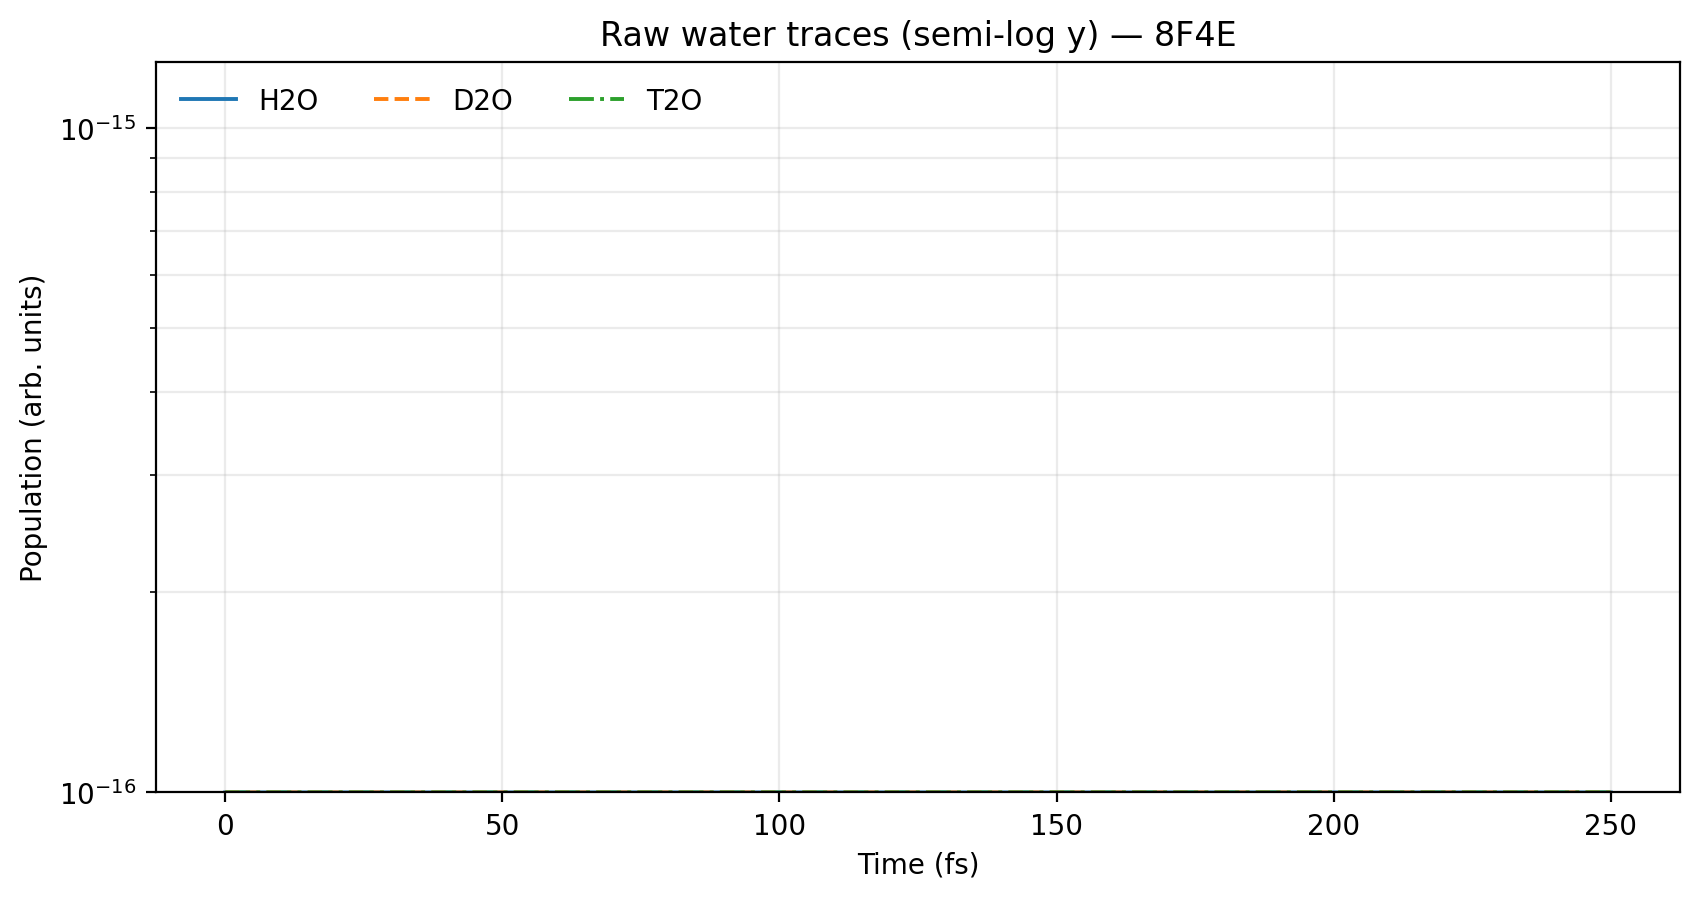

Wrote: /content/si_rawtrace_water_8F4E_semilog.png
       /content/si_rawtrace_water_8F4E_semilog.pdf


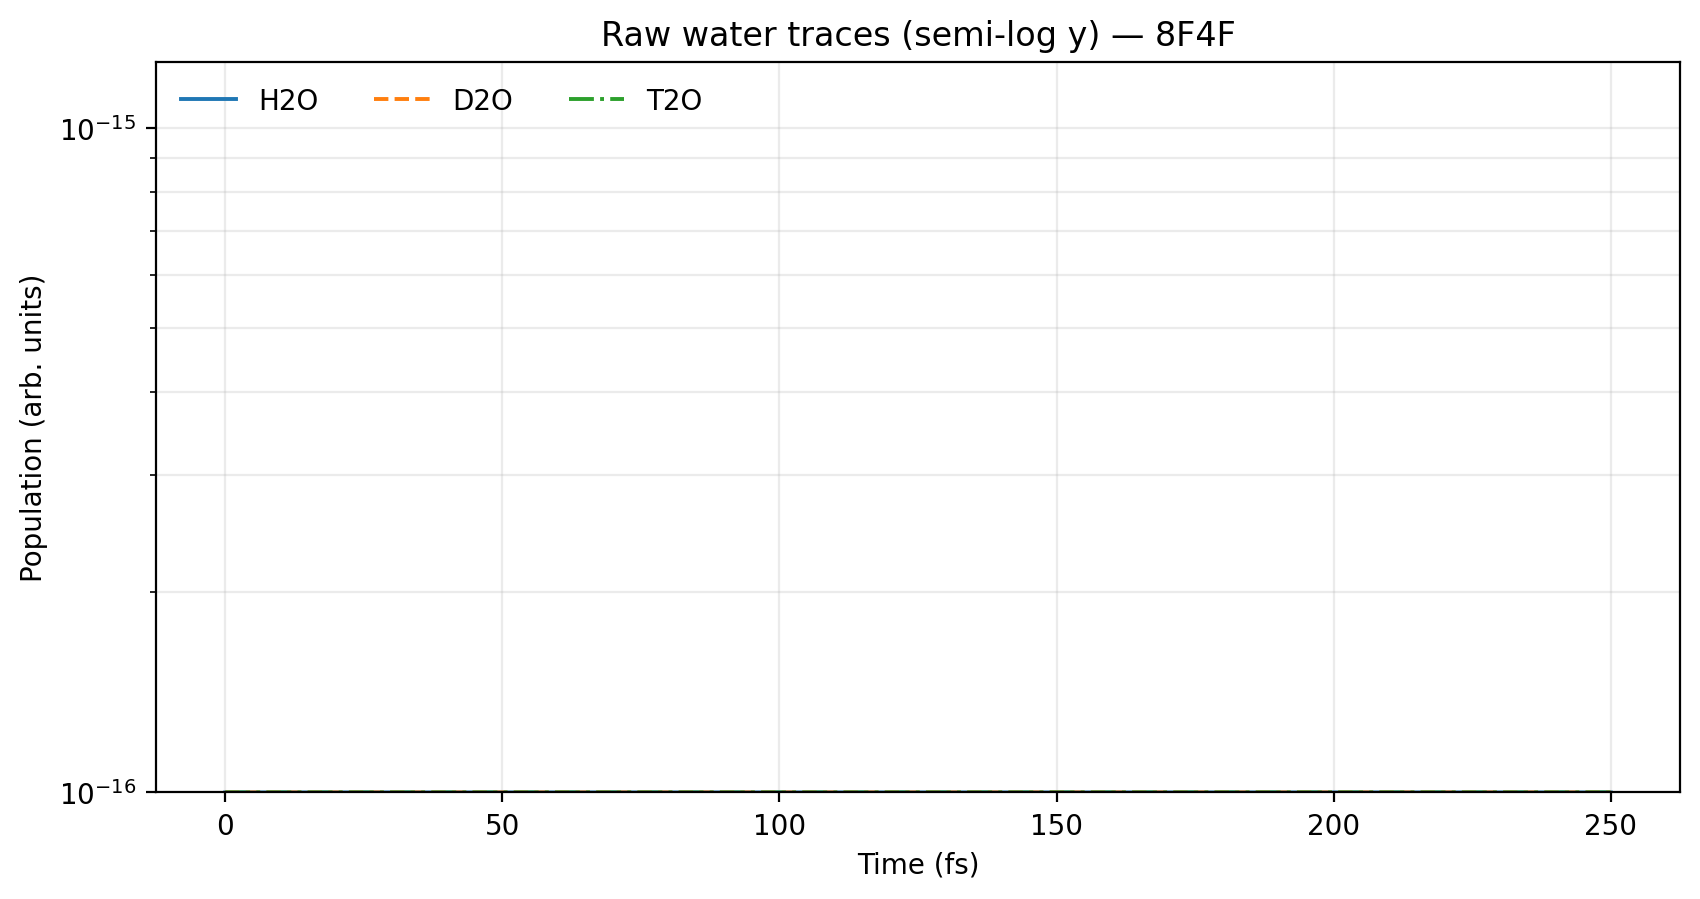

Wrote: /content/si_rawtrace_water_8F4F_semilog.png
       /content/si_rawtrace_water_8F4F_semilog.pdf


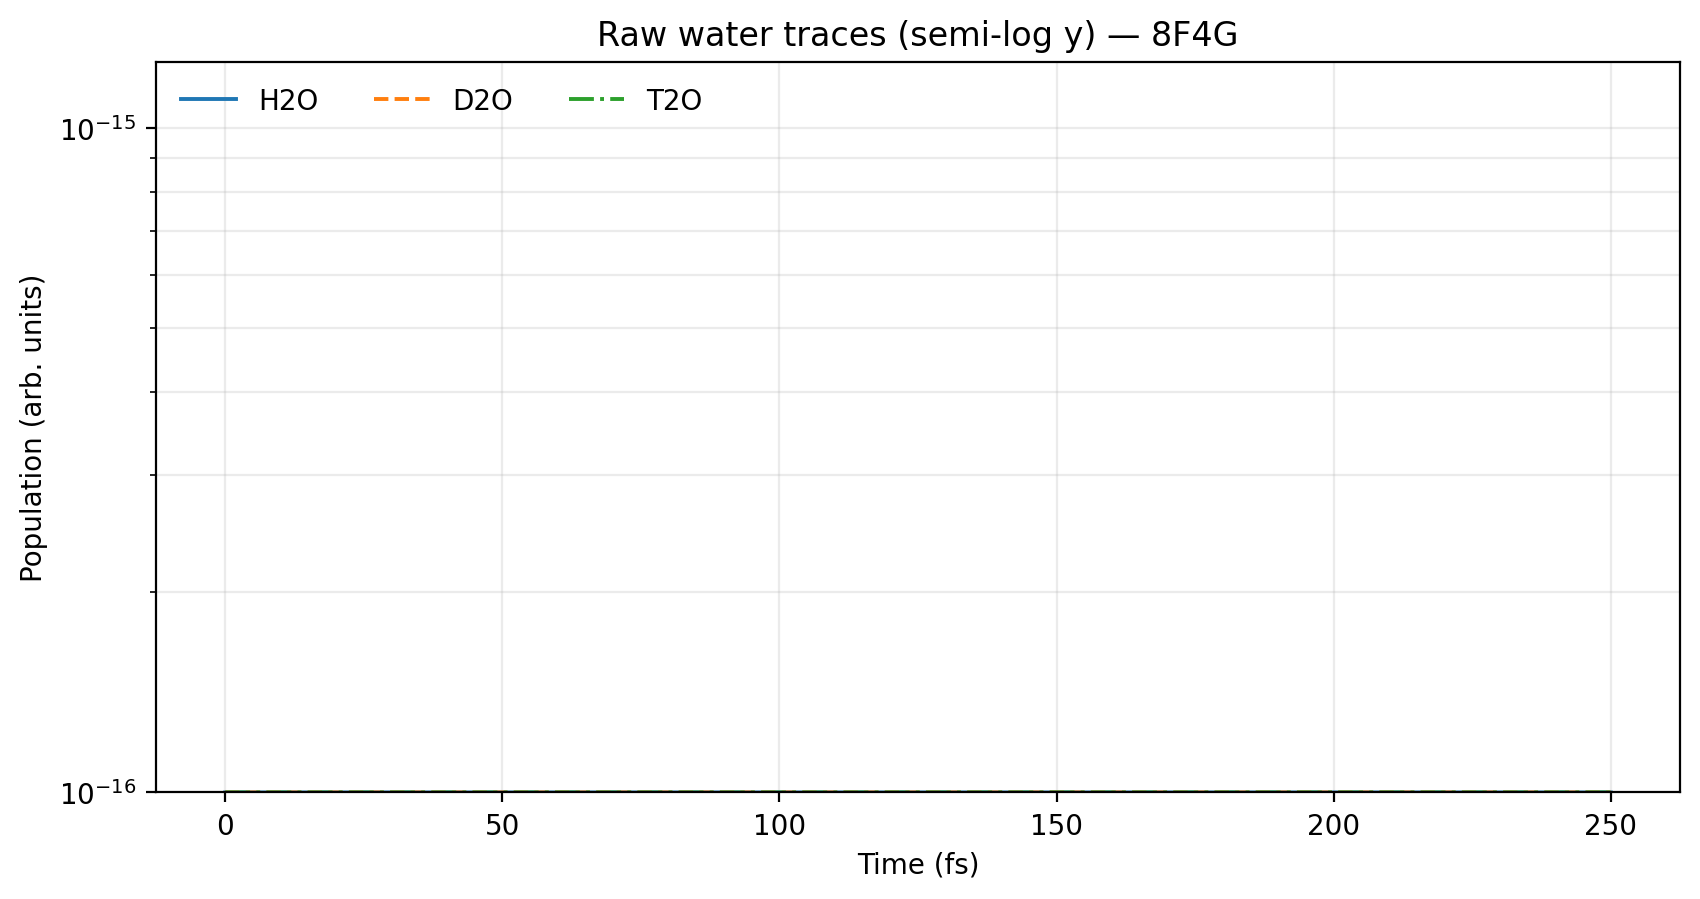

Wrote: /content/si_rawtrace_water_8F4G_semilog.png
       /content/si_rawtrace_water_8F4G_semilog.pdf


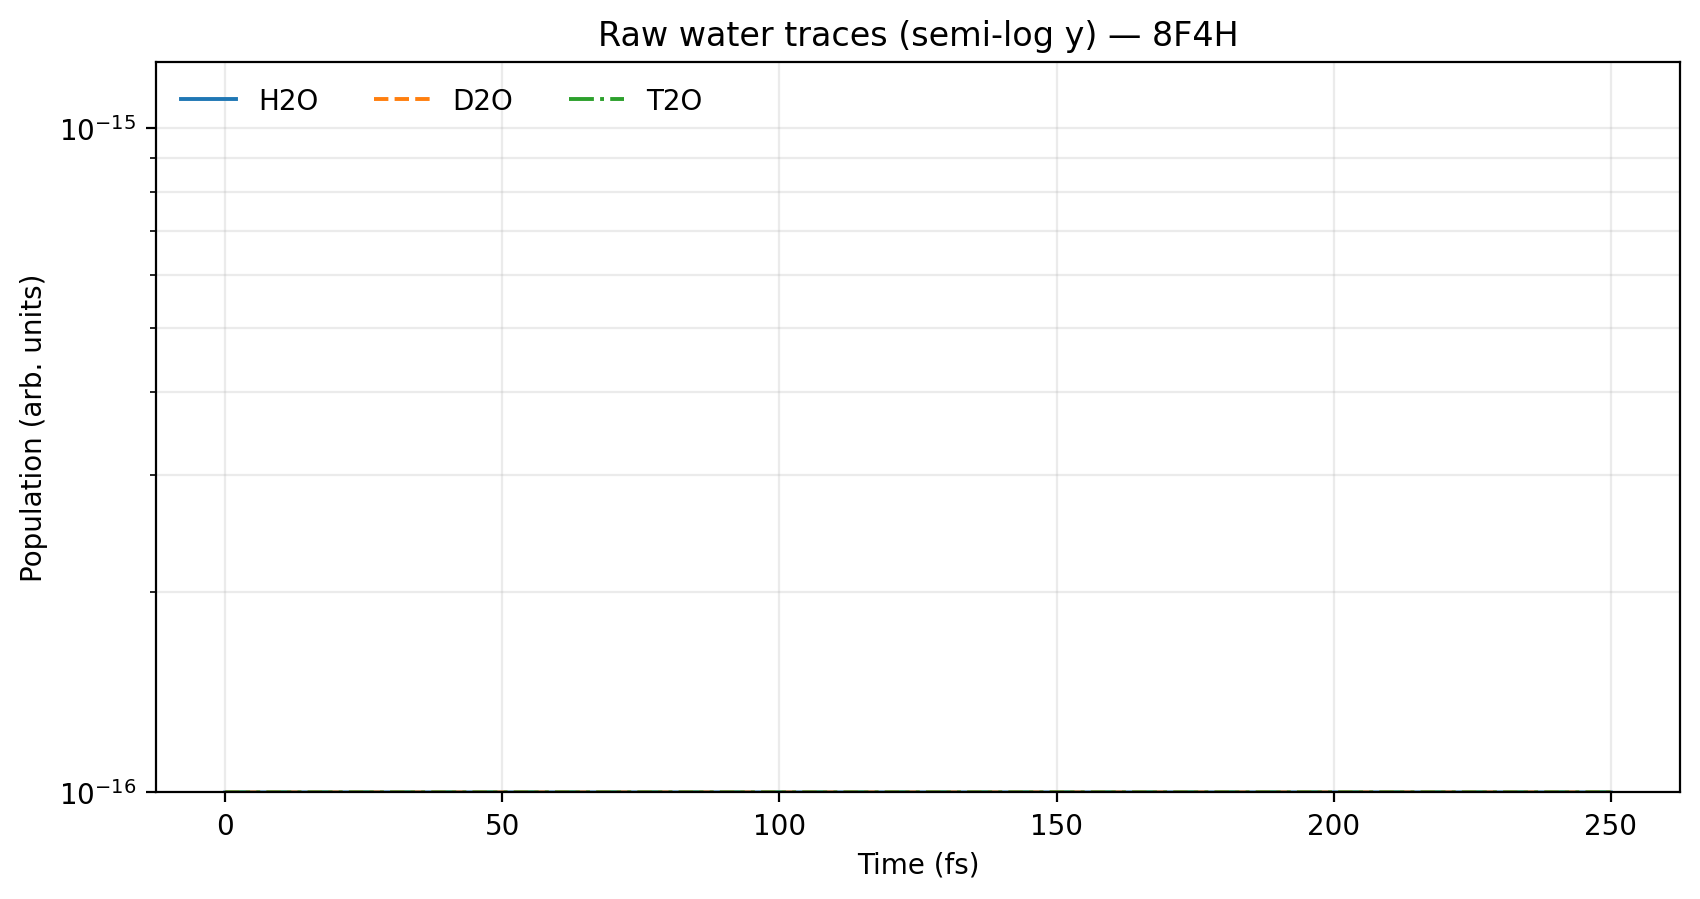

Wrote: /content/si_rawtrace_water_8F4H_semilog.png
       /content/si_rawtrace_water_8F4H_semilog.pdf


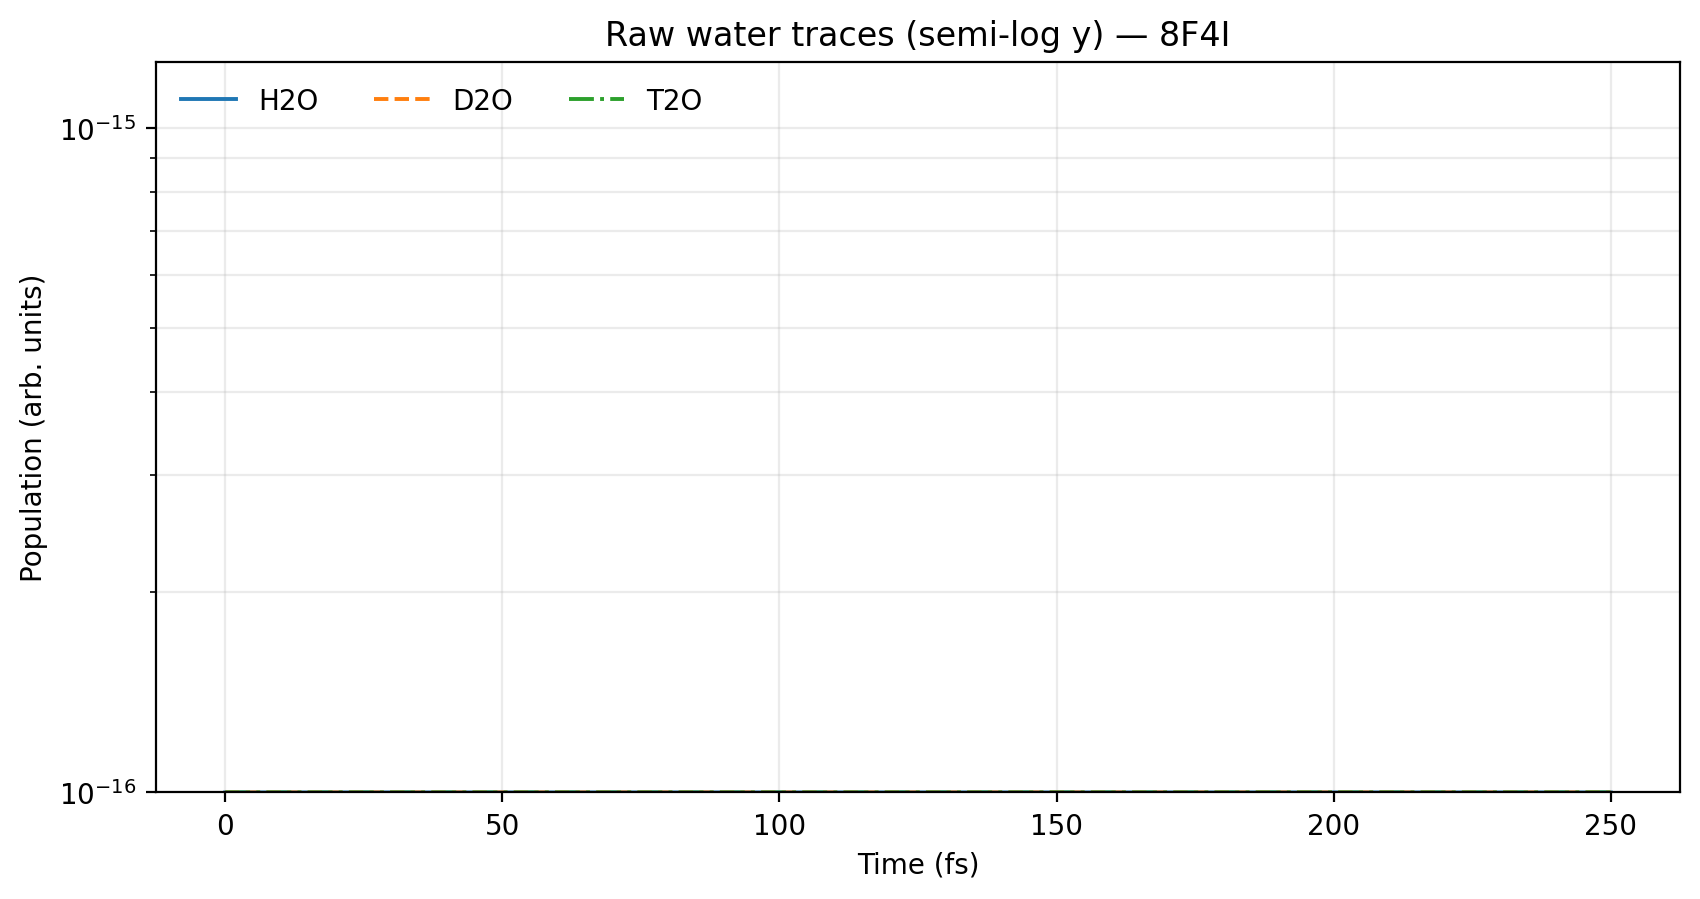

Wrote: /content/si_rawtrace_water_8F4I_semilog.png
       /content/si_rawtrace_water_8F4I_semilog.pdf


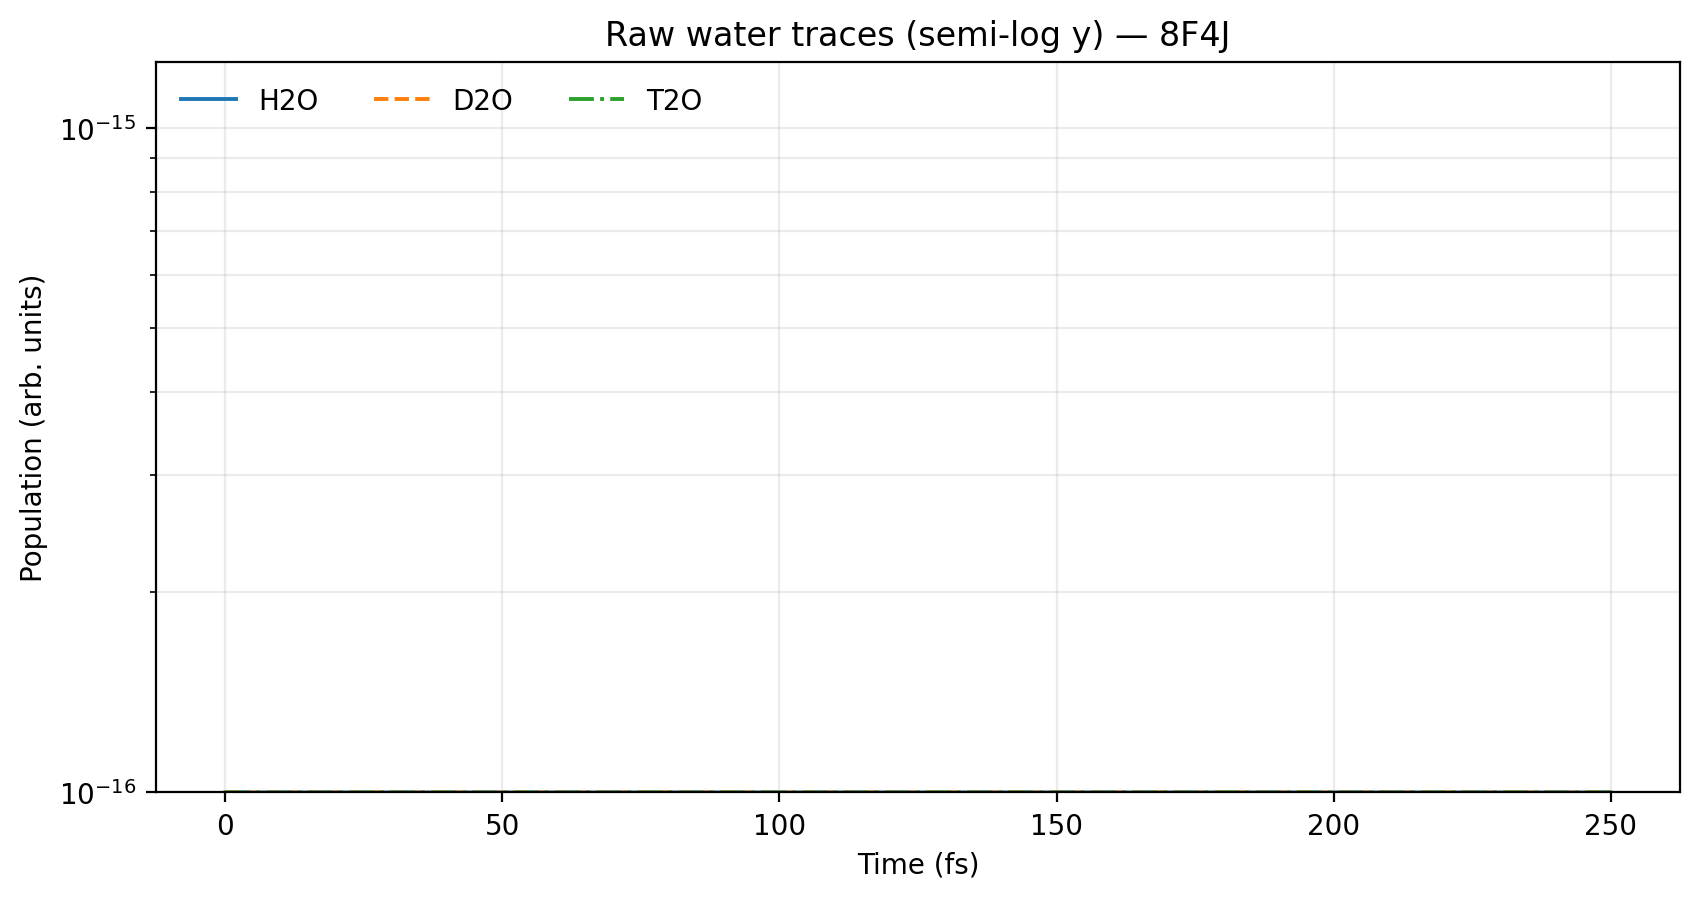

Wrote: /content/si_rawtrace_water_8F4J_semilog.png
       /content/si_rawtrace_water_8F4J_semilog.pdf


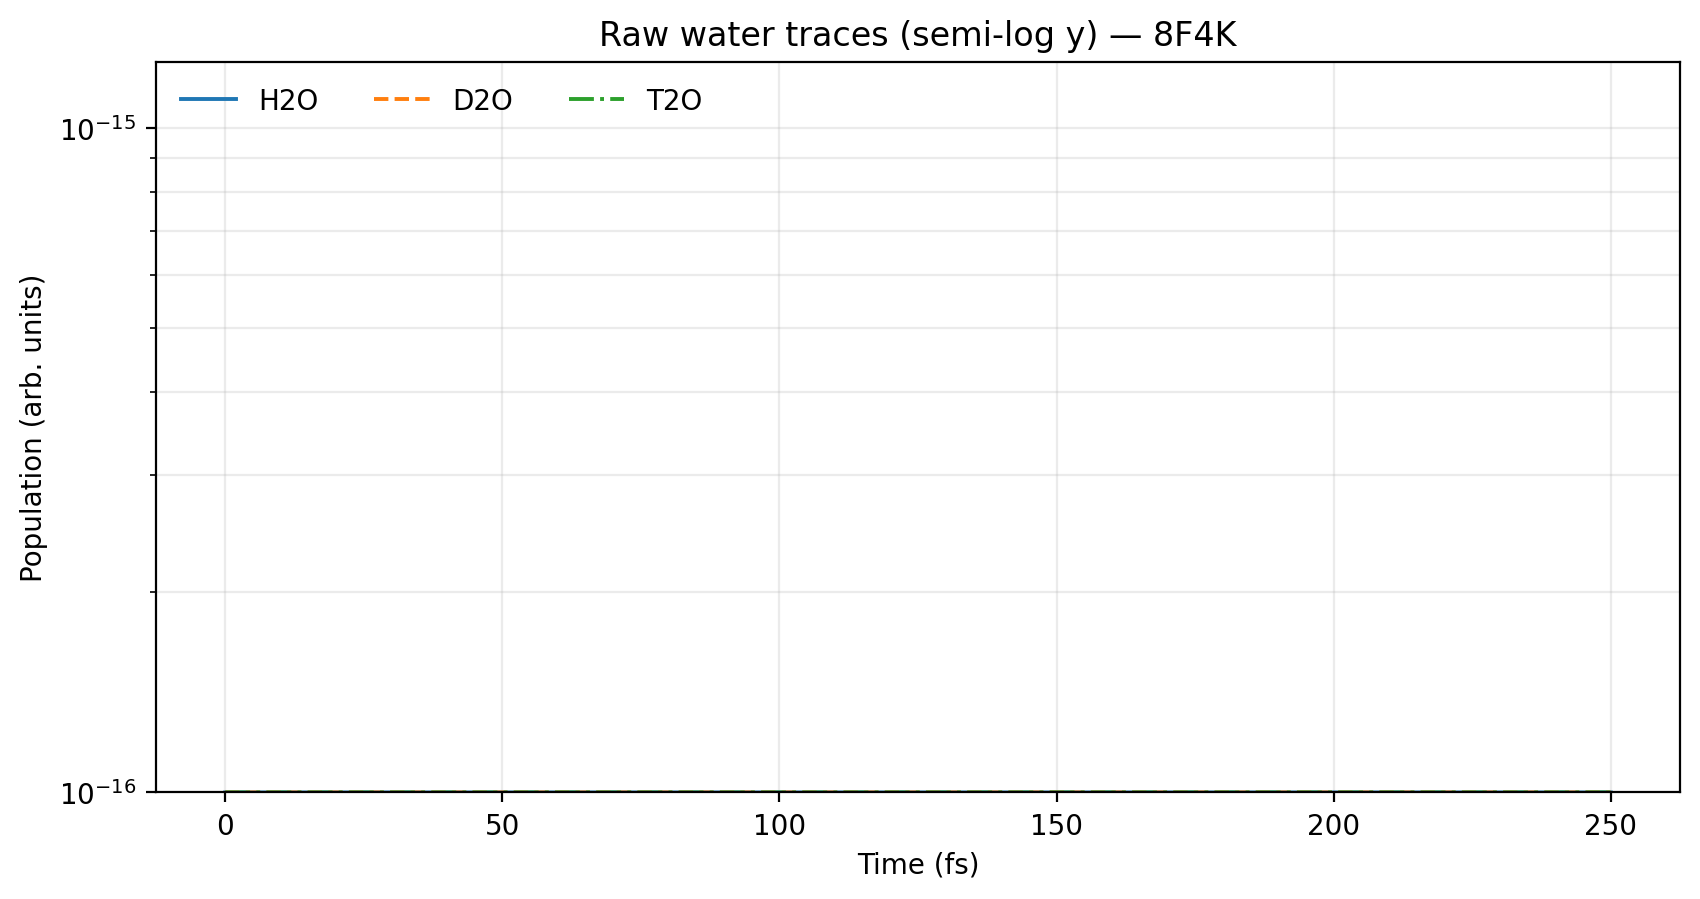

Wrote: /content/si_rawtrace_water_8F4K_semilog.png
       /content/si_rawtrace_water_8F4K_semilog.pdf

NEXT STEPS:
• If you want H2S/D2S/T2S raw traces, re-export a CSV that includes sulfur channels (e.g., pop_sw3/pop_sw4 or pop_sulfur_total).
• If the diagnostics show all zeros/minuscule values, consider checking units or the specific export routine.


In [ ]:
# --- CONFIG ---
CSV_PATH = "/content/all-GQR9-raw_timeseries.csv"   # adjust path if needed
TARGETS  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
MEDIA_WATER = ["H2O","D2O","T2O"]                   # we'll plot water-only here
OUTDIR   = "/content"
SEMILOG  = True

import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv(CSV_PATH, low_memory=False)
cols = df.columns.tolist()

def find_col(pattern):
    for c in cols:
        if re.search(pattern, c, re.I):
            return c
    return None

time_col = find_col(r"time")
cif_col  = find_col(r"\bcif\b|cif_id|pdb|structure")
med_col  = find_col(r"\b(medium|variant)\b")

if time_col is None or cif_col is None or med_col is None:
    raise RuntimeError(f"Detected cols -> time:{time_col}, cif:{cif_col}, medium:{med_col}. Please set manually.")

print("== DETECTED ==")
print("time:", time_col, "| cif:", cif_col, "| medium:", med_col)

# --- Do we have sulfur channels at all? ---
sulfur_cols = [c for c in cols if re.search(r"(pop_)?(sulfur|SW3|SW4)", c, re.I)]
print("\nSulfur-like columns found:", sulfur_cols if sulfur_cols else "NONE")
if not sulfur_cols:
    print("NOTE: This CSV has no SW3/SW4/pop_sulfur_total columns. "
          "Raw H2S/D2S/T2S traces cannot be built from this file. "
          "We can still plot water-only traces (H2O/D2O/T2O).")

# --- Quick diagnostic of the water columns across media ---
water_candidates = [c for c in cols if re.search(r"pop_water_total|pop_ow3|pop_ow4", c, re.I)]
print("\nWater-related columns present:", water_candidates)

def nz_summary(g):
    out = {}
    for c in water_candidates:
        if c in g:
            x = pd.to_numeric(g[c], errors="coerce")
            nz = np.isfinite(x) & (np.abs(x) > 0)
            out[c] = {
                "nonzero": int(nz.sum()),
                "min": float(np.nanmin(x)) if np.isfinite(x).any() else np.nan,
                "max": float(np.nanmax(x)) if np.isfinite(x).any() else np.nan,
                "mean_abs": float(np.nanmean(np.abs(x))) if np.isfinite(x).any() else np.nan
            }
    return out

def print_diagnostics_for_cif(cif_id):
    sub = df[df[cif_col] == cif_id]
    print(f"\n== CIF {cif_id} == (rows: {len(sub)})")
    if sub.empty:
        return
    med_vals = list(map(str, sub[med_col].dropna().unique()))
    print("media present:", sorted(med_vals))
    for m in sorted(med_vals):
        gm = sub[sub[med_col].astype(str) == m]
        d = nz_summary(gm)
        print(f"  -- {m} --")
        if not d:
            print("     (no water-related columns)")
        else:
            for k,v in d.items():
                print(f"     {k}: nonzero={v['nonzero']}, min={v['min']:.3e}, max={v['max']:.3e}, mean|x|={v['mean_abs']:.3e}")

for cif in TARGETS:
    print_diagnostics_for_cif(cif)

# --- Helper to construct a WATER series for plotting ---
def get_water_series(sub, medium):
    gm = sub[sub[med_col].astype(str).str.upper() == medium.upper()]
    if gm.empty:
        return None
    # prefer OW3+OW4, else pop_water_total
    ow_cols = [c for c in gm.columns if re.search(r"\bpop_?ow3\b|\bpop_?ow4\b", c, re.I)]
    if ow_cols:
        y = gm[ow_cols].sum(axis=1, numeric_only=True)
    else:
        if "pop_water_total" in gm.columns:
            y = pd.to_numeric(gm["pop_water_total"], errors="coerce")
        else:
            return None
    t = pd.to_numeric(gm[time_col], errors="coerce")
    # sort by time
    order = np.argsort(t.to_numpy())
    return t.to_numpy()[order], y.to_numpy()[order]

# --- Plot water-only traces for each CIF ---
def plot_water_only(cif_id):
    sub = df[df[cif_col] == cif_id]
    if sub.empty:
        print(f"[SKIP] {cif_id}: no rows")
        return
    fig, ax = plt.subplots(figsize=(8.6,4.6), dpi=200)
    styles = {"H2O":"-", "D2O":"--", "T2O":"-."}
    plotted = 0
    ymin_seen = np.inf

    for m in MEDIA_WATER:
        res = get_water_series(sub, m)
        if res is None:
            print(f"  [warn] {cif_id} / {m}: no water trace found.")
            continue
        t,y = res
        pos = y[np.isfinite(y) & (y > 0)]
        floor = max(1e-16, np.nanmedian(pos)*1e-4) if pos.size else 1e-16
        y_plot = np.where(y <= floor, floor, y)

        if SEMILOG:
            ax.semilogy(t, y_plot, styles.get(m,"-"), label=m, linewidth=1.4)
        else:
            ax.plot(t, y_plot, styles.get(m,"-"), label=m, linewidth=1.4)
        ymin_seen = min(ymin_seen, np.nanmin(y_plot))
        plotted += 1

    if plotted == 0:
        print(f"[SKIP] {cif_id}: nothing plotted (water columns missing or all-zero).")
        plt.close(fig)
        return

    ax.set_title(f"Raw water traces (semi-log y) — {cif_id}")
    ax.set_xlabel("Time (fs)")
    ax.set_ylabel("Population (arb. units)")
    ax.grid(True, which="both", alpha=0.25)
    ax.legend(loc="upper left", ncol=3, frameon=False)
    if SEMILOG:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(max(ymin, ymin_seen), ymax)

    fig.tight_layout()
    out_png = Path(OUTDIR) / f"si_rawtrace_water_{cif_id}_semilog.png"
    out_pdf = Path(OUTDIR) / f"si_rawtrace_water_{cif_id}_semilog.pdf"
    fig.savefig(out_png, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    print(f"Wrote: {out_png}\n       {out_pdf}")

print("\n=== WATER-ONLY PLOTS ===")
for cif in TARGETS:
    plot_water_only(cif)

print("\nNEXT STEPS:")
print("• If you want H2S/D2S/T2S raw traces, re-export a CSV that includes sulfur channels (e.g., pop_sw3/pop_sw4 or pop_sulfur_total).")
print("• If the diagnostics show all zeros/minuscule values, consider checking units or the specific export routine.")

In [ ]:
# Only useful when sulfur population columns exist in the CSV export
import numpy as np, pandas as pd, re
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = "/content/all-GQR9-raw_timeseries.csv"
OUTDIR   = "/content"
TARGETS  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]

df = pd.read_csv(CSV_PATH, low_memory=False)

def find_col(pattern):
    for c in df.columns:
        if re.search(pattern, c, re.I): return c
    return None

time_col = find_col(r"time")
cif_col  = find_col(r"\bcif\b|cif_id|pdb|structure")
med_col  = find_col(r"\b(medium|variant)\b")
ow3_col  = find_col(r"\bpop_?ow3\b")
ow4_col  = find_col(r"\bpop_?ow4\b")
wtotal   = find_col(r"\bpop_water_total\b")
sw3_col  = find_col(r"\bpop_?sw3\b")
sw4_col  = find_col(r"\bpop_?sw4\b")
stotal   = find_col(r"\bpop_sulfur_total\b")

if not all([time_col, cif_col, med_col]):
    raise RuntimeError("CSV missing time/cif/medium.")

def series(sub, medium, kind="water"):
    gm = sub[sub[med_col].astype(str).str.upper()==medium.upper()]
    if gm.empty: return None
    t = pd.to_numeric(gm[time_col], errors="coerce").to_numpy()
    if kind=="water":
        if ow3_col and ow4_col:
            y = pd.to_numeric(gm[ow3_col], errors="coerce").to_numpy() + pd.to_numeric(gm[ow4_col], errors="coerce").to_numpy()
        elif wtotal:
            y = pd.to_numeric(gm[wtotal], errors="coerce").to_numpy()
        else:
            return None
    else:
        if sw3_col and sw4_col:
            y = pd.to_numeric(gm[sw3_col], errors="coerce").to_numpy() + pd.to_numeric(gm[sw4_col], errors="coerce").to_numpy()
        elif stotal:
            y = pd.to_numeric(gm[stotal], errors="coerce").to_numpy()
        else:
            return None
    o = np.argsort(t)
    return t[o], y[o]

def dominant_freq(t_fs, y, seg_fs=31.25):
    # segment the first 250 fs into 8 windows of 31.25 fs, FFT per window, return median of peak freqs
    T_total = 250.0
    mask = (t_fs >= 0) & (t_fs <= T_total)
    t = t_fs[mask]; y = y[mask]
    if t.size < 8: return np.nan
    # uniform resampling for simple FFT
    dt = np.median(np.diff(np.sort(t)))  # fs
    if not np.isfinite(dt) or dt<=0: return np.nan
    # pad/trim to multiple of window
    nwin = int(T_total / seg_fs)
    win_edges = np.linspace(0, T_total, nwin+1)
    peaks = []
    for i in range(nwin):
        a, b = win_edges[i], win_edges[i+1]
        sel = (t>=a) & (t<b)
        if sel.sum()<4:
            continue
        tt = t[sel]; yy = y[sel] - np.nanmean(y[sel])
        # resample to uniform grid
        n = sel.sum()
        tt_u = np.linspace(tt.min(), tt.max(), n)
        yy_u = np.interp(tt_u, tt, yy)
        Y = np.fft.rfft(yy_u)
        freqs = np.fft.rfftfreq(n, d=(tt_u[1]-tt_u[0]))  # cycles per fs
        # convert to PHz: 1/fs ≡ 1e15 Hz, so (cycles/fs) = PHz
        p = np.abs(Y)
        if p.size<=1: continue
        # ignore DC
        p[0]=0
        k = np.argmax(p)
        peaks.append(freqs[k])  # already PHz
    return np.median(peaks) if peaks else np.nan

for cif in TARGETS:
    sub = df[df[cif_col]==cif]
    if sub.empty: continue
    res = []
    for m in ["H2O","H2S"]:
        w = series(sub, m, "water")
        s = series(sub, m, "sulfur")
        if w is None or s is None:
            continue
        f_w = dominant_freq(w[0], w[1])
        f_s = dominant_freq(s[0], s[1])
        res.append((m, f_w, f_s, (f_s/f_w if (np.isfinite(f_w) and f_w>0 and np.isfinite(f_s)) else np.nan)))
    if res:
        print(f"\n{cif}   H2O vs H2S dominant frequency (PHz) and ratio (S/O):")
        for m, fw, fs, r in res:
            print(f"  {m:3s}: water={fw:.3f}  sulfur={fs:.3f}  ratio={r:.3f}")

In [ ]:
# Only useful when sulfur population columns exist in the CSV export
import numpy as np, pandas as pd, re
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = "/content/all-GQR9-raw_timeseries.csv"
OUTDIR   = "/content"
TARGETS  = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]

df = pd.read_csv(CSV_PATH, low_memory=False)

def find_col(pattern):
    for c in df.columns:
        if re.search(pattern, c, re.I): return c
    return None

time_col = find_col(r"time")
cif_col  = find_col(r"\bcif\b|cif_id|pdb|structure")
med_col  = find_col(r"\b(medium|variant)\b")
ow3_col  = find_col(r"\bpop_?ow3\b")
ow4_col  = find_col(r"\bpop_?ow4\b")
wtotal   = find_col(r"\bpop_water_total\b")
sw3_col  = find_col(r"\bpop_?sw3\b")
sw4_col  = find_col(r"\bpop_?sw4\b")
stotal   = find_col(r"\bpop_sulfur_total\b")

if not all([time_col, cif_col, med_col]):
    raise RuntimeError("CSV missing time/cif/medium.")

def series(sub, medium, kind="water"):
    gm = sub[sub[med_col].astype(str).str.upper()==medium.upper()]
    if gm.empty: return None
    t = pd.to_numeric(gm[time_col], errors="coerce").to_numpy()
    if kind=="water":
        if ow3_col and ow4_col:
            y = pd.to_numeric(gm[ow3_col], errors="coerce").to_numpy() + pd.to_numeric(gm[ow4_col], errors="coerce").to_numpy()
        elif wtotal:
            y = pd.to_numeric(gm[wtotal], errors="coerce").to_numpy()
        else:
            return None
    else:
        if sw3_col and sw4_col:
            y = pd.to_numeric(gm[sw3_col], errors="coerce").to_numpy() + pd.to_numeric(gm[sw4_col], errors="coerce").to_numpy()
        elif stotal:
            y = pd.to_numeric(gm[stotal], errors="coerce").to_numpy()
        else:
            return None
    o = np.argsort(t)
    return t[o], y[o]

def dominant_freq(t_fs, y, seg_fs=31.25):
    # segment the first 250 fs into 8 windows of 31.25 fs, FFT per window, return median of peak freqs
    T_total = 250.0
    mask = (t_fs >= 0) & (t_fs <= T_total)
    t = t_fs[mask]; y = y[mask]
    if t.size < 8: return np.nan
    # uniform resampling for simple FFT
    dt = np.median(np.diff(np.sort(t)))  # fs
    if not np.isfinite(dt) or dt<=0: return np.nan
    # pad/trim to multiple of window
    nwin = int(T_total / seg_fs)
    win_edges = np.linspace(0, T_total, nwin+1)
    peaks = []
    for i in range(nwin):
        a, b = win_edges[i], win_edges[i+1]
        sel = (t>=a) & (t<b)
        if sel.sum()<4:
            continue
        tt = t[sel]; yy = y[sel] - np.nanmean(y[sel])
        # resample to uniform grid
        n = sel.sum()
        tt_u = np.linspace(tt.min(), tt.max(), n)
        yy_u = np.interp(tt_u, tt, yy)
        Y = np.fft.rfft(yy_u)
        freqs = np.fft.rfftfreq(n, d=(tt_u[1]-tt_u[0]))  # cycles per fs
        # convert to PHz: 1/fs ≡ 1e15 Hz, so (cycles/fs) = PHz
        p = np.abs(Y)
        if p.size<=1: continue
        # ignore DC
        p[0]=0
        k = np.argmax(p)
        peaks.append(freqs[k])  # already PHz
    return np.median(peaks) if peaks else np.nan

for cif in TARGETS:
    sub = df[df[cif_col]==cif]
    if sub.empty: continue
    res = []
    for m in ["H2O","H2S"]:
        w = series(sub, m, "water")
        s = series(sub, m, "sulfur")
        if w is None or s is None:
            continue
        f_w = dominant_freq(w[0], w[1])
        f_s = dominant_freq(s[0], s[1])
        res.append((m, f_w, f_s, (f_s/f_w if (np.isfinite(f_w) and f_w>0 and np.isfinite(f_s)) else np.nan)))
    if res:
        print(f"\n{cif}   H2O vs H2S dominant frequency (PHz) and ratio (S/O):")
        for m, fw, fs, r in res:
            print(f"  {m:3s}: water={fw:.3f}  sulfur={fs:.3f}  ratio={r:.3f}")